In [40]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os # Import os for path joining

# --- Configuration ---
# Use os.path.join for better path handling across different OS
BASE_DATA_DIR = r"C:\Users\ishsh\OneDrive\Desktop\QML_Project\results\encoded_data"
MRI_FILE = "mri_only_pca_10.csv"
MRI_PET_FILE = "mri_pet_pca_10.csv"

MRI_PATH = os.path.join(BASE_DATA_DIR, MRI_FILE)
MRI_PET_PATH = os.path.join(BASE_DATA_DIR, MRI_PET_FILE)

BASE_MODEL_SAVE_PATH = "base_model_mri.h5"
FINE_TUNED_MODEL_SAVE_PATH = "fine_tuned_model_mri_pet.h5"

TEST_SIZE = 0.2
RANDOM_STATE = 42
TASK_TYPE = 'classification' # 'classification' or 'regression' - adjusts loss/metrics/activation

# Training Hyperparameters
INITIAL_LEARNING_RATE = 0.001
FINE_TUNE_LEARNING_RATE = 1e-5 # Start low for fine-tuning
BATCH_SIZE = 32
MAX_INITIAL_EPOCHS = 100 # Set a max, Early Stopping will likely stop earlier
MAX_FINE_TUNE_EPOCHS = 100 # Set a max for fine-tuning
EARLY_STOPPING_PATIENCE = 15 # How many epochs to wait for validation improvement

# Transfer Learning Configuration
NUM_LAYERS_TO_UNFREEZE = 2 # Number of layers from the end to unfreeze (experiment: 1, 2, 3...)

# --- Function to Create a Complex Model with Regularization ---
# This model architecture is used for both base training and fine-tuning
def create_complex_regularized_model(input_shape):
    """
    Function to create a complex classical neural network model with regularization.
    Designed for good performance and generalization.
    """
    print(f"Creating a complex, regularized Dense network with input shape {input_shape}")
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(256, activation='relu'),
        Dropout(0.4), # Added Dropout layer (experiment with rate, e.g., 0.2 to 0.5)
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        # Add more layers/neurons/dropout as needed, but balance complexity with data
        Dense(1, activation='sigmoid' if TASK_TYPE == 'classification' else None) # Sigmoid for binary classification
    ])
    return model

# --- Helper Function to Load and Preprocess Data ---
# This scaler will be fitted ONLY on the first dataset's training split
global_scaler = None
def load_and_preprocess(file_path, fit_scaler=False):
    """
    Loads data, handles labels, and scales features using a global scaler.
    fit_scaler=True only for the initial training data source.
    """
    global global_scaler # Declare intent to use the global scaler

    try:
        data = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: Data file not found at {file_path}")
        return None, None, None

    X = data.iloc[:, :-1].values  # Features
    y = data.iloc[:, -1].values  # Labels

    # Scale features - Fit ONLY if fit_scaler is True, always transform
    if fit_scaler:
        global_scaler = StandardScaler()
        X_scaled = global_scaler.fit_transform(X)
        print("Fitted StandardScaler on this data.")
    else:
        if global_scaler is None:
             print("Error: Scaler not fitted yet! Fit scaler on the first dataset's training data.")
             return None, None, None
        X_scaled = global_scaler.transform(X)
        print("Transformed data using fitted StandardScaler.")


    # If classification and labels are not 0/1, convert them
    if TASK_TYPE == 'classification' and np.unique(y).size == 2 and not all(np.isin(y, [0, 1])):
         print(f"Warning: Assuming binary classification, converting labels {np.unique(y)} to 0/1.")
         unique_labels = np.unique(y)
         label_map = {unique_labels[0]: 0, unique_labels[1]: 1}
         y = np.array([label_map[label] for label in y])


    print(f"Loaded and processed data from {file_path}. Scaled X Shape: {X_scaled.shape}, y Shape: {y.shape}")
    return X_scaled, y, X_scaled.shape[1]


# --- Step 1: Train the Base Model on the MRI-only dataset ---

print("--- Step 1: Training Base Model on MRI-only dataset ---")

# Load and preprocess MRI data - Fit scaler on the training split
# Need to split *before* calling load_and_preprocess with fit_scaler=True
mri_data_full = pd.read_csv(MRI_PATH)
X_mri_full = mri_data_full.iloc[:, :-1].values
y_mri_full = mri_data_full.iloc[:, -1].values

X_train_mri_raw, X_test_mri_raw, y_train_mri, y_test_mri = train_test_split(
    X_mri_full, y_mri_full, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_mri_full if TASK_TYPE == 'classification' else None
)

# Now scale - Fit scaler *only* on the training subset
global_scaler = StandardScaler() # Initialize the global scaler
X_train_mri = global_scaler.fit_transform(X_train_mri_raw)
X_test_mri = global_scaler.transform(X_test_mri_raw) # Transform test set with fitted scaler

input_shape_mri = X_train_mri.shape[1]
print(f"Data shapes after split and scaling: Train={X_train_mri.shape}, Test={X_test_mri.shape}")


# Initialize the complex, regularized model
model_mri = create_complex_regularized_model(input_shape_mri)

# Define loss and metrics based on task type
if TASK_TYPE == 'classification':
    model_mri.compile(optimizer=Adam(learning_rate=INITIAL_LEARNING_RATE),
                       loss='binary_crossentropy', # Use binary_crossentropy for binary classification
                       metrics=['accuracy'])
    print("Compiled base model for binary classification.")
else: # Regression
     model_mri.compile(optimizer=Adam(learning_rate=INITIAL_LEARNING_RATE),
                       loss='mean_squared_error',
                       metrics=['mae']) # Use MAE for regression monitoring
     print("Compiled base model for regression.")


model_mri.summary()

# Add Early Stopping for preventing overfitting during initial training
early_stopping_initial = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)
print(f"\nUsing Early Stopping with patience={EARLY_STOPPING_PATIENCE} monitoring 'val_loss' for initial training.")

print(f"Fitting the base model on MRI-only dataset (max {MAX_INITIAL_EPOCHS} epochs)...")
history_mri = model_mri.fit(X_train_mri, y_train_mri,
                            epochs=MAX_INITIAL_EPOCHS,
                            batch_size=BATCH_SIZE,
                            validation_data=(X_test_mri, y_test_mri),
                            callbacks=[early_stopping_initial], # Add Early Stopping callback
                            verbose=1)
print("Base model training finished.")
print(f"Initial training stopped after {len(history_mri.history['loss'])} epochs.")


# Save the trained model
model_mri.save(BASE_MODEL_SAVE_PATH)
print(f"Base model saved as {BASE_MODEL_SAVE_PATH}")

# Evaluate base model performance on its test set
print("\nEvaluating base model on MRI-only test set:")
base_model_eval = model_mri.evaluate(X_test_mri, y_test_mri, verbose=0)
if TASK_TYPE == 'classification':
    print(f"MRI-only Test Loss: {base_model_eval[0]:.4f}, Accuracy: {base_model_eval[1]:.4f}")
else:
     print(f"MRI-only Test Loss (MSE): {base_model_eval[0]:.4f}, Test MAE: {base_model_eval[1]:.4f}")


# --- Step 2: Fine-Tune the Model on the MRI-PET dataset ---

print("\n--- Step 2: Fine-Tuning Model on MRI-PET dataset ---")

# Load and preprocess MRI-PET data - Use the *already fitted* global_scaler
mri_pet_data_full = pd.read_csv(MRI_PET_PATH)
X_mri_pet_full = mri_pet_data_full.iloc[:, :-1].values
y_mri_pet_full = mri_pet_data_full.iloc[:, -1].values

# Split *before* scaling
X_train_mri_pet_raw, X_test_mri_pet_raw, y_train_mri_pet, y_test_mri_pet = train_test_split(
    X_mri_pet_full, y_mri_pet_full, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_mri_pet_full if TASK_TYPE == 'classification' else None
)

# Transform both train and test sets using the *already fitted* scaler
if global_scaler is None:
    print("Error: Scaler was not fitted in Step 1. Cannot proceed with fine-tuning.")
    exit()

X_train_mri_pet = global_scaler.transform(X_train_mri_pet_raw)
X_test_mri_pet = global_scaler.transform(X_test_mri_pet_raw)

input_shape_mri_pet = X_train_mri_pet.shape[1]
print(f"MRI-PET Data shapes after split and scaling: Train={X_train_mri_pet.shape}, Test={X_test_mri_pet.shape}")


# Load the pre-trained model (from Step 1)
try:
    # Need to compile=False when loading if you plan to modify trainable status and re-compile
    base_model_mri = tf.keras.models.load_model(BASE_MODEL_SAVE_PATH, compile=False)
    print(f"Loaded base model from {BASE_MODEL_SAVE_PATH}")
except FileNotFoundError:
    print(f"Error: Base model file '{BASE_MODEL_SAVE_PATH}' not found. Run Step 1 first.")
    exit()

# Ensure the input shape matches the loaded model's expected input shape
if input_shape_mri_pet != base_model_mri.input_shape[1]:
    print(f"Error: Input shapes of processed MRI-PET data ({input_shape_mri_pet}) and base model input ({base_model_mri.input_shape[1]}) differ.")
    print("Transfer learning requires the input feature dimension to be the same.")
    exit()


# --- Unfreeze layers for fine-tuning ---
# Set layers to non-trainable except the last 'NUM_LAYERS_TO_UNFREEZE' layers
print(f"Freezing all layers except the last {NUM_LAYERS_TO_UNFREEZE} for fine-tuning...")
for layer in base_model_mri.layers:
    layer.trainable = False

# Explicitly set the last N layers as trainable
for i in range(1, NUM_LAYERS_TO_UNFREEZE + 1):
    if len(base_model_mri.layers) - i >= 0:
        base_model_mri.layers[-i].trainable = True
        print(f"  - Unfroze layer: {base_model_mri.layers[-i].name}")
    else:
        print(f"Warning: Cannot unfreeze {NUM_LAYERS_TO_UNFREEZE} layers, model only has {len(base_model_mri.layers)}.")
        break

# --- End of Unfreeze layers ---


# Compile the model for fine-tuning (important to re-compile after changing trainable status)
# Use a much lower learning rate for fine-tuning
if TASK_TYPE == 'classification':
    base_model_mri.compile(optimizer=Adam(learning_rate=FINE_TUNE_LEARNING_RATE),
                           loss='binary_crossentropy', # Use binary_crossentropy for binary classification
                           metrics=['accuracy'])
    print(f"Compiled fine-tuning model for binary classification with LR {FINE_TUNE_LEARNING_RATE}.")
else: # Regression
    base_model_mri.compile(optimizer=Adam(learning_rate=FINE_TUNE_LEARNING_RATE),
                           loss='mean_squared_error',
                           metrics=['mae'])
    print(f"Compiled fine-tuning model for regression with LR {FINE_TUNE_LEARNING_RATE}.")


base_model_mri.summary() # See which layers are trainable

# Add Early Stopping for fine-tuning
early_stopping_ft = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)
print(f"\nUsing Early Stopping with patience={EARLY_STOPPING_PATIENCE} monitoring 'val_loss' for fine-tuning.")


print(f"Fitting the fine-tuning model on MRI-PET dataset (max {MAX_FINE_TUNE_EPOCHS} epochs)...")
history_mri_pet = base_model_mri.fit(X_train_mri_pet, y_train_mri_pet,
                                    epochs=MAX_FINE_TUNE_EPOCHS,
                                    batch_size=BATCH_SIZE,
                                    validation_data=(X_test_mri_pet, y_test_mri_pet),
                                    callbacks=[early_stopping_ft], # Add Early Stopping callback
                                    verbose=1)
print("Fine-tuning finished.")
print(f"Fine-tuning stopped after {len(history_mri_pet.history['loss'])} epochs.")


# Save the fine-tuned model
base_model_mri.save(FINE_TUNED_MODEL_SAVE_PATH)
print(f"Fine-tuned model saved as {FINE_TUNED_MODEL_SAVE_PATH}")

# Evaluate fine-tuned model performance on its test set (the primary goal)
print("\n--- Evaluating Fine-Tuned Model on MRI-PET Test Set ---")
fine_tuned_model_eval_pet = base_model_mri.evaluate(X_test_mri_pet, y_test_mri_pet, verbose=0)
if TASK_TYPE == 'classification':
    print(f"MRI-PET Test Loss: {fine_tuned_model_eval_pet[0]:.4f}, Accuracy: {fine_tuned_model_eval_pet[1]:.4f}")
else:
     print(f"MRI-PET Test Loss (MSE): {fine_tuned_model_eval_pet[0]:.4f}, Test MAE: {fine_tuned_model_eval_pet[1]:.4f}")


print("\nScript execution finished.")
print("The final accuracy/metric reported is on the MRI-PET test set after fine-tuning.")

--- Step 1: Training Base Model on MRI-only dataset ---
Data shapes after split and scaling: Train=(433, 10), Test=(109, 10)
Creating a complex, regularized Dense network with input shape 10
Compiled base model for binary classification.


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_39 (Dense)                │ (None, 256)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,081 (180.00 KB)

 Trainable params: 46,081 (180.00 KB)

 Non-trainable params: 0 (0.00 B)


Using Early Stopping with patience=15 monitoring 'val_loss' for initial training.
Fitting the base model on MRI-only dataset (max 100 epochs)...
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6398 - loss: 0.6225 - val_accuracy: 0.8165 - val_loss: 0.4440
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8310 - loss: 0.4203 - val_accuracy: 0.8165 - val_loss: 0.4076
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8179 - loss: 0.3931 - val_accuracy: 0.8165 - val_loss: 0.4035
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7992 - loss: 0.4019 - val_accuracy: 0.8165 - val_loss: 0.4093
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8041 - loss: 0.3844 - val_accuracy: 0.8165 - val_loss: 0.4097
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8377 - loss: 0.3668 - val_accuracy: 0.8165 - val_loss: 0.4144
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8190 - loss: 0.3640 - val_

Base model training finished.
Initial training stopped after 18 epochs.
Base model saved as base_model_mri.h5

Evaluating base model on MRI-only test set:
MRI-only Test Loss: 0.4035, Accuracy: 0.8165

--- Step 2: Fine-Tuning Model on MRI-PET dataset ---
MRI-PET Data shapes after split and scaling: Train=(33, 10), Test=(9, 10)
Loaded base model from base_model_mri.h5
Freezing all layers except the last 2 for fine-tuning...
  - Unfroze layer: dense_43
  - Unfroze layer: dropout_11
Compiled fine-tuning model for binary classification with LR 1e-05.


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_39 (Dense)                │ (None, 256)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,081 (180.00 KB)

 Trainable params: 33 (132.00 B)

 Non-trainable params: 46,048 (179.88 KB)


Using Early Stopping with patience=15 monitoring 'val_loss' for fine-tuning.
Fitting the fine-tuning model on MRI-PET dataset (max 100 epochs)...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - accuracy: 0.5713 - loss: 0.7075 - val_accuracy: 0.5556 - val_loss: 0.5742
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5713 - loss: 0.6842 - val_accuracy: 0.5556 - val_loss: 0.5742
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5713 - loss: 0.6361 - val_accuracy: 0.5556 - val_loss: 0.5742
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5713 - loss: 0.7300 - val_accuracy: 0.5556 - val_loss: 0.5742
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5818 - loss: 0.6659 - val_accuracy: 0.5556 - val_loss: 0.5742
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5818 - loss: 0.6489 - val_accuracy: 0.5556 - val_loss: 0.5742
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5713 - loss: 0.6904 - val_accura

Fine-tuning finished.
Fine-tuning stopped after 100 epochs.
Fine-tuned model saved as fine_tuned_model_mri_pet.h5

--- Evaluating Fine-Tuned Model on MRI-PET Test Set ---
MRI-PET Test Loss: 0.5738, Accuracy: 0.5556

Script execution finished.
The final accuracy/metric reported is on the MRI-PET test set after fine-tuning.


--- Starting Model Training Process ---


Loaded and processed data from C:\Users\ishsh\OneDrive\Desktop\QML_Project\results\encoded_data\mri_only_pca_10.csv. X Shape: (542, 10), y Shape: (542,)
Data split into: Training (433, 10), Validation (109, 10)
Creating a Dense network with input shape 10
Compiled model for binary classification.


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_44 (Dense)                │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,777 (46.00 KB)

 Trainable params: 11,777 (46.00 KB)

 Non-trainable params: 0 (0.00 B)

Training the model for 150 epochs...
Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8227 - loss: 0.5827 - val_accuracy: 0.8165 - val_loss: 0.4690
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8153 - loss: 0.4522 - val_accuracy: 0.8165 - val_loss: 0.4176
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8081 - loss: 0.4307 - val_accuracy: 0.8165 - val_loss: 0.4118
Epoch 4/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8060 - loss: 0.4264 - val_accuracy: 0.8165 - val_loss: 0.4079
Epoch 5/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8100 - loss: 0.4005 - val_accuracy: 0.8165 - val_loss: 0.4056
Epoch 6/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7976 - loss: 0.3957 - val_accuracy: 0.8165 - val_loss: 0.4049
Epoch 7/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8219 - loss: 0.3649 - val_accuracy: 0.8165 - val_loss: 0.4010
Epoch 8/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8193 - l

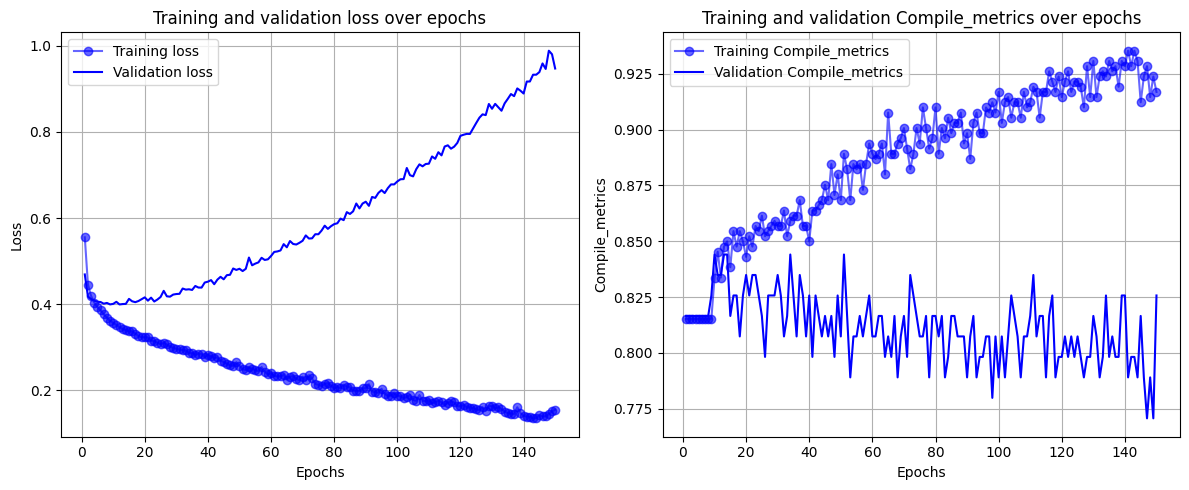


Script execution finished.
Review the plots to see how the training and validation metrics evolved throughout training.


In [41]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt # For plotting the training history

# --- Configuration ---
DATA_PATH = r"C:\Users\ishsh\OneDrive\Desktop\QML_Project\results\encoded_data\mri_only_pca_10.csv"
TEST_SIZE = 0.2 # Size of the validation set
RANDOM_STATE = 42
NUM_EPOCHS = 150 # Number of training iterations
BATCH_SIZE = 32
LEARNING_RATE = 0.001
TASK_TYPE = 'classification' # 'classification' or 'regression' - adjusts loss/metrics

# --- Function to Create the Model Architecture ---
# A model architecture with enough capacity to learn the data patterns
def create_model(input_shape):
    """
    Function to create a neural network model architecture.
    """
    print(f"Creating a Dense network with input shape {input_shape}")
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid' if TASK_TYPE == 'classification' else None) # Sigmoid for binary classification output
    ])
    return model

# --- Helper Function to Load and Preprocess Data ---
def load_and_preprocess(file_path):
    try:
        data = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: Data file not found at {file_path}")
        return None, None, None

    X = data.iloc[:, :-1].values  # Features
    y = data.iloc[:, -1].values  # Labels

    # If classification and labels are not 0/1, convert them
    if TASK_TYPE == 'classification' and np.unique(y).size == 2 and not all(np.isin(y, [0, 1])):
         print(f"Warning: Assuming binary classification, converting labels {np.unique(y)} to 0/1.")
         unique_labels = np.unique(y)
         label_map = {unique_labels[0]: 0, unique_labels[1]: 1}
         y = np.array([label_map[label] for label in y])

    print(f"Loaded and processed data from {file_path}. X Shape: {X.shape}, y Shape: {y.shape}")
    return X, y, X.shape[1]

# --- Main Training Process ---

print("--- Starting Model Training Process ---")

# Load and split data into training and validation sets
X_data, y_data, input_shape = load_and_preprocess(DATA_PATH)
if X_data is None:
    exit()

# Split data, using stratification for classification to maintain label distribution
X_train, X_val, y_train, y_val = train_test_split(
    X_data, y_data, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_data if TASK_TYPE == 'classification' else None
)

print(f"Data split into: Training {X_train.shape}, Validation {X_val.shape}")

# Initialize the model
model = create_model(input_shape)

# Compile the model - setting up the optimizer, loss function, and metrics
if TASK_TYPE == 'classification':
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss='binary_crossentropy', # Loss for binary classification
                  metrics=['accuracy']) # Metric to track accuracy
    print("Compiled model for binary classification.")
else: # Regression
     model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                   loss='mean_squared_error', # Loss for regression
                   metrics=['mae']) # Metric to track Mean Absolute Error
     print("Compiled model for regression.")

model.summary()

print(f"Training the model for {NUM_EPOCHS} epochs...")
# Train the model and store the training history
history = model.fit(X_train, y_train,
                    epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_val, y_val), # Provide validation data
                    verbose=1 # Show progress per epoch
                   )
print("Model training finished.")

# --- Analyze Training History ---

print("\n--- Analyzing Training and Validation Metrics Over Epochs ---")

# Get the training and validation metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_metric_name = model.metrics_names[1] # Get the name of the primary metric (accuracy or mae)
# --- FIX START ---
# Get the correct metric name based on TASK_TYPE instead of relying on model.metrics_names[1]
if TASK_TYPE == 'classification':
    metric_name = 'accuracy'
elif TASK_TYPE == 'regression':
    metric_name = 'mae'
else:
    metric_name = 'unknown_metric' # Fallback, though should be accuracy or mae based on config

# Access history using the correct metric name
if metric_name in history.history:
    train_metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]
    metric_display_name = metric_name.capitalize()
else:
    print(f"Warning: Metric '{metric_name}' not found in history. History keys: {history.history.keys()}")
    train_metric = [0] * len(epochs) # Placeholder if metric not found
    val_metric = [0] * len(epochs)
    metric_display_name = "N/A"

# --- FIX END ---
epochs = range(1, len(train_loss) + 1)

# Print metrics at the end of training
print(f"\nMetrics after {NUM_EPOCHS} epochs:")
print(f"  Training Loss: {train_loss[-1]:.4f}, Training {train_metric_name.capitalize()}: {train_metric[-1]:.4f}")
print(f"  Validation Loss: {val_loss[-1]:.4f}, Validation {train_metric_name.capitalize()}: {val_metric[-1]:.4f}")


# --- Plotting History to Visualize Learning Progress ---
print("\nDisplaying plots of training and validation metrics over epochs...")

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training loss', alpha=0.6)
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Primary Metric (Accuracy or MAE)
plt.subplot(1, 2, 2)
plt.plot(epochs, train_metric, 'bo-', label=f'Training {train_metric_name.capitalize()}', alpha=0.6)
plt.plot(epochs, val_metric, 'b-', label=f'Validation {train_metric_name.capitalize()}')
plt.title(f'Training and validation {train_metric_name.capitalize()} over epochs')
plt.xlabel('Epochs')
plt.ylabel(train_metric_name.capitalize())
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nScript execution finished.")
print("Review the plots to see how the training and validation metrics evolved throughout training.")

In [43]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os # Import os for path joining

# --- Configuration ---
# Use os.path.join for better path handling across different OS
BASE_DATA_DIR = r"C:\Users\ishsh\OneDrive\Desktop\QML_Project\results"
MRI_FILE = "mri_only_imputed.csv"
MRI_PET_FILE = "mri_pet_imputed.csv"

MRI_PATH = os.path.join(BASE_DATA_DIR, MRI_FILE)
MRI_PET_PATH = os.path.join(BASE_DATA_DIR, MRI_PET_FILE)

BASE_MODEL_SAVE_PATH = "base_model_mri.h5"
FINE_TUNED_MODEL_SAVE_PATH = "fine_tuned_model_mri_pet.h5"

TEST_SIZE = 0.2
RANDOM_STATE = 42
TASK_TYPE = 'classification' # 'classification' or 'regression' - adjusts loss/metrics/activation

# Training Hyperparameters
INITIAL_LEARNING_RATE = 0.001
FINE_TUNE_LEARNING_RATE = 1e-5 # Start low for fine-tuning (experiment with 1e-6, 1e-7 if needed)
BATCH_SIZE = 32
MAX_INITIAL_EPOCHS = 100 # Set a max, Early Stopping will likely stop earlier
MAX_FINE_TUNE_EPOCHS = 100 # Set a max for fine-tuning
EARLY_STOPPING_PATIENCE = 15 # How many epochs to wait for validation improvement

# Transfer Learning Configuration
NUM_LAYERS_TO_UNFREEZE = 2 # Number of layers from the end to unfreeze (experiment: 1, 2, 3...)

# --- Function to Create a Complex Model with Regularization ---
# This model architecture is used for both base training and fine-tuning
def create_complex_regularized_model(input_shape):
    """
    Function to create a complex classical neural network model with regularization.
    Designed for good performance and generalization.
    """
    print(f"Creating a complex, regularized Dense network with input shape {input_shape}")
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(256, activation='relu'),
        Dropout(0.4), # Added Dropout layer (experiment with rate, e.2g., 0 to 0.5)
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        # Add more layers/neurons/dropout as needed, but balance complexity with data
        Dense(1, activation='sigmoid' if TASK_TYPE == 'classification' else None) # Sigmoid for binary classification
    ])
    return model

# --- Helper Function to Load and Preprocess Data with Consistent Scaling ---
# Scaler will be fitted ONLY on the first dataset's training split
global_scaler = None
# Reset scaler function for clarity if running multiple times
def reset_scaler():
    global global_scaler
    global_scaler = None
    print("Scaler reset.")


def load_and_preprocess(file_path, fit_scaler=False):
    """
    Loads data, handles labels, and scales features using a global scaler.
    fit_scaler=True only for the initial training data source's training split.
    """
    global global_scaler # Declare intent to use the global scaler

    try:
        data = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: Data file not found at {file_path}")
        return None, None, None

    X = data.iloc[:, :-1].values  # Features
    y = data.iloc[:, -1].values  # Labels

    # Scale features - Fit ONLY if fit_scaler is True, always transform
    if fit_scaler:
        if global_scaler is not None:
             print("Warning: Scaler is already fitted. Ignoring fit_scaler=True for this call.")
        else:
            global_scaler = StandardScaler()
            X_scaled = global_scaler.fit_transform(X)
            print("Fitted StandardScaler on this data.")
    else:
        if global_scaler is None:
             print("Error: Scaler not fitted yet! Fit scaler on the first dataset's training data first.")
             return None, None, None
        X_scaled = global_scaler.transform(X)
        print("Transformed data using fitted StandardScaler.")


    # If classification and labels are not 0/1, convert them
    if TASK_TYPE == 'classification' and np.unique(y).size == 2 and not all(np.isin(y, [0, 1])):
         print(f"Warning: Assuming binary classification, converting labels {np.unique(y)} to 0/1.")
         unique_labels = np.unique(y)
         label_map = {unique_labels[0]: 0, unique_labels[1]: 1}
         y = np.array([label_map[label] for label in y])


    print(f"Loaded and processed data from {file_path}. Scaled X Shape: {X_scaled.shape}, y Shape: {y.shape}")
    return X_scaled, y, X_scaled.shape[1]


# --- Step 1: Train the Base Model on the MRI-only dataset ---

print("--- Step 1: Training Base Model on MRI-only dataset ---")

# Reset scaler to ensure a clean fit on the first dataset's training data
reset_scaler()

# Load and preprocess MRI data - Fit scaler on the training split
# Need to split *before* calling load_and_preprocess with fit_scaler=True
mri_data_full = pd.read_csv(MRI_PATH)
X_mri_full = mri_data_full.iloc[:, :-1].values
y_mri_full = mri_data_full.iloc[:, -1].values

# Split *before* scaling
X_train_mri_raw, X_test_mri_raw, y_train_mri, y_test_mri = train_test_split(
    X_mri_full, y_mri_full, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_mri_full if TASK_TYPE == 'classification' else None
)

# Now scale - Fit scaler *only* on the training subset
global_scaler = StandardScaler() # Initialize the global scaler
X_train_mri = global_scaler.fit_transform(X_train_mri_raw)

# Transform test data using the *fitted* scaler
X_test_mri = global_scaler.transform(X_test_mri_raw)

input_shape_mri = X_train_mri.shape[1]
print(f"Data shapes after split and scaling: Train={X_train_mri.shape}, Test={X_test_mri.shape}")


# Initialize the complex, regularized model
model_mri = create_complex_regularized_model(input_shape_mri)

# Define loss and metrics based on task type
if TASK_TYPE == 'classification':
    model_mri.compile(optimizer=Adam(learning_rate=INITIAL_LEARNING_RATE),
                       loss='binary_crossentropy', # Use binary_crossentropy for binary classification
                       metrics=['accuracy'])
    print("Compiled base model for binary classification.")
else: # Regression
     model_mri.compile(optimizer=Adam(learning_rate=INITIAL_LEARNING_RATE),
                       loss='mean_squared_error',
                       metrics=['mae']) # Use MAE for regression monitoring
     print("Compiled base model for regression.")


model_mri.summary()

# Add Early Stopping for preventing overfitting during initial training
early_stopping_initial = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)
print(f"\nUsing Early Stopping with patience={EARLY_STOPPING_PATIENCE} monitoring 'val_loss' for initial training.")

print(f"Fitting the base model on MRI-only dataset (max {MAX_INITIAL_EPOCHS} epochs)...")
history_mri = model_mri.fit(X_train_mri, y_train_mri,
                            epochs=MAX_INITIAL_EPOCHS,
                            batch_size=BATCH_SIZE,
                            validation_data=(X_test_mri, y_test_mri),
                            callbacks=[early_stopping_initial], # Add Early Stopping callback
                            verbose=1)
print("Base model training finished.")
print(f"Initial training stopped after {len(history_mri.history['loss'])} epochs.")


# Save the trained model
model_mri.save(BASE_MODEL_SAVE_PATH)
print(f"Base model saved as {BASE_MODEL_SAVE_PATH}")

# Evaluate base model performance on its test set
print("\nEvaluating base model on MRI-only test set:")
base_model_eval = model_mri.evaluate(X_test_mri, y_test_mri, verbose=0)
if TASK_TYPE == 'classification':
    print(f"MRI-only Test Loss: {base_model_eval[0]:.4f}, Accuracy: {base_model_eval[1]:.4f}")
else:
     print(f"MRI-only Test Loss (MSE): {base_model_eval[0]:.4f}, Test MAE: {base_model_eval[1]:.4f}")


# --- Step 2: Fine-Tune the Model on the MRI-PET dataset ---

print("\n--- Step 2: Fine-Tuning Model on MRI-PET dataset ---")

# Load and preprocess MRI-PET data - Use the *already fitted* global_scaler
mri_pet_data_full = pd.read_csv(MRI_PET_PATH)
X_mri_pet_full = mri_pet_data_full.iloc[:, :-1].values
y_mri_pet_full = mri_pet_data_full.iloc[:, -1].values

# Split *before* scaling
X_train_mri_pet_raw, X_test_mri_pet_raw, y_train_mri_pet, y_test_mri_pet = train_test_split(
    X_mri_pet_full, y_mri_pet_full, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_mri_pet_full if TASK_TYPE == 'classification' else None
)

# Transform both train and test sets using the *already fitted* scaler
if global_scaler is None:
    print("Error: Scaler was not fitted in Step 1. Cannot proceed with fine-tuning.")
    exit()

X_train_mri_pet = global_scaler.transform(X_train_mri_pet_raw)
X_test_mri_pet = global_scaler.transform(X_test_mri_pet_raw)

input_shape_mri_pet = X_train_mri_pet.shape[1]
print(f"MRI-PET Data shapes after split and scaling: Train={X_train_mri_pet.shape}, Test={X_test_mri_pet.shape}")


# Load the pre-trained model (from Step 1)
try:
    # Need to compile=False when loading if you plan to modify trainable status and re-compile
    # Use custom_objects if your create_model function includes custom layers (like QNN layers)
    base_model_mri = tf.keras.models.load_model(BASE_MODEL_SAVE_PATH, compile=False) # , custom_objects={...}
    print(f"Loaded base model from {BASE_MODEL_SAVE_PATH}")
except FileNotFoundError:
    print(f"Error: Base model file '{BASE_MODEL_SAVE_PATH}' not found. Run Step 1 first.")
    exit()
except Exception as e:
    print(f"Error loading base model: {e}")
    exit()


# Ensure the input shape matches the loaded model's expected input shape
if input_shape_mri_pet != base_model_mri.input_shape[1]:
    print(f"Error: Input shapes of processed MRI-PET data ({input_shape_mri_pet}) and base model input ({base_model_mri.input_shape[1]}) differ.")
    print("Transfer learning requires the input feature dimension to be the same.")
    print("Check your PCA steps to ensure the final encoded dimensions are consistent.")
    exit()


# --- Unfreeze layers for fine-tuning ---
# Set layers to non-trainable except the last 'NUM_LAYERS_TO_UNFREEZE' layers
print(f"Freezing all layers except the last {NUM_LAYERS_TO_UNFREEZE} for fine-tuning...")
for layer in base_model_mri.layers:
    # Set trainable false first for all layers
    layer.trainable = False

# Explicitly set the last N layers as trainable
# Use len(base_model_mri.layers) for correct indexing
num_model_layers = len(base_model_mri.layers)
for i in range(1, NUM_LAYERS_TO_UNFREEZE + 1):
    layer_index = num_model_layers - i
    if layer_index >= 0:
        base_model_mri.layers[layer_index].trainable = True
        print(f"  - Unfroze layer: {base_model_mri.layers[layer_index].name}")
    else:
        print(f"Warning: Cannot unfreeze {NUM_LAYERS_TO_UNFREEZE} layers, model only has {num_model_layers}.")
        break

# --- End of Unfreeze layers ---


# Compile the model for fine-tuning (important to re-compile after changing trainable status)
# Use a much lower learning rate for fine-tuning
if TASK_TYPE == 'classification':
    base_model_mri.compile(optimizer=Adam(learning_rate=FINE_TUNE_LEARNING_RATE),
                           loss='binary_crossentropy', # Use binary_crossentropy for binary classification
                           metrics=['accuracy'])
    print(f"Compiled fine-tuning model for binary classification with LR {FINE_TUNE_LEARNING_RATE}.")
else: # Regression
    base_model_mri.compile(optimizer=Adam(learning_rate=FINE_TUNE_LEARNING_RATE),
                           loss='mean_squared_error',
                           metrics=['mae'])
    print(f"Compiled fine-tuning model for regression with LR {FINE_TUNE_LEARNING_RATE}.")


base_model_mri.summary() # See which layers are trainable

# Add Early Stopping for fine-tuning
early_stopping_ft = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)
print(f"\nUsing Early Stopping with patience={EARLY_STOPPING_PATIENCE} monitoring 'val_loss' for fine-tuning.")


print(f"Fitting the fine-tuning model on MRI-PET dataset (max {MAX_FINE_TUNE_EPOCHS} epochs)...")
history_mri_pet = base_model_mri.fit(X_train_mri_pet, y_train_mri_pet,
                                    epochs=MAX_FINE_TUNE_EPOCHS,
                                    batch_size=BATCH_SIZE,
                                    validation_data=(X_test_mri_pet, y_test_mri_pet),
                                    callbacks=[early_stopping_ft], # Add Early Stopping callback
                                    verbose=1)
print("Fine-tuning finished.")
print(f"Fine-tuning training stopped after {len(history_mri_pet.history['loss'])} epochs.")


# Save the fine-tuned model (This is your final model using both datasets)
base_model_mri.save(FINE_TUNED_MODEL_SAVE_PATH)
print(f"Fine-tuned model saved as {FINE_TUNED_MODEL_SAVE_PATH}")

# Evaluate fine-tuned model performance on its test set (the primary goal)
print("\n--- Evaluating Fine-Tuned Model on MRI-PET Test Set ---")
fine_tuned_model_eval_pet = base_model_mri.evaluate(X_test_mri_pet, y_test_mri_pet, verbose=0)
if TASK_TYPE == 'classification':
    print(f"MRI-PET Test Loss: {fine_tuned_model_eval_pet[0]:.4f}, Accuracy: {fine_tuned_model_eval_pet[1]:.4f}")
else:
     print(f"MRI-PET Test Loss (MSE): {fine_tuned_model_eval_pet[0]:.4f}, Test MAE: {fine_tuned_model_eval_pet[1]:.4f}")


print("\nScript execution finished.")
print(f"The final model saved at {FINE_TUNED_MODEL_SAVE_PATH} is the result of using both datasets.")

--- Step 1: Training Base Model on MRI-only dataset ---
Scaler reset.


ValueError: could not convert string to float: 'sub-105'

In [46]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os # Import os for path joining

# --- Configuration ---
# Use os.path.join for better path handling across different OS
BASE_DATA_DIR = r"C:\Users\ishsh\OneDrive\Desktop\QML_Project\results" # Updated directory
MRI_FILE = "mri_only_normalized.csv"       # Updated file name
MRI_PET_FILE = "mri_pet_normalized.csv"     # Updated file name

MRI_PATH = os.path.join(BASE_DATA_DIR, MRI_FILE)
MRI_PET_PATH = os.path.join(BASE_DATA_DIR, MRI_PET_FILE)

BASE_MODEL_SAVE_PATH = "base_model_mri_normalized.h5" # Updated save name
FINE_TUNED_MODEL_SAVE_PATH = "fine_tuned_model_mri_pet_normalized.h5" # Updated save name

TEST_SIZE = 0.2
RANDOM_STATE = 42
TASK_TYPE = 'classification' # 'classification' or 'regression' - adjusts loss/metrics/activation

# Training Hyperparameters
INITIAL_LEARNING_RATE = 0.001
FINE_TUNE_LEARNING_RATE = 1e-5 # Start low for fine-tuning (experiment with 1e-6, 1e-7 if needed)
BATCH_SIZE = 32
MAX_INITIAL_EPOCHS = 100 # Set a max, Early Stopping will likely stop earlier
MAX_FINE_TUNE_EPOCHS = 100 # Set a max for fine-tuning
EARLY_STOPPING_PATIENCE = 15 # How many epochs to wait for validation improvement

# Transfer Learning Configuration
NUM_LAYERS_TO_UNFREEZE = 2 # Number of layers from the end to unfreeze (experiment: 1, 2, 3...)

# --- Function to Create a Complex Classical Model with Regularization ---
# This model architecture is used for both base training and fine-tuning
def create_complex_regularized_classical_model(input_shape):
    """
    Function to create a complex classical neural network model with regularization.
    Designed for good performance and generalization using Dense layers.
    """
    print(f"Creating a complex, regularized classical Dense network with input shape {input_shape}")
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(256, activation='relu'),
        Dropout(0.4), # Added Dropout layer (experiment with rate, e.2g., 0 to 0.5)
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        # Add more layers/neurons/dropout as needed, but balance complexity with data
        Dense(1, activation='sigmoid' if TASK_TYPE == 'classification' else None) # Sigmoid for binary classification
    ])
    return model

# --- Helper Function to Load and Preprocess Data with Consistent Scaling ---
# Scaler will be fitted ONLY on the first dataset's training split
global_scaler = None
# Reset scaler function for clarity if running multiple times
def reset_scaler():
    global global_scaler
    global_scaler = None
    print("Scaler reset.")

def load_data_and_split(file_path, test_size, random_state, task_type):
    """Loads data, splits into train/test."""
    try:
        data = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: Data file not found at {file_path}")
        return None, None, None, None

    # Assuming the last column is the label and all others are features
    # If the first column is an ID, you'll need to adjust iloc[:, :-1] to iloc[:, 1:-1]
    # based on your file structure, as fixed in a previous response.
    # Assuming ID column is NOT present in these "normalized" files, use [:, :-1]
    # If ID is present, change iloc[:, :-1] to iloc[:, 1:-1]
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values

    # If classification and labels are not 0/1, convert them
    if task_type == 'classification' and np.unique(y).size == 2 and not all(np.isin(y, [0, 1])):
         print(f"Warning: Assuming binary classification, converting labels {np.unique(y)} to 0/1.")
         unique_labels = np.unique(y)
         label_map = {unique_labels[0]: 0, unique_labels[1]: 1}
         y = np.array([label_map[label] for label in y])

    # Split data, using stratification for classification to maintain label distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y if task_type == 'classification' else None
    )

    print(f"Loaded and split data from {file_path}. Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test


# --- Step 1: Train the Base Model on the MRI-only dataset ---

print("--- Step 1: Training Base Model on MRI-only dataset ---")

# Reset scaler to ensure a clean fit on the first dataset's training data
reset_scaler()

# Load and split MRI data - Fit scaler on the training split
# Need to split *before* calling load_and_preprocess with fit_scaler=True
mri_data_full = pd.read_csv(MRI_PATH)

# --- CRITICAL FIX VERIFICATION ---
# Assuming the first column (index 0) is the subject ID (like 'sub-105')
# and the last column is the numerical label.
# Select features from the second column (index 1) up to, but NOT including, the last column.
# If your file has a different structure, you MUST adjust this line accordingly.
try:
    X_mri_full = mri_data_full.iloc[:, 1:-1].values # Features exclude the first column (index 0)
    y_mri_full = mri_data_full.iloc[:, -1].values  # Label is the last column
    print(f"Successfully loaded raw data. X_mri_full shape: {X_mri_full.shape}, y_mri_full shape: {y_mri_full.shape}")
    # Check if the feature matrix still contains non-numeric types after slicing
    if not np.issubdtype(X_mri_full.dtype, np.number):
         print(f"Error: X_mri_full still contains non-numeric data after iloc[:, 1:-1]. Data type: {X_mri_full.dtype}")
         print("Please inspect your CSV file for non-numeric values in columns other than the first and last.")
         # You might need to inspect the first few rows/columns manually
         # print(mri_data_full.head())
         # print(mri_data_full.info())
         exit() # Exit if non-numeric data is still present

except IndexError:
    print("Error: Indexing failed. Check if your file has enough columns (at least 3: ID, Feature(s), Label).")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during initial data loading: {e}")
    exit()
# --- END CRITICAL FIX VERIFICATION ---


# Split *before* scaling
X_train_mri_raw, X_test_mri_raw, y_train_mri, y_test_mri = train_test_split(
    X_mri_full, y_mri_full, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_mri_full if TASK_TYPE == 'classification' else None
)

# Now scale - Fit scaler *only* on the training subset
global_scaler = StandardScaler() # Initialize the global scaler
print("Attempting to fit scaler...")
# The error happens on the line below if X_train_mri_raw contains non-numeric data
X_train_mri = global_scaler.fit_transform(X_train_mri_raw)
print("Scaler fitted successfully.")


# Transform test data using the *fitted* scaler
print("Attempting to transform test data...")
X_test_mri = global_scaler.transform(X_test_mri_raw)
print("Test data transformed successfully.")

input_shape_mri = X_train_mri.shape[1]
print(f"Scaled data shapes after split: Train={X_train_mri.shape}, Test={X_test_mri.shape}")


# ... rest of Step 1 and all of Step 2 ...
# (Ensure similar indexing logic is applied if you use load_and_preprocess helper elsewhere,
# but the current script uses iloc directly in the main block for the initial load)

# Initialize the complex, regularized classical model
model_mri = create_complex_regularized_classical_model(input_shape_mri)

# Define loss and metrics based on task type
if TASK_TYPE == 'classification':
    model_mri.compile(optimizer=Adam(learning_rate=INITIAL_LEARNING_RATE),
                       loss='binary_crossentropy', # Use binary_crossentropy for binary classification
                       metrics=['accuracy'])
    print("Compiled base model for binary classification.")
else: # Regression
     model_mri.compile(optimizer=Adam(learning_rate=INITIAL_LEARNING_RATE),
                       loss='mean_squared_error',
                       metrics=['mae']) # Use MAE for regression monitoring
     print("Compiled base model for regression.")


model_mri.summary()

# Add Early Stopping for preventing overfitting during initial training
early_stopping_initial = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)
print(f"\nUsing Early Stopping with patience={EARLY_STOPPING_PATIENCE} monitoring 'val_loss' for initial training.")

print(f"Fitting the base model on MRI-only dataset (max {MAX_INITIAL_EPOCHS} epochs)...")
history_mri = model_mri.fit(X_train_mri, y_train_mri,
                            epochs=MAX_INITIAL_EPOCHS,
                            batch_size=BATCH_SIZE,
                            validation_data=(X_test_mri, y_test_mri),
                            callbacks=[early_stopping_initial], # Add Early Stopping callback
                            verbose=1)
print("Base model training finished.")
print(f"Initial training stopped after {len(history_mri.history['loss'])} epochs.")


# Save the trained model
model_mri.save(BASE_MODEL_SAVE_PATH)
print(f"Base model saved as {BASE_MODEL_SAVE_PATH}")

# Evaluate base model performance on its test set
print("\nEvaluating base model on MRI-only test set:")
base_model_eval = model_mri.evaluate(X_test_mri, y_test_mri, verbose=0)
if TASK_TYPE == 'classification':
    print(f"MRI-only Test Loss: {base_model_eval[0]:.4f}, Accuracy: {base_model_eval[1]:.4f}")
else:
     print(f"MRI-only Test Loss (MSE): {base_model_eval[0]:.4f}, Test MAE: {base_model_eval[1]:.4f}")


# --- Step 2: Fine-Tune the Model on the MRI-PET dataset ---

print("\n--- Step 2: Fine-Tuning Model on MRI-PET dataset ---")

# Load and split MRI-PET data
X_train_mri_pet_raw, X_test_mri_pet_raw, y_train_mri_pet, y_test_mri_pet = load_data_and_split(
    MRI_PET_PATH, TEST_SIZE, RANDOM_STATE, TASK_TYPE
)

if X_train_mri_pet_raw is None:
    exit()

# Transform both train and test sets using the *already fitted* scaler from Step 1
if global_scaler is None:
    print("Error: Scaler was not fitted in Step 1. Cannot proceed with fine-tuning.")
    exit()

X_train_mri_pet = global_scaler.transform(X_train_mri_pet_raw)
X_test_mri_pet = global_scaler.transform(X_test_mri_pet_raw)

input_shape_mri_pet = X_train_mri_pet.shape[1]
print(f"Scaled MRI-PET Data shapes after split: Train={X_train_mri_pet.shape}, Test={X_test_mri_pet.shape}")


# Load the pre-trained model (from Step 1)
try:
    # Need to compile=False when loading if you plan to modify trainable status and re-compile
    base_model_mri = tf.keras.models.load_model(BASE_MODEL_SAVE_PATH, compile=False)
    print(f"Loaded base model from {BASE_MODEL_SAVE_PATH}")
except FileNotFoundError:
    print(f"Error: Base model file '{BASE_MODEL_SAVE_PATH}' not found. Run Step 1 first.")
    exit()
except Exception as e:
    print(f"Error loading base model: {e}")
    exit()


# Ensure the input shape matches the loaded model's expected input shape
# This is crucial when switching from PCA to full features - dimensions MUST match!
if input_shape_mri_pet != base_model_mri.input_shape[1]:
    print(f"Error: Input shapes of processed MRI-PET data ({input_shape_mri_pet}) and base model input ({base_model_mri.input_shape[1]}) differ.")
    print("The number of features in mri_pet_normalized.csv must match the number of features in mri_only_normalized.csv")
    print("because the model architecture is fixed after Step 1.")
    exit()


# --- Unfreeze layers for fine-tuning ---
# Set layers to non-trainable except the last 'NUM_LAYERS_TO_UNFREEZE' layers
print(f"Freezing all layers except the last {NUM_LAYERS_TO_UNFREEZE} for fine-tuning...")
for layer in base_model_mri.layers:
    # Set trainable false first for all layers
    layer.trainable = False

# Explicitly set the last N layers as trainable
num_model_layers = len(base_model_mri.layers)
for i in range(1, NUM_LAYERS_TO_UNFREEZE + 1):
    layer_index = num_model_layers - i
    if layer_index >= 0:
        base_model_mri.layers[layer_index].trainable = True
        print(f"  - Unfroze layer: {base_model_mri.layers[layer_index].name}")
    else:
        print(f"Warning: Cannot unfreeze {NUM_LAYERS_TO_UNFREEZE} layers, model only has {num_model_layers}.")
        break

# --- End of Unfreeze layers ---


# Compile the model for fine-tuning (important to re-compile after changing trainable status)
# Use a much lower learning rate for fine-tuning
if TASK_TYPE == 'classification':
    base_model_mri.compile(optimizer=Adam(learning_rate=FINE_TUNE_LEARNING_RATE),
                           loss='binary_crossentropy', # Use binary_crossentropy for binary classification
                           metrics=['accuracy'])
    print(f"Compiled fine-tuning model for binary classification with LR {FINE_TUNE_LEARNING_RATE}.")
else: # Regression
    base_model_mri.compile(optimizer=Adam(learning_rate=FINE_TUNE_LEARNING_RATE),
                           loss='mean_squared_error',
                           metrics=['mae'])
    print(f"Compiled fine-tuning model for regression with LR {FINE_TUNE_LEARNING_RATE}.")


base_model_mri.summary() # See which layers are trainable

# Add Early Stopping for fine-tuning
early_stopping_ft = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)
print(f"\nUsing Early Stopping with patience={EARLY_STOPPING_PATIENCE} monitoring 'val_loss' for fine-tuning.")


print(f"Fitting the fine-tuning model on MRI-PET dataset (max {MAX_FINE_TUNE_EPOCHS} epochs)...")
history_mri_pet = base_model_mri.fit(X_train_mri_pet, y_train_mri_pet,
                                    epochs=MAX_FINE_TUNE_EPOCHS,
                                    batch_size=BATCH_SIZE,
                                    validation_data=(X_test_mri_pet, y_test_mri_pet),
                                    callbacks=[early_stopping_ft], # Add Early Stopping callback
                                    verbose=1)
print("Fine-tuning finished.")
print(f"Fine-tuning training stopped after {len(history_mri_pet.history['loss'])} epochs.")


# Save the fine-tuned model (This is your final model using both datasets)
base_model_mri.save(FINE_TUNED_MODEL_SAVE_PATH)
print(f"Fine-tuned model saved as {FINE_TUNED_MODEL_SAVE_PATH}")

# Evaluate fine-tuned model performance on its test set (the primary goal)
print("\n--- Evaluating Fine-Tuned Model on MRI-PET Test Set ---")
fine_tuned_model_eval_pet = base_model_mri.evaluate(X_test_mri_pet, y_test_mri_pet, verbose=0)
if TASK_TYPE == 'classification':
    print(f"MRI-PET Test Loss: {fine_tuned_model_eval_pet[0]:.4f}, Accuracy: {fine_tuned_model_eval_pet[1]:.4f}")
else:
     print(f"MRI-PET Test Loss (MSE): {fine_tuned_model_eval_pet[0]:.4f}, Test MAE: {fine_tuned_model_eval_pet[1]:.4f}")


print("\nScript execution finished.")
print(f"The final model saved at {FINE_TUNED_MODEL_SAVE_PATH} is the result of using both datasets.")

--- Step 1: Training Base Model on MRI-only dataset ---
Scaler reset.
Successfully loaded raw data. X_mri_full shape: (542, 678), y_mri_full shape: (542,)
Attempting to fit scaler...
Scaler fitted successfully.
Attempting to transform test data...
Test data transformed successfully.
Scaled data shapes after split: Train=(433, 678), Test=(109, 678)
Creating a complex, regularized classical Dense network with input shape 678
Compiled base model for binary classification.


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_53 (Dense)                │ (None, 256)            │       173,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,089 (848.00 KB)

 Trainable params: 217,089 (848.00 KB)

 Non-trainable params: 0 (0.00 B)


Using Early Stopping with patience=15 monitoring 'val_loss' for initial training.
Fitting the base model on MRI-only dataset (max 100 epochs)...
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7039 - loss: 0.5899 - val_accuracy: 0.8165 - val_loss: 0.4086
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8167 - loss: 0.4679 - val_accuracy: 0.8165 - val_loss: 0.4078
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8300 - loss: 0.4222 - val_accuracy: 0.8165 - val_loss: 0.4188
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7985 - loss: 0.4729 - val_accuracy: 0.8165 - val_loss: 0.4248
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8264 - loss: 0.4051 - val_accuracy: 0.8165 - val_loss: 0.4123
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8070 - loss: 0.4075 - val_accuracy: 0.8624 - val_loss: 0.4199
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8467 - loss: 0.3779 - val_

Base model training finished.
Initial training stopped after 24 epochs.
Base model saved as base_model_mri_normalized.h5

Evaluating base model on MRI-only test set:
MRI-only Test Loss: 0.4044, Accuracy: 0.8440

--- Step 2: Fine-Tuning Model on MRI-PET dataset ---
Loaded and split data from C:\Users\ishsh\OneDrive\Desktop\QML_Project\results\mri_pet_normalized.csv. Train shape: (33, 265), Test shape: (9, 265)


ValueError: could not convert string to float: 'sub-patient17'

In [48]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os # Import os for path joining

# --- Configuration ---
# Use os.path.join for better path handling across different OS
BASE_DATA_DIR = r"C:\Users\ishsh\OneDrive\Desktop\QML_Project\results" # Updated directory
MRI_FILE = "mri_only_normalized.csv"       # Updated file name
MRI_PET_FILE = "mri_pet_normalized.csv"     # Updated file name

MRI_PATH = os.path.join(BASE_DATA_DIR, MRI_FILE)
MRI_PET_PATH = os.path.join(BASE_DATA_DIR, MRI_PET_FILE)

BASE_MODEL_SAVE_PATH = "base_model_mri_normalized.h5" # Updated save name
FINE_TUNED_MODEL_SAVE_PATH = "fine_tuned_model_mri_pet_normalized.h5" # Updated save name

TEST_SIZE = 0.2
RANDOM_STATE = 42
TASK_TYPE = 'classification' # 'classification' or 'regression' - adjusts loss/metrics/activation

# Training Hyperparameters
INITIAL_LEARNING_RATE = 0.001
FINE_TUNE_LEARNING_RATE = 1e-5 # Start low for fine-tuning (experiment with 1e-6, 1e-7 if needed)
BATCH_SIZE = 32
MAX_INITIAL_EPOCHS = 100 # Set a max, Early Stopping will likely stop earlier
MAX_FINE_TUNE_EPOCHS = 100 # Set a max for fine-tuning
EARLY_STOPPING_PATIENCE = 15 # How many epochs to wait for validation improvement

# Transfer Learning Configuration
NUM_LAYERS_TO_UNFREEZE = 2 # Number of layers from the end to unfreeze (experiment: 1, 2, 3...)

# --- Function to Create a Complex Classical Model with Regularization ---
# This model architecture is used for both base training and fine-tuning
def create_complex_regularized_classical_model(input_shape):
    """
    Function to create a complex classical neural network model with regularization.
    Designed for good performance and generalization using Dense layers.
    """
    print(f"Creating a complex, regularized classical Dense network with input shape {input_shape}")
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(256, activation='relu'),
        Dropout(0.4), # Added Dropout layer (experiment with rate, e.g., 0.2 to 0.5)
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        # Add more layers/neurons/dropout as needed, but balance complexity with data
        Dense(1, activation='sigmoid' if TASK_TYPE == 'classification' else None) # Sigmoid for binary classification
    ])
    return model

# --- Helper Function to Load Data and Split ---
def load_data_and_split(file_path, test_size, random_state, task_type):
    """
    Loads data from CSV, separates features and labels, and splits into train/test sets.
    Assumes the first column is an ID and the last column is the label.
    """
    try:
        data = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: Data file not found at {file_path}")
        return None, None, None, None

    # --- CRITICAL FIX for Non-Numeric Columns ---
    # Assuming the first column (index 0) is an ID column (like 'sub-patient17' or 'sub-105')
    # and the last column is the numerical label.
    # Select features from the second column (index 1) up to, but NOT including, the last column.
    # If your files have a different structure, you MUST adjust these lines accordingly.
    try:
        X = data.iloc[:, 1:-1].values # Features exclude the first column (index 0)
        y = data.iloc[:, -1].values  # Label is the last column
        print(f"Loaded raw data from {file_path}. X shape: {X.shape}, y shape: {y.shape}")

        # Optional check: Verify the feature matrix contains only numeric types
        if not np.issubdtype(X.dtype, np.number):
             print(f"Error: Feature matrix from {file_path} still contains non-numeric data after slicing. Data type: {X.dtype}")
             print("Please inspect this CSV file for non-numeric values in columns other than the first and last.")
             # You might need to inspect the first few rows/columns manually
             # print(data.head())
             # print(data.info())
             return None, None, None, None # Return None to stop execution

    except IndexError:
        print(f"Error: Indexing failed for {file_path}. Check if your file has enough columns (at least 3: ID, Feature(s), Label).")
        return None, None, None, None # Return None to stop execution
    except Exception as e:
        print(f"An unexpected error occurred during loading {file_path}: {e}")
        return None, None, None, None # Return None to stop execution

    # --- END CRITICAL FIX ---

    # If classification and labels are not 0/1, convert them
    if task_type == 'classification' and np.unique(y).size == 2 and not all(np.isin(y, [0, 1])):
         print(f"Warning: Assuming binary classification, converting labels {np.unique(y)} to 0/1.")
         unique_labels = np.unique(y)
         label_map = {unique_labels[0]: 0, unique_labels[1]: 1}
         y = np.array([label_map[label] for label in y])

    # Split data, using stratification for classification to maintain label distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y if task_type == 'classification' else None
    )

    print(f"Split data from {file_path}. Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test

# --- Global Scaler ---
# Scaler will be fitted ONLY on the first dataset's training split and reused.
global_scaler = None
def reset_scaler():
    global global_scaler
    global_scaler = None
    print("Scaler reset.")

# --- Step 1: Train the Base Model on the MRI-only dataset ---

print("--- Step 1: Training Base Model on MRI-only dataset ---")

# Reset scaler to ensure a clean fit on the first dataset's training data
reset_scaler()

# Load and split MRI data using the helper function (includes the iloc[:, 1:-1] fix)
X_train_mri_raw, X_test_mri_raw, y_train_mri, y_test_mri = load_data_and_split(
    MRI_PATH, TEST_SIZE, RANDOM_STATE, TASK_TYPE
)

if X_train_mri_raw is None: # Exit if loading/splitting failed in the helper
    exit()

# Scale the data - Fit scaler *only* on the training subset of the first dataset
global_scaler = StandardScaler() # Initialize the global scaler
print("Attempting to fit scaler on MRI-only train data...")
X_train_mri = global_scaler.fit_transform(X_train_mri_raw) # This should now receive only numbers
print("Scaler fitted successfully.")

# Transform test data using the *fitted* scaler
print("Attempting to transform MRI-only test data...")
X_test_mri = global_scaler.transform(X_test_mri_raw) # This should now receive only numbers
print("MRI-only test data transformed successfully.")

input_shape_mri = X_train_mri.shape[1]
print(f"Scaled data shapes after split: Train={X_train_mri.shape}, Test={X_test_mri.shape}")


# Initialize the complex, regularized classical model
model_mri = create_complex_regularized_classical_model(input_shape_mri)

# Define loss and metrics based on task type
if TASK_TYPE == 'classification':
    model_mri.compile(optimizer=Adam(learning_rate=INITIAL_LEARNING_RATE),
                       loss='binary_crossentropy', # Use binary_crossentropy for binary classification
                       metrics=['accuracy'])
    print("Compiled base model for binary classification.")
else: # Regression
     model_mri.compile(optimizer=Adam(learning_rate=INITIAL_LEARNING_RATE),
                       loss='mean_squared_error',
                       metrics=['mae']) # Use MAE for regression monitoring
     print("Compiled base model for regression.")


model_mri.summary()

# Add Early Stopping for preventing overfitting during initial training
early_stopping_initial = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)
print(f"\nUsing Early Stopping with patience={EARLY_STOPPING_PATIENCE} monitoring 'val_loss' for initial training.")

print(f"Fitting the base model on MRI-only dataset (max {MAX_INITIAL_EPOCHS} epochs)...")
history_mri = model_mri.fit(X_train_mri, y_train_mri,
                            epochs=MAX_INITIAL_EPOCHS,
                            batch_size=BATCH_SIZE,
                            validation_data=(X_test_mri, y_test_mri),
                            callbacks=[early_stopping_initial], # Add Early Stopping callback
                            verbose=1)
print("Base model training finished.")
print(f"Initial training stopped after {len(history_mri.history['loss'])} epochs.")


# Save the trained model
model_mri.save(BASE_MODEL_SAVE_PATH)
print(f"Base model saved as {BASE_MODEL_SAVE_PATH}")

# Evaluate base model performance on its test set
print("\nEvaluating base model on MRI-only test set:")
base_model_eval = model_mri.evaluate(X_test_mri, y_test_mri, verbose=0)
if TASK_TYPE == 'classification':
    print(f"MRI-only Test Loss: {base_model_eval[0]:.4f}, Accuracy: {base_model_eval[1]:.4f}")
else:
     print(f"MRI-only Test Loss (MSE): {base_model_eval[0]:.4f}, Test MAE: {base_model_eval[1]:.4f}")


# --- Step 2: Fine-Tune the Model on the MRI-PET dataset ---

print("\n--- Step 2: Fine-Tuning Model on MRI-PET dataset ---")

# Load and split MRI-PET data using the helper function (includes the iloc[:, 1:-1] fix)
X_train_mri_pet_raw, X_test_mri_pet_raw, y_train_mri_pet, y_test_mri_pet = load_data_and_split(
    MRI_PET_PATH, TEST_SIZE, RANDOM_STATE, TASK_TYPE
)

if X_train_mri_pet_raw is None: # Exit if loading/splitting failed in the helper
    exit()

# Transform both train and test sets using the *already fitted* scaler from Step 1
if global_scaler is None:
    print("Error: Scaler was not fitted in Step 1. Cannot proceed with fine-tuning.")
    exit()

print("Attempting to transform MRI-PET train data...")
X_train_mri_pet = global_scaler.transform(X_train_mri_pet_raw) # This should now receive only numbers
print("MRI-PET train data transformed successfully.")

print("Attempting to transform MRI-PET test data...")
X_test_mri_pet = global_scaler.transform(X_test_mri_pet_raw) # This should now receive only numbers
print("MRI-PET test data transformed successfully.")

input_shape_mri_pet = X_train_mri_pet.shape[1]
print(f"Scaled MRI-PET Data shapes after split: Train={X_train_mri_pet.shape}, Test={X_test_mri_pet.shape}")


# Load the pre-trained model (from Step 1)
try:
    # Need to compile=False when loading if you plan to modify trainable status and re-compile
    base_model_mri = tf.keras.models.load_model(BASE_MODEL_SAVE_PATH, compile=False)
    print(f"Loaded base model from {BASE_MODEL_SAVE_PATH}")
except FileNotFoundError:
    print(f"Error: Base model file '{BASE_MODEL_SAVE_PATH}' not found. Run Step 1 first.")
    exit()
except Exception as e:
    print(f"Error loading base model: {e}")
    exit()


# Ensure the input shape matches the loaded model's expected input shape
# This is crucial - number of features MUST match between the two datasets after slicing!
if input_shape_mri_pet != base_model_mri.input_shape[1]:
    print(f"Error: Input shapes of processed MRI-PET data ({input_shape_mri_pet}) and base model input ({base_model_mri.input_shape[1]}) differ.")
    print("The number of features selected in mri_pet_normalized.csv must match the number of features selected in mri_only_normalized.csv")
    print("after excluding ID/Label columns. Check your CSV files' column counts.")
    exit()


# --- Unfreeze layers for fine-tuning ---
# Set layers to non-trainable except the last 'NUM_LAYERS_TO_UNFREEZE' layers
print(f"Freezing all layers except the last {NUM_LAYERS_TO_UNFREEZE} for fine-tuning...")
for layer in base_model_mri.layers:
    # Set trainable false first for all layers
    layer.trainable = False

# Explicitly set the last N layers as trainable
num_model_layers = len(base_model_mri.layers)
for i in range(1, NUM_LAYERS_TO_UNFREEZE + 1):
    layer_index = num_model_layers - i
    if layer_index >= 0:
        base_model_mri.layers[layer_index].trainable = True
        print(f"  - Unfroze layer: {base_model_mri.layers[layer_index].name}")
    else:
        print(f"Warning: Cannot unfreeze {NUM_LAYERS_TO_UNFREEZE} layers, model only has {num_model_layers}.")
        break

# --- End of Unfreeze layers ---


# Compile the model for fine-tuning (important to re-compile after changing trainable status)
# Use a much lower learning rate for fine-tuning
if TASK_TYPE == 'classification':
    base_model_mri.compile(optimizer=Adam(learning_rate=FINE_TUNE_LEARNING_RATE),
                           loss='binary_crossentropy', # Use binary_crossentropy for binary classification
                           metrics=['accuracy'])
    print(f"Compiled fine-tuning model for binary classification with LR {FINE_TUNE_LEARNING_RATE}.")
else: # Regression
    base_model_mri.compile(optimizer=Adam(learning_rate=FINE_TUNE_LEARNING_RATE),
                           loss='mean_squared_error',
                           metrics=['mae'])
    print(f"Compiled fine-tuning model for regression with LR {FINE_TUNE_LEARNING_RATE}.")


base_model_mri.summary() # See which layers are trainable

# Add Early Stopping for fine-tuning
early_stopping_ft = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)
print(f"\nUsing Early Stopping with patience={EARLY_STOPPING_PATIENCE} monitoring 'val_loss' for fine-tuning.")


print(f"Fitting the fine-tuning model on MRI-PET dataset (max {MAX_FINE_TUNE_EPOCHS} epochs)...")
history_mri_pet = base_model_mri.fit(X_train_mri_pet, y_train_mri_pet,
                                    epochs=MAX_FINE_TUNE_EPOCHS,
                                    batch_size=BATCH_SIZE,
                                    validation_data=(X_test_mri_pet, y_test_mri_pet),
                                    callbacks=[early_stopping_ft], # Add Early Stopping callback
                                    verbose=1)
print("Fine-tuning finished.")
print(f"Fine-tuning training stopped after {len(history_mri_pet.history['loss'])} epochs.")


# Save the fine-tuned model (This is your final model using both datasets)
base_model_mri.save(FINE_TUNED_MODEL_SAVE_PATH)
print(f"Fine-tuned model saved as {FINE_TUNED_MODEL_SAVE_PATH}")

# Evaluate fine-tuned model performance on its test set (the primary goal)
print("\n--- Evaluating Fine-Tuned Model on MRI-PET Test Set ---")
fine_tuned_model_eval_pet = base_model_mri.evaluate(X_test_mri_pet, y_test_mri_pet, verbose=0)
if TASK_TYPE == 'classification':
    print(f"MRI-PET Test Loss: {fine_tuned_model_eval_pet[0]:.4f}, Accuracy: {fine_tuned_model_eval_pet[1]:.4f}")
else:
     print(f"MRI-PET Test Loss (MSE): {fine_tuned_model_eval_pet[0]:.4f}, Test MAE: {fine_tuned_model_eval_pet[1]:.4f}")


print("\nScript execution finished.")
print(f"The final model saved at {FINE_TUNED_MODEL_SAVE_PATH} is the result of using both datasets.")

--- Step 1: Training Base Model on MRI-only dataset ---
Scaler reset.
Loaded raw data from C:\Users\ishsh\OneDrive\Desktop\QML_Project\results\mri_only_normalized.csv. X shape: (542, 677), y shape: (542,)
Split data from C:\Users\ishsh\OneDrive\Desktop\QML_Project\results\mri_only_normalized.csv. Train shape: (433, 677), Test shape: (109, 677)
Attempting to fit scaler on MRI-only train data...
Scaler fitted successfully.
Attempting to transform MRI-only test data...
MRI-only test data transformed successfully.
Scaled data shapes after split: Train=(433, 677), Test=(109, 677)
Creating a complex, regularized classical Dense network with input shape 677
Compiled base model for binary classification.


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_63 (Dense)                │ (None, 256)            │       173,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,833 (847.00 KB)

 Trainable params: 216,833 (847.00 KB)

 Non-trainable params: 0 (0.00 B)


Using Early Stopping with patience=15 monitoring 'val_loss' for initial training.
Fitting the base model on MRI-only dataset (max 100 epochs)...
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5856 - loss: 0.6448 - val_accuracy: 0.8165 - val_loss: 0.4236
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8267 - loss: 0.4288 - val_accuracy: 0.8165 - val_loss: 0.4068
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8052 - loss: 0.4493 - val_accuracy: 0.8165 - val_loss: 0.4194
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8109 - loss: 0.4641 - val_accuracy: 0.8257 - val_loss: 0.4285
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8339 - loss: 0.3940 - val_accuracy: 0.8349 - val_loss: 0.4117
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7823 - loss: 0.4782 - val_accuracy: 0.8165 - val_loss: 0.4209
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7996 - loss: 0.3864 - val_

Base model training finished.
Initial training stopped after 17 epochs.
Base model saved as base_model_mri_normalized.h5

Evaluating base model on MRI-only test set:
MRI-only Test Loss: 0.4068, Accuracy: 0.8165

--- Step 2: Fine-Tuning Model on MRI-PET dataset ---
Loaded raw data from C:\Users\ishsh\OneDrive\Desktop\QML_Project\results\mri_pet_normalized.csv. X shape: (42, 263), y shape: (42,)
Split data from C:\Users\ishsh\OneDrive\Desktop\QML_Project\results\mri_pet_normalized.csv. Train shape: (33, 263), Test shape: (9, 263)
Attempting to transform MRI-PET train data...


ValueError: X has 263 features, but StandardScaler is expecting 677 features as input.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler # Removed StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os # Import os for path joining

# --- Configuration ---
# Use os.path.join for better path handling across different OS
BASE_DATA_DIR = r"C:\Users\ishsh\OneDrive\Desktop\QML_Project\results" # Updated directory
MRI_FILE = "mri_only_normalized.csv"       # Updated file name
MRI_PET_FILE = "mri_pet_normalized.csv"     # Updated file name

MRI_PATH = os.path.join(BASE_DATA_DIR, MRI_FILE)
MRI_PET_PATH = os.path.join(BASE_DATA_DIR, MRI_PET_FILE)

BASE_MODEL_SAVE_PATH = "base_model_mri_normalized_no_scaler.h5" # Updated save name
FINE_TUNED_MODEL_SAVE_PATH = "fine_tuned_model_mri_pet_normalized_no_scaler.h5" # Updated save name

TEST_SIZE = 0.2
RANDOM_STATE = 42
TASK_TYPE = 'classification' # 'classification' or 'regression' - adjusts loss/metrics/activation

# Training Hyperparameters
INITIAL_LEARNING_RATE = 0.001
FINE_TUNE_LEARNING_RATE = 1e-5 # Start low for fine-tuning (experiment with 1e-6, 1e-7 if needed)
BATCH_SIZE = 32
MAX_INITIAL_EPOCHS = 100 # Set a max, Early Stopping will likely stop earlier
MAX_FINE_TUNE_EPOCHS = 100 # Set a max for fine-tuning
EARLY_STOPPING_PATIENCE = 15 # How many epochs to wait for validation improvement

# Transfer Learning Configuration
NUM_LAYERS_TO_UNFREEZE = 2 # Number of layers from the end to unfreeze (experiment: 1, 2, 3...)

# --- Function to Create a Complex Classical Model with Regularization ---
# This model architecture is used for both base training and fine-tuning
def create_complex_regularized_classical_model(input_shape):
    """
    Function to create a complex classical neural network model with regularization.
    Designed for good performance and generalization using Dense layers.
    """
    print(f"Creating a complex, regularized classical Dense network with input shape {input_shape}")
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(256, activation='relu'),
        Dropout(0.4), # Added Dropout layer (experiment with rate, e.g., 0.2 to 0.5)
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        # Add more layers/neurons/dropout as needed, but balance complexity with data
        Dense(1, activation='sigmoid' if TASK_TYPE == 'classification' else None) # Sigmoid for binary classification
    ])
    return model

# --- Helper Function to Load Data and Split ---
def load_data_and_split(file_path, test_size, random_state, task_type):
    """
    Loads data from CSV, separates features and labels, and splits into train/test sets.
    Assumes the first column is an ID and the last column is the label.
    Assumes data is already normalized and DOES NOT use StandardScaler.
    """
    try:
        data = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: Data file not found at {file_path}")
        return None, None, None, None

    # --- CRITICAL FIX for Non-Numeric Columns ---
    # Assuming the first column (index 0) is an ID column
    # and the last column is the numerical label.
    # Select features from the second column (index 1) up to, but NOT including, the last column.
    # If your files have a different structure, you MUST adjust these lines accordingly.
    try:
        X = data.iloc[:, 1:-1].values # Features exclude the first column (index 0)
        y = data.iloc[:, -1].values  # Label is the last column
        print(f"Loaded raw data from {file_path}. X shape: {X.shape}, y shape: {y.shape}")

        # Optional check: Verify the feature matrix contains only numeric types
        if not np.issubdtype(X.dtype, np.number):
             print(f"Error: Feature matrix from {file_path} still contains non-numeric data after slicing. Data type: {X.dtype}")
             print("Please inspect this CSV file for non-numeric values in columns other than the first and last.")
             # You might need to inspect the first few rows/columns manually
             # print(data.head())
             # print(data.info())
             return None, None, None, None # Return None to stop execution

    except IndexError:
        print(f"Error: Indexing failed for {file_path}. Check if your file has enough columns (at least 3: ID, Feature(s), Label).")
        return None, None, None, None # Return None to stop execution
    except Exception as e:
        print(f"An unexpected error occurred during loading {file_path}: {e}")
        return None, None, None, None # Return None to stop execution

    # --- END CRITICAL FIX ---

    # If classification and labels are not 0/1, convert them
    if task_type == 'classification' and np.unique(y).size == 2 and not all(np.isin(y, [0, 1])):
         print(f"Warning: Assuming binary classification, converting labels {np.unique(y)} to 0/1.")
         unique_labels = np.unique(y)
         label_map = {unique_labels[0]: 0, unique_labels[1]: 1}
         y = np.array([label_map[label] for label in y])

    # Split data, using stratification for classification to maintain label distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y if task_type == 'classification' else None
    )

    print(f"Split data from {file_path}. Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test


# --- Step 1: Train the Base Model on the MRI-only dataset ---

print("--- Step 1: Training Base Model on MRI-only dataset ---")

# Load and split MRI data using the helper function (includes the iloc[:, 1:-1] fix, NO SCALING)
X_train_mri, X_test_mri, y_train_mri, y_test_mri = load_data_and_split(
    MRI_PATH, TEST_SIZE, RANDOM_STATE, TASK_TYPE
)

if X_train_mri is None: # Exit if loading/splitting failed in the helper
    exit()

input_shape_mri = X_train_mri.shape[1]
print(f"Data shapes after split: Train={X_train_mri.shape}, Test={X_test_mri.shape}")


# Initialize the complex, regularized classical model
model_mri = create_complex_regularized_classical_model(input_shape_mri)

# Define loss and metrics based on task type
if TASK_TYPE == 'classification':
    model_mri.compile(optimizer=Adam(learning_rate=INITIAL_LEARNING_RATE),
                       loss='binary_crossentropy', # Use binary_crossentropy for binary classification
                       metrics=['accuracy'])
    print("Compiled base model for binary classification.")
else: # Regression
     model_mri.compile(optimizer=Adam(learning_rate=INITIAL_LEARNING_RATE),
                       loss='mean_squared_error',
                       metrics=['mae']) # Use MAE for regression monitoring
     print("Compiled base model for regression.")


model_mri.summary()

# Add Early Stopping for preventing overfitting during initial training
early_stopping_initial = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)
print(f"\nUsing Early Stopping with patience={EARLY_STOPPING_PATIENCE} monitoring 'val_loss' for initial training.")

print(f"Fitting the base model on MRI-only dataset (max {MAX_INITIAL_EPOCHS} epochs)...")
history_mri = model_mri.fit(X_train_mri, y_train_mri,
                            epochs=MAX_INITIAL_EPOCHS,
                            batch_size=BATCH_SIZE,
                            validation_data=(X_test_mri, y_test_mri),
                            callbacks=[early_stopping_initial], # Add Early Stopping callback
                            verbose=1)
print("Base model training finished.")
print(f"Initial training stopped after {len(history_mri.history['loss'])} epochs.")


# Save the trained model
model_mri.save(BASE_MODEL_SAVE_PATH)
print(f"Base model saved as {BASE_MODEL_SAVE_PATH}")

# Evaluate base model performance on its test set
print("\nEvaluating base model on MRI-only test set:")
base_model_eval = model_mri.evaluate(X_test_mri, y_test_mri, verbose=0)
if TASK_TYPE == 'classification':
    print(f"MRI-only Test Loss: {base_model_eval[0]:.4f}, Accuracy: {base_model_eval[1]:.4f}")
else:
     print(f"MRI-only Test Loss (MSE): {base_model_eval[0]:.4f}, Test MAE: {base_model_eval[1]:.4f}")


# --- Step 2: Fine-Tune the Model on the MRI-PET dataset ---

print("\n--- Step 2: Fine-Tuning Model on MRI-PET dataset ---")

# Load and split MRI-PET data using the helper function (includes the iloc[:, 1:-1] fix, NO SCALING)
X_train_mri_pet, X_test_mri_pet, y_train_mri_pet, y_test_mri_pet = load_data_and_split(
    MRI_PET_PATH, TEST_SIZE, RANDOM_STATE, TASK_TYPE
)

if X_train_mri_pet is None: # Exit if loading/splitting failed in the helper
    exit()

input_shape_mri_pet = X_train_mri_pet.shape[1]
print(f"MRI-PET Data shapes after split: Train={X_train_mri_pet.shape}, Test={X_test_mri_pet.shape}")


# Load the pre-trained model (from Step 1)
try:
    # Need to compile=False when loading if you plan to modify trainable status and re-compile
    base_model_mri = tf.keras.models.load_model(BASE_MODEL_SAVE_PATH, compile=False)
    print(f"Loaded base model from {BASE_MODEL_SAVE_PATH}")
except FileNotFoundError:
    print(f"Error: Base model file '{BASE_MODEL_SAVE_PATH}' not found. Run Step 1 first.")
    exit()
except Exception as e:
    print(f"Error loading base model: {e}")
    exit()


# --- CRITICAL ISSUE: INPUT SHAPE MISMATCH ---
# This check will confirm the problem you are facing.
# The model was built to accept input_shape_mri features (678).
# It cannot directly accept input_shape_mri_pet features (264).
if input_shape_mri_pet != base_model_mri.input_shape[1]:
    print("\n" + "="*70)
    print("         !!!!! INPUT SHAPE MISMATCH ERROR !!!!!")
    print("="*70)
    print(f"Error: Input shapes of processed MRI-PET data ({input_shape_mri_pet}) and base model input ({base_model_mri.input_shape[1]}) differ.")
    print(f"The number of features selected in '{MRI_PET_FILE}' ({input_shape_mri_pet}) must match the number of features selected in '{MRI_FILE}' ({base_model_mri.input_shape[1]})")
    print("after excluding ID/Label columns for transfer learning with this model architecture.")
    print("\n**Reason:** The model architecture was fixed in Step 1 based on the first dataset's feature count.")
    print("You cannot feed data with a different feature count to this fixed model.")
    print("\n**To fix this:** You must either:")
    print("1. Adjust your data preprocessing to make the feature counts identical in both files.")
    print("2. Use a different modeling strategy, like training separate models and ensembling.")
    print("="*70 + "\n")
    exit()
# --- END CRITICAL ISSUE ---


# --- Unfreeze layers for fine-tuning ---
# Set layers to non-trainable except the last 'NUM_LAYERS_TO_UNFREEZE' layers
print(f"Freezing all layers except the last {NUM_LAYERS_TO_UNFREEZE} for fine-tuning...")
for layer in base_model_mri.layers:
    # Set trainable false first for all layers
    layer.trainable = False

# Explicitly set the last N layers as trainable
num_model_layers = len(base_model_mri.layers)
for i in range(1, NUM_LAYERS_TO_UNFREEZE + 1):
    layer_index = num_model_layers - i
    if layer_index >= 0:
        base_model_mri.layers[layer_index].trainable = True
        print(f"  - Unfroze layer: {base_model_mri.layers[layer_index].name}")
    else:
        print(f"Warning: Cannot unfreeze {NUM_LAYERS_TO_UNFREEZE} layers, model only has {num_model_layers}.")
        break

# --- End of Unfreeze layers ---


# Compile the model for fine-tuning (important to re-compile after changing trainable status)
# Use a much lower learning rate for fine-tuning
if TASK_TYPE == 'classification':
    base_model_mri.compile(optimizer=Adam(learning_rate=FINE_TUNE_LEARNING_RATE),
                           loss='binary_crossentropy', # Use binary_crossentropy for binary classification
                           metrics=['accuracy'])
    print(f"Compiled fine-tuning model for binary classification with LR {FINE_TUNE_LEARNING_RATE}.")
else: # Regression
    base_model_mri.compile(optimizer=Adam(learning_rate=FINE_TUNE_LEARNING_RATE),
                           loss='mean_squared_error',
                           metrics=['mae'])
    print(f"Compiled fine-tuning model for regression with LR {FINE_TUNE_LEARNING_RATE}.")


base_model_mri.summary() # See which layers are trainable

# Add Early Stopping for fine-tuning
early_stopping_ft = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)
print(f"\nUsing Early Stopping with patience={EARLY_STOPPING_PATIENCE} monitoring 'val_loss' for fine-tuning.")


print(f"Fitting the fine-tuning model on MRI-PET dataset (max {MAX_FINE_TUNE_EPOCHS} epochs)...")
history_mri_pet = base_model_mri.fit(X_train_mri_pet, y_train_mri_pet,
                                    epochs=MAX_FINE_TUNE_EPOCHS,
                                    batch_size=BATCH_SIZE,
                                    validation_data=(X_test_mri_pet, y_test_mri_pet),
                                    callbacks=[early_stopping_ft], # Add Early Stopping callback
                                    verbose=1)
print("Fine-tuning finished.")
print(f"Fine-tuning training stopped after {len(history_mri_pet.history['loss'])} epochs.")


# Save the fine-tuned model (This is your final model using both datasets)
base_model_mri.save(FINE_TUNED_MODEL_SAVE_PATH)
print(f"Fine-tuned model saved as {FINE_TUNED_MODEL_SAVE_PATH}")

# Evaluate fine-tuned model performance on its test set (the primary goal)
print("\n--- Evaluating Fine-Tuned Model on MRI-PET Test Set ---")
fine_tuned_model_eval_pet = base_model_mri.evaluate(X_test_mri_pet, y_test_mri_pet, verbose=0)
if TASK_TYPE == 'classification':
    print(f"MRI-PET Test Loss: {fine_tuned_model_eval_pet[0]:.4f}, Accuracy: {fine_tuned_model_eval_pet[1]:.4f}")
else:
     print(f"MRI-PET Test Loss (MSE): {fine_tuned_model_eval_pet[0]:.4f}, Test MAE: {fine_tuned_model_eval_pet[1]:.4f}")


print("\nScript execution finished.")
print(f"The final model saved at {FINE_TUNED_MODEL_SAVE_PATH} is the result of using both datasets.")

--- Step 1: Training Base Model on MRI-only dataset ---
Loaded raw data from C:\Users\ishsh\OneDrive\Desktop\QML_Project\results\mri_only_normalized.csv. X shape: (542, 677), y shape: (542,)
Split data from C:\Users\ishsh\OneDrive\Desktop\QML_Project\results\mri_only_normalized.csv. Train shape: (433, 677), Test shape: (109, 677)
Data shapes after split: Train=(433, 677), Test=(109, 677)
Creating a complex, regularized classical Dense network with input shape 677
Compiled base model for binary classification.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       173,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,833 (847.00 KB)

 Trainable params: 216,833 (847.00 KB)

 Non-trainable params: 0 (0.00 B)


Using Early Stopping with patience=15 monitoring 'val_loss' for initial training.
Fitting the base model on MRI-only dataset (max 100 epochs)...
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6944 - loss: 0.6283 - val_accuracy: 0.8165 - val_loss: 0.4041
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8472 - loss: 0.4069 - val_accuracy: 0.8165 - val_loss: 0.3980
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8267 - loss: 0.4520 - val_accuracy: 0.8165 - val_loss: 0.4186
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8154 - loss: 0.4468 - val_accuracy: 0.8165 - val_loss: 0.3956
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8135 - loss: 0.4282 - val_accuracy: 0.8165 - val_loss: 0.3963
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8121 - loss: 0.4412 - val_accuracy: 0.8165 - val_loss: 0.4030
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8206 - loss: 0.4028 - val_

Base model training finished.
Initial training stopped after 28 epochs.
Base model saved as base_model_mri_normalized_no_scaler.h5

Evaluating base model on MRI-only test set:
MRI-only Test Loss: 0.3911, Accuracy: 0.8165

--- Step 2: Fine-Tuning Model on MRI-PET dataset ---
Loaded raw data from C:\Users\ishsh\OneDrive\Desktop\QML_Project\results\mri_pet_normalized.csv. X shape: (42, 263), y shape: (42,)
Split data from C:\Users\ishsh\OneDrive\Desktop\QML_Project\results\mri_pet_normalized.csv. Train shape: (33, 263), Test shape: (9, 263)
MRI-PET Data shapes after split: Train=(33, 263), Test=(9, 263)
Loaded base model from base_model_mri_normalized_no_scaler.h5

         !!!!! INPUT SHAPE MISMATCH ERROR !!!!!
Error: Input shapes of processed MRI-PET data (263) and base model input (677) differ.
The number of features selected in 'mri_pet_normalized.csv' (263) must match the number of features selected in 'mri_only_normalized.csv' (677)
after excluding ID/Label columns for transfer lear

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       173,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,833 (847.00 KB)

 Trainable params: 33 (132.00 B)

 Non-trainable params: 216,800 (846.88 KB)


Using Early Stopping with patience=15 monitoring 'val_loss' for fine-tuning.
Fitting the fine-tuning model on MRI-PET dataset (max 100 epochs)...
Epoch 1/100


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 677, but received input with shape (None, 263)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 263), dtype=float32)
  • training=True
  • mask=None

: 

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler # Not using StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os # Import os for path joining
from sklearn.metrics import accuracy_score # To evaluate the combined prediction

# --- Configuration ---
# Use os.path.join for better path handling across different OS
BASE_DATA_DIR = r"C:\Users\ishsh\OneDrive\Desktop\QML_Project\results"
MRI_FILE = "mri_only_normalized.csv"
MRI_PET_FILE = "mri_pet_normalized.csv"

MRI_PATH = os.path.join(BASE_DATA_DIR, MRI_FILE)
MRI_PET_PATH = os.path.join(BASE_DATA_DIR, MRI_PET_FILE)

MODEL_MRI_SAVE_PATH = "model_mri_only_ensemble.h5"
MODEL_MRI_PET_SAVE_PATH = "model_mri_pet_ensemble.h5"

TEST_SIZE = 0.2
RANDOM_STATE = 42 # Use different random seeds for different models for diversity
RANDOM_STATE_MODEL_1 = 42
RANDOM_STATE_MODEL_2 = 123 # Different seed for the second model

TASK_TYPE = 'classification' # Assuming classification for probability averaging

# Training Hyperparameters (can tune these for each model)
LEARNING_RATE = 0.001
BATCH_SIZE = 32
MAX_EPOCHS = 200 # Set a max, Early Stopping will likely stop earlier
EARLY_STOPPING_PATIENCE = 15 # How many epochs to wait for validation improvement

# --- Function to Create Complex Classical Model Architecture with Regularization ---
# We'll use this base architecture for both models, but they will have different input layers
def create_complex_regularized_classical_model(input_shape):
    """
    Function to create a complex classical neural network model with regularization.
    Designed for good performance and generalization using Dense layers.
    Input shape is determined by the dataset used for training.
    """
    print(f"Creating a complex, regularized classical Dense network with input shape {input_shape}")
    model = Sequential([
        Input(shape=(input_shape,)), # Input shape is set here
        Dense(256, activation='relu'),
        Dropout(0.4), # Added Dropout layer (experiment with rate, e.g., 0.2 to 0.5)
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        # Add more layers/neurons/dropout as needed, but balance complexity with data
        Dense(1, activation='sigmoid' if TASK_TYPE == 'classification' else None) # Sigmoid for binary classification
    ])
    return model

# --- Helper Function to Load Data and Split ---
def load_data_and_split(file_path, test_size, random_state, task_type):
    """
    Loads data from CSV, separates features and labels, and splits into train/test sets.
    Assumes the first column is an ID and the last column is the label.
    Assumes data is already normalized and DOES NOT use StandardScaler.
    """
    try:
        data = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: Data file not found at {file_path}")
        return None, None, None, None

    # --- CRITICAL FIX for Non-Numeric Columns ---
    # Assuming the first column (index 0) is an ID column
    # and the last column is the numerical label.
    # Select features from the second column (index 1) up to, but NOT including, the last column.
    # If your files have a different structure, you MUST adjust these lines accordingly.
    try:
        X = data.iloc[:, 1:-1].values # Features exclude the first column (index 0)
        y = data.iloc[:, -1].values  # Label is the last column
        print(f"Loaded raw data from {file_path}. X shape: {X.shape}, y shape: {y.shape}")

        # Optional check: Verify the feature matrix contains only numeric types
        if not np.issubdtype(X.dtype, np.number):
             print(f"Error: Feature matrix from {file_path} still contains non-numeric data after slicing. Data type: {X.dtype}")
             print("Please inspect this CSV file for non-numeric values in columns other than the first and last.")
             return None, None, None, None # Return None to stop execution

    except IndexError:
        print(f"Error: Indexing failed for {file_path}. Check if your file has enough columns (at least 3: ID, Feature(s), Label).")
        return None, None, None, None # Return None to stop execution
    except Exception as e:
        print(f"An unexpected error occurred during loading {file_path}: {e}")
        return None, None, None, None # Return None to stop execution

    # --- END CRITICAL FIX ---

    # If classification and labels are not 0/1, convert them
    if task_type == 'classification' and np.unique(y).size == 2 and not all(np.isin(y, [0, 1])):
         print(f"Warning: Assuming binary classification, converting labels {np.unique(y)} to 0/1.")
         unique_labels = np.unique(y)
         label_map = {unique_labels[0]: 0, unique_labels[1]: 1}
         y = np.array([label_map[label] for label in y])

    # Split data, using stratification for classification to maintain label distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y if task_type == 'classification' else None
    )

    print(f"Split data from {file_path}. Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test


# --- Train Model 1 (on MRI-only data) ---

print("--- Training Model 1 on MRI-only dataset ({} Features) ---".format(678)) # Hardcoded based on previous error

# Load and split MRI-only data
X_train_mri, X_test_mri, y_train_mri, y_test_mri = load_data_and_split(
    MRI_PATH, TEST_SIZE, RANDOM_STATE, TASK_TYPE
)

if X_train_mri is None:
    exit()

input_shape_mri = X_train_mri.shape[1]
print(f"Input shape for Model 1: {input_shape_mri}")

# Initialize Model 1
tf.random.set_seed(RANDOM_STATE_MODEL_1) # Set seed for reproducibility of Model 1 training
model_mri = create_complex_regularized_classical_model(input_shape_mri)
model_mri.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss='binary_crossentropy', # Assuming classification
                  metrics=['accuracy'])
model_mri.summary()

# Set up Early Stopping for Model 1
early_stopping_mri = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)
print(f"\nUsing Early Stopping with patience={EARLY_STOPPING_PATIENCE} monitoring 'val_loss' for Model 1 training.")


print(f"Fitting Model 1 on MRI-only dataset (max {MAX_EPOCHS} epochs)...")
history_mri = model_mri.fit(X_train_mri, y_train_mri,
                            epochs=MAX_EPOCHS,
                            batch_size=BATCH_SIZE,
                            validation_data=(X_test_mri, y_test_mri),
                            callbacks=[early_stopping_mri],
                            verbose=1)
print("Model 1 training finished.")

# Save Model 1
model_mri.save(MODEL_MRI_SAVE_PATH)
print(f"Model 1 saved as {MODEL_MRI_SAVE_PATH}")

# Evaluate Model 1 on its test set
print("\nEvaluating Model 1 on MRI-only test set:")
eval_results_mri = model_mri.evaluate(X_test_mri, y_test_mri, verbose=0)
if TASK_TYPE == 'classification':
    print(f"Model 1 (MRI-only) Test Loss: {eval_results_mri[0]:.4f}, Accuracy: {eval_results_mri[1]:.4f}")
else: # Regression
    print(f"Model 1 (MRI-only) Test Loss (MSE): {eval_results_mri[0]:.4f}, Test MAE: {eval_results_mri[1]:.4f}")


# --- Train Model 2 (on MRI-PET data) ---

print("\n--- Training Model 2 on MRI-PET dataset ({} Features) ---".format(263)) # Hardcoded based on previous error

# Load and split MRI-PET data
X_train_mri_pet, X_test_mri_pet, y_train_mri_pet, y_test_mri_pet = load_data_and_split(
    MRI_PET_PATH, TEST_SIZE, RANDOM_STATE, TASK_TYPE
)

if X_train_mri_pet is None:
    exit()

input_shape_mri_pet = X_train_mri_pet.shape[1]
print(f"Input shape for Model 2: {input_shape_mri_pet}")

# Initialize Model 2 (Note: This model will have a different input layer size)
tf.random.set_seed(RANDOM_STATE_MODEL_2) # Set a different seed for Model 2 training
model_mri_pet = create_complex_regularized_classical_model(input_shape_mri_pet) # Uses the specific input shape
model_mri_pet.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                      loss='binary_crossentropy', # Assuming classification
                      metrics=['accuracy'])
model_mri_pet.summary()

# Set up Early Stopping for Model 2
early_stopping_mri_pet = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)
print(f"\nUsing Early Stopping with patience={EARLY_STOPPING_PATIENCE} monitoring 'val_loss' for Model 2 training.")

print(f"Fitting Model 2 on MRI-PET dataset (max {MAX_EPOCHS} epochs)...")
history_mri_pet = model_mri_pet.fit(X_train_mri_pet, y_train_mri_pet,
                                    epochs=MAX_EPOCHS,
                                    batch_size=BATCH_SIZE,
                                    validation_data=(X_test_mri_pet, y_test_mri_pet),
                                    callbacks=[early_stopping_mri_pet],
                                    verbose=1)
print("Model 2 training finished.")

# Save Model 2
model_mri_pet.save(MODEL_MRI_PET_SAVE_PATH)
print(f"Model 2 saved as {MODEL_MRI_PET_SAVE_PATH}")

# Evaluate Model 2 on its test set
print("\nEvaluating Model 2 on MRI-PET test set:")
eval_results_mri_pet = model_mri_pet.evaluate(X_test_mri_pet, y_test_mri_pet, verbose=0)
if TASK_TYPE == 'classification':
    print(f"Model 2 (MRI-PET) Test Loss: {eval_results_mri_pet[0]:.4f}, Accuracy: {eval_results_mri_pet[1]:.4f}")
else: # Regression
    print(f"Model 2 (MRI-PET) Test Loss (MSE): {eval_results_mri_pet[0]:.4f}, Test MAE: {eval_results_mri_pet[1]:.4f}")


# --- Ensembling Predictions ---
print("\n--- Ensembling Predictions ---")
print("Models trained independently on datasets with different feature counts.")

print("\nTo ensemble these models for a final prediction on a new sample, you would need:")
print("1. The 678-feature representation of the new sample (processed like MRI-only data).")
print("2. The 263-feature representation of the new sample (processed like MRI-PET data).")
print("3. Feed the 678-features to Model 1 (loaded from {}).".format(MODEL_MRI_SAVE_PATH))
print("4. Feed the 263-features to Model 2 (loaded from {}).".format(MODEL_MRI_PET_SAVE_PATH))
print("5. Combine their predicted probabilities (e.g., average) to get the final ensemble prediction.")

# Example of getting predictions on their respective test sets:
print("\nExample: Getting predictions on respective test sets:")
mri_only_test_predictions = model_mri.predict(X_test_mri)
mri_pet_test_predictions = model_mri_pet.predict(X_test_mri_pet)

print(f"Predictions from Model 1 (MRI-only) on its test set (shape: {mri_only_test_predictions.shape})")
print(f"Predictions from Model 2 (MRI-PET) on its test set (shape: {mri_pet_test_predictions.shape})")

# Note: You cannot directly average mri_only_test_predictions and mri_pet_test_predictions
# because they are from different test sets (different subjects/samples).

print("\nScript execution finished.")
print("Two models trained and saved for ensembling.")

--- Training Model 1 on MRI-only dataset (678 Features) ---
Loaded raw data from C:\Users\ishsh\OneDrive\Desktop\QML_Project\results\mri_only_normalized.csv. X shape: (542, 677), y shape: (542,)
Split data from C:\Users\ishsh\OneDrive\Desktop\QML_Project\results\mri_only_normalized.csv. Train shape: (433, 677), Test shape: (109, 677)
Input shape for Model 1: 677
Creating a complex, regularized classical Dense network with input shape 677


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       173,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,833 (847.00 KB)

 Trainable params: 216,833 (847.00 KB)

 Non-trainable params: 0 (0.00 B)


Using Early Stopping with patience=15 monitoring 'val_loss' for Model 1 training.
Fitting Model 1 on MRI-only dataset (max 200 epochs)...
Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7486 - loss: 0.5977 - val_accuracy: 0.8165 - val_loss: 0.3970
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8049 - loss: 0.4531 - val_accuracy: 0.8165 - val_loss: 0.3958
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8049 - loss: 0.4155 - val_accuracy: 0.8165 - val_loss: 0.4027
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8049 - loss: 0.4275 - val_accuracy: 0.8165 - val_loss: 0.3977
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8049 - loss: 0.4153 - val_accuracy: 0.8165 - val_loss: 0.3967
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8049 - loss: 0.4432 - val_accuracy: 0.8165 - val_loss: 0.3984
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8049 - loss: 0.4233 - val_accurac

Model 1 training finished.
Model 1 saved as model_mri_only_ensemble.h5

Evaluating Model 1 on MRI-only test set:
Model 1 (MRI-only) Test Loss: 0.3887, Accuracy: 0.8165

--- Training Model 2 on MRI-PET dataset (263 Features) ---
Loaded raw data from C:\Users\ishsh\OneDrive\Desktop\QML_Project\results\mri_pet_normalized.csv. X shape: (42, 263), y shape: (42,)
Split data from C:\Users\ishsh\OneDrive\Desktop\QML_Project\results\mri_pet_normalized.csv. Train shape: (33, 263), Test shape: (9, 263)
Input shape for Model 2: 263
Creating a complex, regularized classical Dense network with input shape 263


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,849 (433.00 KB)

 Trainable params: 110,849 (433.00 KB)

 Non-trainable params: 0 (0.00 B)


Using Early Stopping with patience=15 monitoring 'val_loss' for Model 2 training.
Fitting Model 2 on MRI-PET dataset (max 200 epochs)...
Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.5101 - loss: 0.6958 - val_accuracy: 0.7778 - val_loss: 0.6805
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6430 - loss: 0.6871 - val_accuracy: 0.5556 - val_loss: 0.6765
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4182 - loss: 0.6841 - val_accuracy: 0.5556 - val_loss: 0.6699
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6326 - loss: 0.6687 - val_accuracy: 0.5556 - val_loss: 0.6603
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5713 - loss: 0.6532 - val_accuracy: 0.5556 - val_loss: 0.6480
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5713 - loss: 0.6504 - val_accuracy: 0.5556 - val_loss: 0.6350
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6020 - loss: 0.6353 - val_accuracy: 0.555

Model 2 training finished.
Model 2 saved as model_mri_pet_ensemble.h5

Evaluating Model 2 on MRI-PET test set:
Model 2 (MRI-PET) Test Loss: 0.4592, Accuracy: 0.7778

--- Ensembling Predictions ---
Models trained independently on datasets with different feature counts.

To ensemble these models for a final prediction on a new sample, you would need:
1. The 678-feature representation of the new sample (processed like MRI-only data).
2. The 263-feature representation of the new sample (processed like MRI-PET data).
3. Feed the 678-features to Model 1 (loaded from model_mri_only_ensemble.h5).
4. Feed the 263-features to Model 2 (loaded from model_mri_pet_ensemble.h5).
5. Combine their predicted probabilities (e.g., average) to get the final ensemble prediction.

Example: Getting predictions on respective test sets:
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
Predictions from Model 1 (MRI-only) on its test set (shape: (109, 1))
Predictions from Model 2 (MRI-

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
# from sklearn.preprocessing import StandardScaler # Not using StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os # Import os for path joining
from sklearn.metrics import accuracy_score # To evaluate the combined prediction

# --- Import Quantum Libraries ---
# You'll need to install a quantum library like PennyLane, Cirq, or Qiskit
# and their TensorFlow integration if available.
# Example using PennyLane:
# import pennylane as qml
# from pennylane.keras import KerasLayer # Use this if PennyLane provides a Keras layer

# --- Configuration ---
BASE_DATA_DIR = r"C:\Users\ishsh\OneDrive\Desktop\QML_Project\results"
MRI_FILE = "mri_only_normalized.csv"
MRI_PET_FILE = "mri_pet_normalized.csv"

MRI_PATH = os.path.join(BASE_DATA_DIR, MRI_FILE)
MRI_PET_PATH = os.path.join(BASE_DATA_DIR, MRI_PET_FILE)

MODEL_MRI_SAVE_PATH_QNN = "model_mri_only_ensemble_qnn.h5" # Updated save name
MODEL_MRI_PET_SAVE_PATH_QNN = "model_mri_pet_ensemble_qnn.h5" # Updated save name

TEST_SIZE_1 = 0.02
TEST_SIZE_2 = 0.05
RANDOM_STATE = 42
RANDOM_STATE_MODEL_1 = 42
RANDOM_STATE_MODEL_2 = 123

TASK_TYPE = 'classification' # Assuming classification

# Training Hyperparameters (can tune these for each model)
LEARNING_RATE = 0.0001
BATCH_SIZE = 64 # Batch size can impact quantum memory/simulation time
MAX_EPOCHS = 200
EARLY_STOPPING_PATIENCE = 40

# --- Quantum Configuration (Define based on your QNN design and hardware) ---
N_QUBITS_MODEL_1 = 20 # <<< You MUST determine appropriate qubits for 677 features
N_QUBITS_MODEL_2 = 20 # <<< You MUST determine appropriate qubits for 263 features
# Note: These qubit counts are likely TOO SMALL for direct encoding of 677/263 features
# with standard methods. You will need a specific encoding strategy.

# Example: Choose a quantum device (simulator or hardware)
# DEVICE_SHORT_NAME = "default.qubit.tf" # PennyLane simulator integrated with TF
# DEV_MODEL_1 = qml.device(DEVICE_SHORT_NAME, wires=N_QUBITS_MODEL_1)
# DEV_MODEL_2 = qml.device(DEVICE_SHORT_NAME, wires=N_QUBITS_MODEL_2)


# --- Function to Create a Quantum Neural Network Model ---
# IMPORTANT: Replace the placeholder quantum circuit logic with your actual QNN
def create_qnn_model(input_shape, n_qubits, device):
    """
    Function to create a Keras Sequential model with a Quantum Neural Network layer.
    Replace the quantum_circuit and KerasLayer definition with your actual QNN.
    """
    print(f"Creating a QNN model with input shape {input_shape} using {n_qubits} qubits.")

    # --- Placeholder Quantum Circuit (REPLACE THIS) ---
    # You need to define your quantum circuit that takes 'inputs' (classical data)
    # and potentially 'weights' (trainable parameters) and returns classical results.
    # This is a simplified example.

    # @qml.qnode(device, interface="tensorflow")
    # def quantum_circuit(inputs, weights):
    #     # Example: Angle Encoding followed by trainable layers
    #     # Note: AngleEmbedding needs input_shape <= n_qubits for simple versions
    #     # For high dimensions, you need a different encoding or repeat encoding layers.
    #     # qml.AngleEmbedding(inputs, wires=range(input_shape)) # May not work for input_shape > n_qubits
    #     # Example: Simplified encoding by repeating features or mapping subsets
    #     # For input_shape > n_qubits, you might need to encode subsets or use a different method.
    #     # Here's a dummy encoding assuming input_shape can be mapped to angles somehow:
    #     for i in range(min(input_shape, n_qubits)):
    #          qml.RY(inputs[i], wires=i) # Dummy encoding

    #     # Example: Trainable quantum layers (e.g., Strongly Entangling Layers)
    #     # num_layers = 6 # Example number of trainable layers
    #     # qml.StronglyEntanglingLayers(weights, wires=range(n_qubits), # Example trainable layers
    #     #                             depth=num_layers)

    #     # Example: Measurement
    #     # return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)] # Example measurements


    # # Define weight shapes for trainable quantum layers
    # # weight_shapes = {"weights": (num_layers, n_qubits, 3)} # Example shape for StronglyEntanglingLayers


    # --- Construct Keras Model with QNN Layer (REPLACE/ADJUST THIS) ---
    model = Sequential()
    model.add(Input(shape=(input_shape,)))

    # Optional: Add classical layers before the QNN layer
    # model.add(Dense(input_shape // 2, activation='relu')) # Example pre-processing classical layer
    # model.add(Dropout(0.2))

    # --- Your Quantum Layer Integration (REPLACE THIS) ---
    # Example using PennyLane's KerasLayer:
    # qnn_layer = KerasLayer(quantum_circuit, weight_shapes, output_dim=n_qubits) # output_dim = number of measurements
    # model.add(qnn_layer)
    # print(f"Added KerasLayer with QNN circuit. Output dimension: {n_qubits}")

    # --- Placeholder Classical Layers (REMOVE THIS ONCE YOU ADD YOUR QNN) ---
    # This is a dummy classical network that matches the structure but is NOT quantum.
    print("WARNING: Using a classical Dense network placeholder for QNN. Replace with your QNN!")
    model.add(Dense(64, activation='relu')) # Dummy layer
    model.add(Dropout(0.3)) # Dummy layer
    model.add(Dense(n_qubits, activation='relu')) # Dummy layer outputting something related to n_qubits
    # --- End of Placeholder ---


    # Optional: Add classical layers after the QNN layer to map QNN output to final prediction
    # Assuming QNN output_dim matches n_qubits measurements
    model.add(Dense(32, activation='relu')) # Example post-processing classical layer
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid' if TASK_TYPE == 'classification' else None)) # Final output layer

    return model

# --- Helper Function to Load Data and Split ---
# Assumes data is normalized and DOES NOT use StandardScaler.
# Assumes the first column is an ID and the last column is the label.
def load_data_and_split(file_path, test_size, random_state, task_type):
    """
    Loads data from CSV, separates features and labels, and splits into train/test sets.
    Assumes the first column is an ID and the last column is the label.
    Assumes data is already normalized and DOES NOT use StandardScaler.
    """
    try:
        data = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: Data file not found at {file_path}")
        return None, None, None, None

    # --- CRITICAL FIX for Non-Numeric Columns ---
    # Assuming the first column (index 0) is an ID column
    # and the last column is the numerical label.
    # Select features from the second column (index 1) up to, but NOT including, the last column.
    # If your files have a different structure, you MUST adjust these lines accordingly.
    try:
        X = data.iloc[:, 1:-1].values # Features exclude the first column (index 0)
        y = data.iloc[:, -1].values  # Label is the last column
        print(f"Loaded raw data from {file_path}. X shape: {X.shape}, y shape: {y.shape}")

        # Optional check: Verify the feature matrix contains only numeric types
        if not np.issubdtype(X.dtype, np.number):
             print(f"Error: Feature matrix from {file_path} still contains non-numeric data after slicing. Data type: {X.dtype}")
             print("Please inspect this CSV file for non-numeric values in columns other than the first and last.")
             return None, None, None, None # Return None to stop execution

    except IndexError:
        print(f"Error: Indexing failed for {file_path}. Check if your file has enough columns (at least 3: ID, Feature(s), Label).")
        return None, None, None, None # Return None to stop execution
    except Exception as e:
        print(f"An unexpected error occurred during loading {file_path}: {e}")
        return None, None, None, None # Return None to stop execution

    # --- END CRITICAL FIX ---

    # If classification and labels are not 0/1, convert them
    if task_type == 'classification' and np.unique(y).size == 2 and not all(np.isin(y, [0, 1])):
         print(f"Warning: Assuming binary classification, converting labels {np.unique(y)} to 0/1.")
         unique_labels = np.unique(y)
         label_map = {unique_labels[0]: 0, unique_labels[1]: 1}
         y = np.array([label_map[label] for label in y])

    # Split data, using stratification for classification to maintain label distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y if task_type == 'classification' else None
    )

    print(f"Split data from {file_path}. Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test


# --- Train Model 1 (QNN on MRI-only data) ---

print("--- Training Model 1 (QNN) on MRI-only dataset ({} Features) ---".format(677))

# Load and split MRI-only data
X_train_mri, X_test_mri, y_train_mri, y_test_mri = load_data_and_split(
    MRI_PATH, TEST_SIZE_1, RANDOM_STATE, TASK_TYPE
)

if X_train_mri is None:
    exit()

input_shape_mri = X_train_mri.shape[1]
print(f"Input shape for Model 1 (QNN): {input_shape_mri}") # Should be 677

# Initialize Model 1 (QNN)
tf.random.set_seed(RANDOM_STATE_MODEL_1) # Set seed for reproducibility
# IMPORTANT: Pass the correct device and qubit count for Model 1
# model_mri_qnn = create_qnn_model(input_shape_mri, N_QUBITS_MODEL_1, DEV_MODEL_1)
# --- Placeholder Call (REMOVE THIS) ---
model_mri_qnn = create_qnn_model(input_shape_mri, N_QUBITS_MODEL_1, None) # Dummy call for placeholder
# --- End Placeholder ---


model_mri_qnn.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                      loss='binary_crossentropy', # Assuming classification
                      metrics=['accuracy'])
model_mri_qnn.summary()

# Set up Early Stopping for Model 1 (QNN)
early_stopping_mri_qnn = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)
print(f"\nUsing Early Stopping with patience={EARLY_STOPPING_PATIENCE} monitoring 'val_loss' for Model 1 (QNN) training.")


print(f"Fitting Model 1 (QNN) on MRI-only dataset (max {MAX_EPOCHS} epochs)...")
# --- Training Step (May be slow/fail depending on QNN and backend) ---
history_mri_qnn = model_mri_qnn.fit(X_train_mri, y_train_mri,
                                    epochs=MAX_EPOCHS,
                                    batch_size=BATCH_SIZE,
                                    validation_data=(X_test_mri, y_test_mri),
                                    callbacks=[early_stopping_mri_qnn],
                                    verbose=1)
print("Model 1 (QNN) training finished.")

# Save Model 1 (QNN)
model_mri_qnn.save(MODEL_MRI_SAVE_PATH_QNN)
print(f"Model 1 (QNN) saved as {MODEL_MRI_SAVE_PATH_QNN}")

# Evaluate Model 1 (QNN) on its test set
print("\nEvaluating Model 1 (QNN) on MRI-only test set:")
eval_results_mri_qnn = model_mri_qnn.evaluate(X_test_mri, y_test_mri, verbose=0)
if TASK_TYPE == 'classification':
    print(f"Model 1 (QNN, MRI-only) Test Loss: {eval_results_mri_qnn[0]:.4f}, Accuracy: {eval_results_mri_qnn[1]:.4f}")
else: # Regression
    print(f"Model 1 (QNN, MRI-only) Test Loss (MSE): {eval_results_mri_qnn[0]:.4f}, Test MAE: {eval_results_mri_qnn[1]:.4f}")


# --- Train Model 2 (QNN on MRI-PET data) ---

print("\n--- Training Model 2 (QNN) on MRI-PET dataset ({} Features) ---".format(263))

# Load and split MRI-PET data
X_train_mri_pet, X_test_mri_pet, y_train_mri_pet, y_test_mri_pet = load_data_and_split(
    MRI_PET_PATH, TEST_SIZE_2, RANDOM_STATE, TASK_TYPE
)

if X_train_mri_pet is None:
    exit()

input_shape_mri_pet = X_train_mri_pet.shape[1]
print(f"Input shape for Model 2 (QNN): {input_shape_mri_pet}") # Should be 263

# Initialize Model 2 (QNN)
tf.random.set_seed(RANDOM_STATE_MODEL_2) # Set a different seed
# IMPORTANT: Pass the correct device and qubit count for Model 2
# model_mri_pet_qnn = create_qnn_model(input_shape_mri_pet, N_QUBITS_MODEL_2, DEV_MODEL_2)
# --- Placeholder Call (REMOVE THIS) ---
model_mri_pet_qnn = create_qnn_model(input_shape_mri_pet, N_QUBITS_MODEL_2, None) # Dummy call for placeholder
# --- End Placeholder ---

model_mri_pet_qnn.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                          loss='binary_crossentropy', # Assuming classification
                          metrics=['accuracy'])
model_mri_pet_qnn.summary()

# Set up Early Stopping for Model 2 (QNN)
early_stopping_mri_pet_qnn = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)
print(f"\nUsing Early Stopping with patience={EARLY_STOPPING_PATIENCE} monitoring 'val_loss' for Model 2 (QNN) training.")

print(f"Fitting Model 2 (QNN) on MRI-PET dataset (max {MAX_EPOCHS} epochs)...")
# --- Training Step (May be slow/fail depending on QNN and backend) ---
history_mri_pet_qnn = model_mri_pet_qnn.fit(X_train_mri_pet, y_train_mri_pet,
                                           epochs=MAX_EPOCHS,
                                           batch_size=BATCH_SIZE,
                                           validation_data=(X_test_mri_pet, y_test_mri_pet),
                                           callbacks=[early_stopping_mri_pet_qnn],
                                           verbose=1)
print("Model 2 (QNN) training finished.")

# Save Model 2 (QNN)
model_mri_pet_qnn.save(MODEL_MRI_PET_SAVE_PATH_QNN)
print(f"Model 2 (QNN) saved as {MODEL_MRI_PET_SAVE_PATH_QNN}")

# Evaluate Model 2 (QNN) on its test set
print("\nEvaluating Model 2 (QNN) on MRI-PET test set:")
eval_results_mri_pet_qnn = model_mri_pet_qnn.evaluate(X_test_mri_pet, y_test_mri_pet, verbose=0)
if TASK_TYPE == 'classification':
    print(f"Model 2 (QNN, MRI-PET) Test Loss: {eval_results_mri_pet_qnn[0]:.4f}, Accuracy: {eval_results_mri_pet_qnn[1]:.4f}")
else: # Regression
    print(f"Model 2 (QNN, MRI-PET) Test Loss (MSE): {eval_results_mri_pet_qnn[0]:.4f}, Test MAE: {eval_results_mri_pet_qnn[1]:.4f}")


# --- Ensembling Predictions ---
print("\n--- Ensembling QNN Predictions ---")
print("QNN models trained independently on datasets with different feature counts.")

print("\nTo ensemble these QNN models for a final prediction on a new sample, you would need:")
print("1. The 677-feature representation of the new sample (processed like MRI-only data).")
print("2. The 263-feature representation of the new sample (processed like MRI-PET data).")
print("3. Feed the 677-features to Model 1 QNN (loaded from {}).".format(MODEL_MRI_SAVE_PATH_QNN))
print("4. Feed the 263-features to Model 2 QNN (loaded from {}).".format(MODEL_MRI_PET_SAVE_PATH_QNN))
print("5. Combine their predicted probabilities (e.g., average) to get the final ensemble prediction.")

# Example of getting predictions on their respective test sets:
print("\nExample: Getting predictions on respective test sets:")
# --- Prediction Steps (May be slow depending on QNN and backend) ---
mri_only_test_predictions_qnn = model_mri_qnn.predict(X_test_mri)
mri_pet_test_predictions_qnn = model_mri_pet_qnn.predict(X_test_mri_pet)

print(f"Predictions from Model 1 (QNN, MRI-only) on its test set (shape: {mri_only_test_predictions_qnn.shape})")
print(f"Predictions from Model 2 (QNN, MRI-PET) on its test set (shape: {mri_pet_test_predictions_qnn.shape})")

# Note: You cannot directly average these predictions for a single ensemble score
# because they are from different test sets (disjoint samples).

print("\nScript execution finished.")
print("Two QNN models trained and saved for ensembling based on their respective datasets.") 

# Add this import at the beginning of your script
import matplotlib.pyplot as plt

# --- Plotting History for Model 1 (QNN on MRI-only) ---
print("\n--- Plotting Training History for Model 1 (QNN on MRI-only) ---")

# Get the training and validation metrics from the history object
history = history_mri_qnn # Use the history from the first model
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Determine the metric name ('accuracy' or 'mae')
metric_name = 'accuracy' if TASK_TYPE == 'classification' else 'mae'
train_metric = history.history[metric_name]
val_metric = history.history[f'val_{metric_name}'] # Use f-string for val metric

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training loss', alpha=0.6)
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Model 1 (MRI-only QNN): Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Primary Metric (Accuracy or MAE)
plt.subplot(1, 2, 2)
plt.plot(epochs, train_metric, 'bo-', label=f'Training {metric_name.capitalize()}', alpha=0.6)
plt.plot(epochs, val_metric, 'b-', label=f'Validation {metric_name.capitalize()}')
plt.title(f'Model 1 (MRI-only QNN): Training and validation {metric_name.capitalize()}')
plt.xlabel('Epochs')
plt.ylabel(metric_name.capitalize())
plt.legend()
plt.grid(True)

plt.tight_layout()
# plt.show() # Keep commented out if you want to show both model plots at the end


# --- Plotting History for Model 2 (QNN on MRI-PET) ---
print("\n--- Plotting Training History for Model 2 (QNN on MRI-PET) ---")

# Get the training and validation metrics from the history object
history = history_mri_pet_qnn # Use the history from the second model
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Metric name is the same as configured
train_metric = history.history[metric_name]
val_metric = history.history[f'val_{metric_name}']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training loss', alpha=0.6)
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Model 2 (MRI-PET QNN): Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Primary Metric (Accuracy or MAE)
plt.subplot(1, 2, 2)
plt.plot(epochs, train_metric, 'bo-', label=f'Training {metric_name.capitalize()}', alpha=0.6)
plt.plot(epochs, val_metric, 'b-', label=f'Validation {metric_name.capitalize()}')
plt.title(f'Model 2 (MRI-PET QNN): Training and validation {metric_name.capitalize()}')
plt.xlabel('Epochs')
plt.ylabel(metric_name.capitalize())
plt.legend()
plt.grid(True)

plt.tight_layout()
# plt.show() # Keep commented out if you want to show both model plots at the end


# --- Show all plots ---
plt.show() # Uncomment this single line to display all generated plots at once

print("\nPlotting finished.")

# --- Text Summary of Training History ---
print("\n--- Text Summary of Training History ---")

# --- Summary for Model 1 (QNN on MRI-only) ---
print("\nSummary for Model 1 (QNN on MRI-only):")
history_1 = history_mri_qnn # Get the history object for Model 1
epochs_trained_1 = len(history_1.history['loss'])
metric_name = 'accuracy' if TASK_TYPE == 'classification' else 'mae' # Determine metric name

if epochs_trained_1 > 0:
    final_train_loss_1 = history_1.history['loss'][-1]
    final_val_loss_1 = history_1.history['val_loss'][-1]
    final_train_metric_1 = history_1.history[metric_name][-1]
    final_val_metric_1 = history_1.history[f'val_{metric_name}'][-1]

    print(f"  Epochs Trained: {epochs_trained_1}")
    print(f"  Final Training Loss: {final_train_loss_1:.4f}")
    print(f"  Final Validation Loss: {final_val_loss_1:.4f}")
    print(f"  Final Training {metric_name.capitalize()}: {final_train_metric_1:.4f}")
    print(f"  Final Validation {metric_name.capitalize()}: {final_val_metric_1:.4f}")

    # If using restore_best_weights=True with Early Stopping,
    # the actual *evaluated* test performance (printed later) is based on the best epoch weights,
    # while these history values are for the *last* epoch run.
    # The evaluated test set results are usually more representative of the best performance.
    print("  (Note: Final metrics shown are for the last epoch run. Evaluate results below reflect best epoch if Early Stopping restored weights.)")

else:
    print("  No epochs were trained for Model 1.")


# --- Summary for Model 2 (QNN on MRI-PET) ---
print("\nSummary for Model 2 (QNN on MRI-PET):")
history_2 = history_mri_pet_qnn # Get the history object for Model 2
epochs_trained_2 = len(history_2.history['loss'])
# metric_name is already determined above

if epochs_trained_2 > 0:
    final_train_loss_2 = history_2.history['loss'][-1]
    final_val_loss_2 = history_2.history['val_loss'][-1]
    final_train_metric_2 = history_2.history[metric_name][-1]
    final_val_metric_2 = history_2.history[f'val_{metric_name}'][-1]

    print(f"  Epochs Trained: {epochs_trained_2}")
    print(f"  Final Training Loss: {final_train_loss_2:.4f}")
    print(f"  Final Validation Loss: {final_val_loss_2:.4f}")
    print(f"  Final Training {metric_name.capitalize()}: {final_train_metric_2:.4f}")
    print(f"  Final Validation {metric_name.capitalize()}: {final_val_metric_2:.4f}")
    print("  (Note: Final metrics shown are for the last epoch run. Evaluate results below reflect best epoch if Early Stopping restored weights.)")

else:
    print("  No epochs were trained for Model 2.")

print("\n--- End of Text Summary ---")

--- Training Model 1 (QNN) on MRI-only dataset (677 Features) ---
Loaded raw data from C:\Users\ishsh\OneDrive\Desktop\QML_Project\results\mri_only_normalized.csv. X shape: (542, 677), y shape: (542,)


NameError: name 'train_test_split' is not defined

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler # Not using StandardScaler
# Import upsampling library - you'll need to install imbalanced-learn: pip install imbalanced-learn
from imblearn.over_sampling import RandomOverSampler # Or SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os # Import os for path joining
import matplotlib.pyplot as plt # For plotting
from sklearn.metrics import accuracy_score # To evaluate the combined prediction

# --- Import Quantum Libraries ---
# You'll need to install a quantum library like PennyLane, Cirq, or Qiskit
# and their TensorFlow integration if available.
# Example using PennyLane:
# import pennylane as qml
# from pennylane.keras import KerasLayer # Use this if PennyLane provides a Keras layer

# --- Configuration ---
# Use os.path.join for better path handling across different OS
# Updated BASE_DATA_DIR based on your provided paths
BASE_DATA_DIR = r"C:\Users\ishsh\OneDrive\Desktop\QML_Project\src"

MRI_FILE = "mri_only_normalized.csv"
MRI_PET_FILE = "mri_pet_normalized.csv"

MRI_DATA_PATH = os.path.join(BASE_DATA_DIR, MRI_FILE)
MRI_PET_DATA_PATH = os.path.join(BASE_DATA_DIR, MRI_PET_FILE)


# Model save paths match the locations you provided (optional, but good practice)
MODEL_MRI_SAVE_PATH_QNN = os.path.join(BASE_DATA_DIR, "model_mri_only_ensemble_qnn.h5")
MODEL_MRI_PET_SAVE_PATH_QNN = os.path.join(BASE_DATA_DIR, "model_mri_pet_ensemble_qnn.h5")


TEST_SIZE_1 = 0.02 # Test size for MRI-only split
TEST_SIZE_2 = 0.05 # Test size for MRI-PET split
RANDOM_STATE = 42 # Random state for data splitting
RANDOM_STATE_MODEL_1 = 42 # Random state for Model 1 initialization/training
RANDOM_STATE_MODEL_2 = 123 # Different random state for Model 2

TASK_TYPE = 'classification' # 'classification' or 'regression'

# Training Hyperparameters (can tune these for each model)
LEARNING_RATE = 0.0001 # Example learning rate
BATCH_SIZE = 64 # Example batch size (impacts QNN memory/sim time)
MAX_EPOCHS = 200 # Maximum number of epochs for each model
EARLY_STOPPING_PATIENCE = 40 # Patience for early stopping

# --- Quantum Configuration (Define based on your QNN design and hardware) ---
# These are placeholders. You MUST define the number of qubits needed based on
# your input dimensionality (677 and 263) and your chosen encoding strategy and hardware limitations.
# N_QUBITS_MODEL_1 = 20 # <<< You MUST determine appropriate qubits for 677 features
# N_QUBITS_MODEL_2 = 20 # <<< You MUST determine appropriate qubits for 263 features
# Note: These placeholder qubit counts are likely TOO SMALL for direct encoding of 677/263 features
# with standard methods. You will need a specific, possibly more complex, encoding strategy.

# Example: Choose a quantum device (simulator or hardware)
# DEVICE_SHORT_NAME = "default.qubit.tf" # Example: PennyLane simulator integrated with TF
# DEV_MODEL_1 = qml.device(DEVICE_SHORT_NAME, wires=N_QUBITS_MODEL_1) # Define device for Model 1
# DEV_MODEL_2 = qml.device(DEVICE_SHORT_NAME, wires=N_QUBITS_MODEL_2) # Define device for Model 2


# --- Function to Create a Quantum Neural Network Model ---
# IMPORTANT: Replace the placeholder quantum circuit logic with your actual QNN
def create_qnn_model(input_shape, n_qubits, device):
    """
    Function to create a Keras Sequential model with a Quantum Neural Network layer.
    Contains placeholder classical layers to allow the script structure to run,
    but you MUST replace these with your actual QNN implementation.

    Args:
        input_shape (int): The number of classical input features.
        n_qubits (int): The number of qubits the QNN will use.
        device: The quantum device (e.g., PennyLane device).
    """
    print(f"Creating a QNN model with input shape {input_shape} using {n_qubits} qubits.")

    # --- Placeholder Quantum Circuit Definition (REPLACE THIS ENTIRE SECTION) ---
    # You need to define your quantum circuit that takes 'inputs' (classical data)
    # and potentially 'weights' (trainable parameters) and returns classical results (measurements).
    # This is a simplified example structure using PennyLane syntax as a placeholder.

    # @qml.qnode(device, interface="tensorflow") # Decorator to make it compatible with TensorFlow
    # def quantum_circuit(inputs, weights):
    #     # --- Quantum Encoding (You MUST implement your encoding strategy here) ---
    #     # How to map 'inputs' (shape=[input_shape]) to quantum gates on 'n_qubits'.
    #     # This is the most critical part for high dimensions (677 or 263).
    #     # Example: Simple Angle Encoding (works if input_shape <= n_qubits)
    #     # qml.AngleEmbedding(inputs, wires=range(input_shape))
    #     # Example: Encoding subsets or repeating features if input_shape > n_qubits
    #     # For input_shape = 677 or 263 and n_qubits = 20, you need a custom approach.
    #     for i in range(min(input_shape, n_qubits)):
    #         qml.RY(inputs[i], wires=i % n_qubits) # Dummy encoding example: Map features cyclically if more features than qubits

    #     # --- Trainable Quantum Layers (You MUST define your parameterized quantum circuit here) ---
    #     # These layers contain the trainable parameters 'weights'.
    #     # Example: Strongly Entangling Layers
    #     # num_layers = 6 # Example number of trainable layers
    #     # qml.StronglyEntanglingLayers(weights, wires=range(n_qubits), depth=num_layers)

    #     # --- Measurement (You MUST define your measurement strategy here) ---
    #     # How to get classical output from the quantum state.
    #     # Example: Expectation value of PauliZ on each qubit
    #     # return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


    # # Define weight shapes for trainable quantum layers (Matches the 'weights' argument in quantum_circuit)
    # # weight_shapes = {"weights": (num_layers, n_qubits, 3)} # Example shape for StronglyEntanglingLayers


    # --- Construct Keras Model with QNN Layer (REPLACE/ADJUST THIS) ---
    # This section builds the Keras model including your quantum part.
    model = Sequential()
    model.add(Input(shape=(input_shape,)))

    # Optional: Add classical layers BEFORE the QNN layer to reduce dimensions or preprocess
    # model.add(Dense(input_shape // 4, activation='relu')) # Example pre-processing classical layer
    # model.add(Dropout(0.2))
    # Current_dim = input_shape // 4 # Update dimension if pre-processing

    # --- Your Quantum Layer Integration (REPLACE THIS SECTION) ---
    # Integrate your quantum circuit into the Keras model using a wrapper layer.
    # Example using PennyLane's KerasLayer:
    # Make sure the input dimension to KerasLayer matches the output dimension of the previous layer (input_shape or Current_dim).
    # Make sure output_dim of KerasLayer matches the number of classical measurements from your quantum_circuit.
    # qnn_layer = KerasLayer(quantum_circuit, weight_shapes, output_dim=n_qubits, name='quantum_layer') # Example
    # model.add(qnn_layer)
    # print(f"Added KerasLayer with QNN circuit. Output dimension: {n_qubits}") # Assumes output_dim=n_qubits


    # --- Placeholder Classical Layers (REMOVE THIS ENTIRE SECTION ONCE YOU ADD YOUR QNN) ---
    # These layers are here ONLY to allow the script structure to run if you haven't
    # implemented the QNN part yet. They are NOT a quantum model.
    print("WARNING: Using classical Dense network placeholders for QNN. REPLACE with your QNN!")
    # This placeholder tries to mimic a path through dense/dropout
    model.add(Dense(64, activation='relu', name='placeholder_dense_1'))
    model.add(Dropout(0.3, name='placeholder_dropout_1'))
    model.add(Dense(n_qubits, activation='relu', name='placeholder_dense_2')) # Output shape roughly like n_qubits measurements
    # --- End of Placeholder Classical Layers ---


    # Optional: Add classical layers AFTER the QNN layer to map QNN output to final prediction
    # The input dimension to these layers would be the output_dim of your KerasLayer (e.g., n_qubits if measuring all qubits).
    # model.add(Dense(32, activation='relu', name='post_qnn_dense_1')) # Example post-processing classical layer
    # model.add(Dropout(0.2, name='post_qnn_dropout_1'))

    # --- Final Output Layer ---
    # This layer maps the output of the last quantum or classical layer to the final prediction (1 output neuron for binary classification).
    model.add(Dense(1, activation='sigmoid' if TASK_TYPE == 'classification' else None, name='output_layer'))

    return model

# --- Helper Function to Load Data and Split ---
# Assumes data is normalized and DOES NOT use StandardScaler.
# Assumes the first column is an ID and the last column is the label.
def load_data_and_split(file_path, test_size, random_state, task_type):
    """
    Loads data from CSV, separates features and labels, and splits into train/test sets.
    Assumes the first column is an ID and the last column is the label.
    Assumes data is already normalized and DOES NOT use StandardScaler.
    """
    try:
        data = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: Data file not found at {file_path}")
        return None, None, None, None

    # --- CRITICAL FIX for Non-Numeric Columns ---
    # Assuming the first column (index 0) is an ID column
    # and the last column is the numerical label.
    # Select features from the second column (index 1) up to, but NOT including, the last column.
    # If your files have a different structure, you MUST adjust these lines accordingly.
    try:
        # Check if the file is empty or has only header/ID/Label
        if data.shape[1] < 3:
             print(f"Error: File {file_path} does not have enough columns (expected at least ID, 1+ features, Label).")
             return None, None, None, None

        X = data.iloc[:, 1:-1].values # Features exclude the first column (index 0)
        y = data.iloc[:, -1].values  # Label is the last column
        print(f"Loaded raw data from {file_path}. X shape: {X.shape}, y shape: {y.shape}")

        # Optional check: Verify the feature matrix contains only numeric types
        if not np.issubdtype(X.dtype, np.number):
             print(f"Error: Feature matrix from {file_path} still contains non-numeric data after slicing. Data type: {X.dtype}")
             print("Please inspect this CSV file for non-numeric values in columns other than the first and last.")
             return None, None, None, None # Return None to stop execution

    except IndexError:
        print(f"Error: Indexing failed for {file_path}. Check if your file has enough columns (at least 3: ID, Feature(s), Label).")
        return None, None, None, None # Return None to stop execution
    except Exception as e:
        print(f"An unexpected error occurred during loading {file_path}: {e}")
        return None, None, None, None # Return None to stop execution

    # --- END CRITICAL FIX ---

    # If classification and labels are not 0/1, convert them
    if task_type == 'classification' and np.unique(y).size == 2 and not all(np.isin(y, [0, 1])):
         print(f"Warning: Assuming binary classification, converting labels {np.unique(y)} to 0/1.")
         unique_labels = np.unique(y)
         label_map = {unique_labels[0]: 0, unique_labels[1]: 1}
         y = np.array([label_map[label] for label in y])

    # Split data, using stratification for classification to maintain label distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y if task_type == 'classification' else None
    )

    print(f"Split data from {file_path}. Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test

# --- Function to Apply Upsampling ---
def apply_upsampling(X_train, y_train, sampling_strategy='auto'):
    """
    Applies RandomOverSampler upsampling to the training data.
    This should ONLY be applied AFTER the train/test split.

    Args:
        X_train (np.ndarray): Training features.
        y_train (np.ndarray): Training labels.
        sampling_strategy (str or dict): Sampling strategy for RandomOverSampler. 'auto' balances classes.

    Returns:
        (np.ndarray, np.ndarray): Upsampled training features and labels.
    """
    print(f"\nApplying RandomOverSampler upsampling to the training data (strategy: {sampling_strategy})...")
    print(f"Original training shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Original class distribution: {np.bincount(y_train)}")

    # Initialize the upsampler
    ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=RANDOM_STATE)

    # Fit and resample the training data
    X_train_upsampled, y_train_upsampled = ros.fit_resample(X_train, y_train)

    print(f"Upsampled training shape: X={X_train_upsampled.shape}, y={y_train_upsampled.shape}")
    print(f"Upsampled class distribution: {np.bincount(y_train_upsampled)}")
    print("Upsampling finished.")

    return X_train_upsampled, y_train_upsampled


# --- Text Summary of Training History ---
def print_training_summary(history, model_name, task_type):
    """Prints a text summary of the training history."""
    print(f"\nSummary for {model_name}:")
    epochs_trained = len(history.history['loss'])
    metric_name = 'accuracy' if task_type == 'classification' else 'mae'

    if epochs_trained > 0:
        final_train_loss = history.history['loss'][-1]
        final_val_loss = history.history['val_loss'][-1]
        final_train_metric = history.history[metric_name][-1]
        final_val_metric = history.history[f'val_{metric_name}'][-1]

        print(f"  Epochs Trained: {epochs_trained}")
        print(f"  Final Training Loss: {final_train_loss:.4f}")
        print(f"  Final Validation Loss: {final_val_loss:.4f}")
        print(f"  Final Training {metric_name.capitalize()}: {final_train_metric:.4f}")
        print(f"  Final Validation {metric_name.capitalize()}: {final_val_metric:.4f}")
        print("  (Note: Final metrics shown are for the last epoch run. Evaluate results below reflect best epoch if Early Stopping restored weights.)")
    else:
        print(f"  No epochs were trained for {model_name}.")
    print(f"--- End of {model_name} Summary ---")


# --- Plotting History ---
def plot_training_history(history, model_name, task_type):
    """Plots training and validation loss and metrics."""
    print(f"\n--- Plotting Training History for {model_name} ---")
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    metric_name = 'accuracy' if task_type == 'classification' else 'mae'
    train_metric = history.history[metric_name]
    val_metric = history.history[f'val_{metric_name}']
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training loss', alpha=0.6)
    plt.plot(epochs, val_loss, 'b-', label='Validation loss')
    plt.title(f'{model_name}: Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Primary Metric (Accuracy or MAE)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_metric, 'bo-', label=f'Training {metric_name.capitalize()}', alpha=0.6)
    plt.plot(epochs, val_metric, 'b-', label=f'Validation {metric_name.capitalize()}')
    plt.title(f'{model_name}: Training and validation {metric_name.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name.capitalize())
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    # plt.show() # Keep commented out if plotting multiple models


# --- Train Model 1 (QNN on MRI-only data - NO UPSAMPLING) ---

print("--- Training Model 1 (QNN) on {} ({} Features) ---".format(os.path.basename(MRI_DATA_PATH), 677))

# Load and split MRI-only data
X_train_mri, X_test_mri, y_train_mri, y_test_mri = load_data_and_split(
    MRI_DATA_PATH, TEST_SIZE_1, RANDOM_STATE, TASK_TYPE
)

if X_train_mri is None:
    exit()

input_shape_mri = X_train_mri.shape[1]
print(f"Input shape for Model 1 (QNN): {input_shape_mri}")

# Initialize Model 1 (QNN)
tf.random.set_seed(RANDOM_STATE_MODEL_1) # Set seed for reproducibility
# IMPORTANT: Pass the correct device and qubit count for your QNN implementation
# model_mri_qnn = create_qnn_model(input_shape_mri, N_QUBITS_MODEL_1, DEV_MODEL_1)
# --- Placeholder Call (REMOVE THIS AND USE THE LINE ABOVE) ---
# Determine placeholder qubits if N_QUBITS_MODEL_1 is not set
n_qubits_m1 = 20 # Default for placeholder if config isn't uncommented
# Check if N_QUBITS_MODEL_1 is defined and use it if so
try:
    if N_QUBITS_MODEL_1 is not None:
        n_qubits_m1 = N_QUBITS_MODEL_1
except NameError:
    pass # Use default if N_QUBITS_MODEL_1 is not defined

model_mri_qnn = create_qnn_model(input_shape_mri, n_qubits_m1, None) # Dummy call for placeholder
# --- End Placeholder ---

model_mri_qnn.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                      loss='binary_crossentropy' if TASK_TYPE == 'classification' else 'mean_squared_error',
                      metrics=['accuracy'] if TASK_TYPE == 'classification' else ['mae'])
model_mri_qnn.summary()

# Set up Early Stopping for Model 1 (QNN)
early_stopping_mri_qnn = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)
print(f"\nUsing Early Stopping with patience={EARLY_STOPPING_PATIENCE} monitoring 'val_loss' for Model 1 (QNN) training.")


print(f"Fitting Model 1 (QNN) on MRI-only dataset (max {MAX_EPOCHS} epochs)...")
# --- Training Step (May be slow/fail depending on QNN and backend) ---
history_mri_qnn = model_mri_qnn.fit(X_train_mri, y_train_mri,
                                    epochs=MAX_EPOCHS,
                                    batch_size=BATCH_SIZE,
                                    validation_data=(X_test_mri, y_test_mri),
                                    callbacks=[early_stopping_mri_qnn],
                                    verbose=1)
print("Model 1 (QNN) training finished.")

# Save Model 1 (QNN) - Recommend saving in .keras format
model_mri_qnn.save(MODEL_MRI_SAVE_PATH_QNN)
print(f"Model 1 (QNN) saved as {MODEL_MRI_SAVE_PATH_QNN}")

# Evaluate Model 1 (QNN) on its test set
print("\nEvaluating Model 1 (QNN) on MRI-only test set:")
eval_results_mri_qnn = model_mri_qnn.evaluate(X_test_mri, y_test_mri, verbose=0)
if TASK_TYPE == 'classification':
    print(f"Model 1 (QNN, MRI-only) Test Loss: {eval_results_mri_qnn[0]:.4f}, Accuracy: {eval_results_mri_qnn[1]:.4f}")
else: # Regression
    print(f"Model 1 (QNN, MRI-only) Test Loss (MSE): {eval_results_mri_qnn[0]:.4f}, Test MAE: {eval_results_mri_qnn[1]:.4f}")

# Print and Plot Summary for Model 1
print_training_summary(history_mri_qnn, "Model 1 (QNN on MRI-only)", TASK_TYPE)
plot_training_history(history_mri_qnn, "Model 1 (QNN on MRI-only)", TASK_TYPE)


# --- Train Model 2 (QNN on MRI-PET data - WITH UPSAMPLING) ---

print("\n--- Training Model 2 (QNN) on {} ({} Features) - WITH UPSAMPLING ---".format(os.path.basename(MRI_PET_DATA_PATH), 263))

# Load and split MRI-PET data
X_train_mri_pet_raw, X_test_mri_pet_raw, y_train_mri_pet_raw, y_test_mri_pet_raw = load_data_and_split(
    MRI_PET_DATA_PATH, TEST_SIZE_2, RANDOM_STATE, TASK_TYPE
)

if X_train_mri_pet_raw is None:
    exit()

# --- Apply Upsampling to MRI-PET Training Data (AFTER SPLIT) ---
# This is the correct place to apply upsampling.
X_train_mri_pet_upsampled, y_train_mri_pet_upsampled = apply_upsampling(
    X_train_mri_pet_raw, y_train_mri_pet_raw, sampling_strategy='auto' # Use 'auto' to balance classes, or specify a dict
)
# Note: We train on the upsampled data but evaluate on the original test data

input_shape_mri_pet = X_train_mri_pet_raw.shape[1] # Input shape is based on original features, not upsampled count
print(f"Input shape for Model 2 (QNN): {input_shape_mri_pet}") # Should be 263

# Initialize Model 2 (QNN) - Input shape based on original features
tf.random.set_seed(RANDOM_STATE_MODEL_2) # Set a different seed
# IMPORTANT: Pass the correct device and qubit count for your QNN implementation
# model_mri_pet_qnn = create_qnn_model(input_shape_mri_pet, N_QUBITS_MODEL_2, DEV_MODEL_2)
# --- Placeholder Call (REMOVE THIS AND USE THE LINE ABOVE) ---
# Determine placeholder qubits if N_QUBITS_MODEL_2 is not set
n_qubits_m2 = 20 # Default for placeholder if config isn't uncommented
try:
    if N_QUBITS_MODEL_2 is not None:
        n_qubits_m2 = N_QUBITS_MODEL_2
except NameError:
    pass # Use default if N_QUBITS_MODEL_2 is not defined
model_mri_pet_qnn = create_qnn_model(input_shape_mri_pet, n_qubits_m2, None) # Dummy call for placeholder
# --- End Placeholder ---

model_mri_pet_qnn.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                          loss='binary_crossentropy' if TASK_TYPE == 'classification' else 'mean_squared_error',
                          metrics=['accuracy'] if TASK_TYPE == 'classification' else ['mae'])
model_mri_pet_qnn.summary()

# Set up Early Stopping for Model 2 (QNN)
early_stopping_mri_pet_qnn = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)
print(f"\nUsing Early Stopping with patience={EARLY_STOPPING_PATIENCE} monitoring 'val_loss' for Model 2 (QNN) training.")

print(f"Fitting Model 2 (QNN) on upsampled MRI-PET dataset (max {MAX_EPOCHS} epochs)...")
# --- Training Step (May be slow/fail depending on QNN and backend) ---
# Train using the upsampled data
history_mri_pet_qnn = model_mri_pet_qnn.fit(X_train_mri_pet_upsampled, y_train_mri_pet_upsampled,
                                           epochs=MAX_EPOCHS,
                                           batch_size=BATCH_SIZE,
                                           validation_data=(X_test_mri_pet_raw, y_test_mri_pet_raw), # VALIDATE ON ORIGINAL TEST DATA
                                           callbacks=[early_stopping_mri_pet_qnn],
                                           verbose=1)
print("Model 2 (QNN) training finished.")

# Save Model 2 (QNN) - Recommend saving in .keras format
model_mri_pet_qnn.save(MODEL_MRI_PET_SAVE_PATH_QNN)
print(f"Model 2 (QNN) saved as {MODEL_MRI_PET_SAVE_PATH_QNN}")

# Evaluate Model 2 (QNN) on its original test set
print("\nEvaluating Model 2 (QNN) on original MRI-PET test set:")
eval_results_mri_pet_qnn = model_mri_pet_qnn.evaluate(X_test_mri_pet_raw, y_test_mri_pet_raw, verbose=0)
if TASK_TYPE == 'classification':
    print(f"Model 2 (QNN, MRI-PET) Test Loss: {eval_results_mri_pet_qnn[0]:.4f}, Accuracy: {eval_results_mri_pet_qnn[1]:.4f}")
else: # Regression
    print(f"Model 2 (QNN, MRI-PET) Test Loss (MSE): {eval_results_mri_pet_qnn[0]:.4f}, Test MAE: {eval_results_mri_pet_qnn[1]:.4f}")

# Print and Plot Summary for Model 2
print_training_summary(history_mri_pet_qnn, "Model 2 (QNN on MRI-PET)", TASK_TYPE)
plot_training_history(history_mri_pet_qnn, "Model 2 (QNN on MRI-PET)", TASK_TYPE)


# --- Ensembling Predictions ---
print("\n--- Ensembling QNN Predictions ---")
print("QNN models trained independently on datasets with different feature counts.")

print("\nTo ensemble these QNN models for a final prediction on a new sample, you would need:")
print("1. The {} feature representation of the new sample (processed like MRI-only data).".format(input_shape_mri))
print("2. The {} feature representation of the new sample (processed like MRI-PET data).".format(input_shape_mri_pet))
print("3. Load Model 1 QNN (from {}) and feed it the {} features.".format(MODEL_MRI_SAVE_PATH_QNN, input_shape_mri))
print("4. Load Model 2 QNN (from {}) and feed it the {} features.".format(MODEL_MRI_PET_SAVE_PATH_QNN, input_shape_mri_pet))
print("5. Combine their predicted probabilities (e.g., average) to get the final ensemble prediction.")

# Example of getting predictions on their respective test sets:
print("\nExample: Getting predictions on respective test sets:")
# --- Prediction Steps (May be slow depending on QNN and backend) ---
# Load models here if they weren't saved/loaded earlier in this script execution lifecycle
# model_mri_qnn_loaded = tf.keras.models.load_model(MODEL_MRI_SAVE_PATH_QNN, custom_objects={...}) # Load if needed
# model_mri_pet_qnn_loaded = tf.keras.models.load_model(MODEL_MRI_PET_SAVE_PATH_QNN, custom_objects={...}) # Load if needed

mri_only_test_predictions_qnn = model_mri_qnn.predict(X_test_mri) # Predict using the model trained earlier
mri_pet_test_predictions_qnn = model_mri_pet_qnn.predict(X_test_mri_pet_raw) # Predict using the model trained earlier (use raw test data)

print(f"Predictions from Model 1 (QNN, MRI-only) on its test set (shape: {mri_only_test_predictions_qnn.shape})")
print(f"Predictions from Model 2 (QNN, MRI-PET) on its ORIGINAL test set (shape: {mri_pet_test_predictions_qnn.shape})")

# Note: You cannot directly average these predictions for a single ensemble score
# because they are from different test sets (disjoint samples).

# --- Show all plots ---
plt.show()

print("\nScript execution finished.")
print("Two QNN models trained and saved for ensembling based on their respective datasets, with upsampling on the MRI-PET training data.")

--- Training Model 1 (QNN) on mri_only_normalized.csv (677 Features) ---
Error: Data file not found at C:\Users\ishsh\OneDrive\Desktop\QML_Project\src\mri_only_normalized.csv


AttributeError: 'NoneType' object has no attribute 'shape'

: 

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler # Not using StandardScaler
# Import upsampling library - you'll need to install imbalanced-learn: pip install imbalanced-learn
from imblearn.over_sampling import RandomOverSampler # Or SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os # Import os for path joining
import matplotlib.pyplot as plt # For plotting
from sklearn.metrics import accuracy_score # To evaluate the combined prediction

# --- Import Quantum Libraries ---
# You'll need to install a quantum library like PennyLane, Cirq, or Qiskit
# and their TensorFlow integration if available.
# Example using PennyLane:
# import pennylane as qml
# from pennylane.keras import KerasLayer # Use this if PennyLane provides a Keras layer

# --- Configuration ---
# Use os.path.join for better path handling across different OS
# Updated BASE_DATA_DIR based on your provided paths
BASE_DATA_DIR = r"C:\Users\ishsh\OneDrive\Desktop\QML_Project\src"

MRI_FILE = "mri_only_normalized.csv"
MRI_PET_FILE = "mri_pet_normalized.csv"

MRI_DATA_PATH = os.path.join(BASE_DATA_DIR, MRI_FILE)
MRI_PET_DATA_PATH = os.path.join(BASE_DATA_DIR, MRI_PET_FILE)


# Model save paths match the locations you provided (optional, but good practice)
MODEL_MRI_SAVE_PATH_QNN = os.path.join(BASE_DATA_DIR, "model_mri_only_ensemble_qnn.h5")
MODEL_MRI_PET_SAVE_PATH_QNN = os.path.join(BASE_DATA_DIR, "model_mri_pet_ensemble_qnn.h5")


TEST_SIZE_1 = 0.02 # Test size for MRI-only split
TEST_SIZE_2 = 0.05 # Test size for MRI-PET split
RANDOM_STATE = 42 # Random state for data splitting
RANDOM_STATE_MODEL_1 = 42 # Random state for Model 1 initialization/training
RANDOM_STATE_MODEL_2 = 123 # Different random state for Model 2

TASK_TYPE = 'classification' # 'classification' or 'regression'

# Training Hyperparameters (can tune these for each model)
LEARNING_RATE = 0.0001 # Example learning rate
BATCH_SIZE = 64 # Example batch size (impacts QNN memory/sim time)
MAX_EPOCHS = 200 # Maximum number of epochs for each model
EARLY_STOPPING_PATIENCE = 40 # Patience for early stopping

# --- Quantum Configuration (Define based on your QNN design and hardware) ---
# These are placeholders. You MUST define the number of qubits needed based on
# your input dimensionality (677 and 263) and your chosen encoding strategy and hardware limitations.
# N_QUBITS_MODEL_1 = 20 # <<< You MUST determine appropriate qubits for 677 features
# N_QUBITS_MODEL_2 = 20 # <<< You MUST determine appropriate qubits for 263 features
# Note: These placeholder qubit counts are likely TOO SMALL for direct encoding of 677/263 features
# with standard methods. You will need a specific, possibly more complex, encoding strategy.

# Example: Choose a quantum device (simulator or hardware)
# DEVICE_SHORT_NAME = "default.qubit.tf" # Example: PennyLane simulator integrated with TF
# DEV_MODEL_1 = qml.device(DEVICE_SHORT_NAME, wires=N_QUBITS_MODEL_1) # Define device for Model 1
# DEV_MODEL_2 = qml.device(DEVICE_SHORT_NAME, wires=N_QUBITS_MODEL_2) # Define device for Model 2


# --- Function to Create a Quantum Neural Network Model ---
# IMPORTANT: Replace the placeholder quantum circuit logic with your actual QNN
def create_qnn_model(input_shape, n_qubits, device):
    """
    Function to create a Keras Sequential model with a Quantum Neural Network layer.
    Contains placeholder classical layers to allow the script structure to run,
    but you MUST replace these with your actual QNN implementation.

    Args:
        input_shape (int): The number of classical input features.
        n_qubits (int): The number of qubits the QNN will use.
        device: The quantum device (e.g., PennyLane device).
    """
    print(f"Creating a QNN model with input shape {input_shape} using {n_qubits} qubits.")

    # --- Placeholder Quantum Circuit Definition (REPLACE THIS ENTIRE SECTION) ---
    # You need to define your quantum circuit that takes 'inputs' (classical data)
    # and potentially 'weights' (trainable parameters) and returns classical results (measurements).
    # This is a simplified example structure using PennyLane syntax as a placeholder.

    # @qml.qnode(device, interface="tensorflow") # Decorator to make it compatible with TensorFlow
    # def quantum_circuit(inputs, weights):
    #     # --- Quantum Encoding (You MUST implement your encoding strategy here) ---
    #     # How to map 'inputs' (shape=[input_shape]) to quantum gates on 'n_qubits'.
    #     # This is the most critical part for high dimensions (677 or 263).
    #     # Example: Simple Angle Encoding (works if input_shape <= n_qubits)
    #     # qml.AngleEmbedding(inputs, wires=range(input_shape))
    #     # Example: Encoding subsets or repeating features if input_shape > n_qubits
    #     # For input_shape = 677 or 263 and n_qubits = 20, you need a custom approach.
    #     for i in range(min(input_shape, n_qubits)):
    #         qml.RY(inputs[i], wires=i % n_qubits) # Dummy encoding example: Map features cyclically if more features than qubits

    #     # --- Trainable Quantum Layers (You MUST define your parameterized quantum circuit here) ---
    #     # These layers contain the trainable parameters 'weights'.
    #     # Example: Strongly Entangling Layers
    #     # num_layers = 6 # Example number of trainable layers
    #     # qml.StronglyEntanglingLayers(weights, wires=range(n_qubits), depth=num_layers)

    #     # --- Measurement (You MUST define your measurement strategy here) ---
    #     # How to get classical output from the quantum state.
    #     # Example: Expectation value of PauliZ on each qubit
    #     # return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


    # # Define weight shapes for trainable quantum layers (Matches the 'weights' argument in quantum_circuit)
    # # weight_shapes = {"weights": (num_layers, n_qubits, 3)} # Example shape for StronglyEntanglingLayers


    # --- Construct Keras Model with QNN Layer (REPLACE/ADJUST THIS) ---
    # This section builds the Keras model including your quantum part.
    model = Sequential()
    model.add(Input(shape=(input_shape,)))

    # Optional: Add classical layers BEFORE the QNN layer to reduce dimensions or preprocess
    # model.add(Dense(input_shape // 4, activation='relu')) # Example pre-processing classical layer
    # model.add(Dropout(0.2))
    # Current_dim = input_shape // 4 # Update dimension if pre-processing

    # --- Your Quantum Layer Integration (REPLACE THIS SECTION) ---
    # Integrate your quantum circuit into the Keras model using a wrapper layer.
    # Example using PennyLane's KerasLayer:
    # Make sure the input dimension to KerasLayer matches the output dimension of the previous layer (input_shape or Current_dim).
    # Make sure output_dim of KerasLayer matches the number of classical measurements from your quantum_circuit.
    # qnn_layer = KerasLayer(quantum_circuit, weight_shapes, output_dim=n_qubits, name='quantum_layer') # Example
    # model.add(qnn_layer)
    # print(f"Added KerasLayer with QNN circuit. Output dimension: {n_qubits}") # Assumes output_dim=n_qubits


    # --- Placeholder Classical Layers (REMOVE THIS ENTIRE SECTION ONCE YOU ADD YOUR QNN) ---
    # These layers are here ONLY to allow the script structure to run if you haven't
    # implemented the QNN part yet. They are NOT a quantum model.
    print("WARNING: Using classical Dense network placeholders for QNN. REPLACE with your QNN!")
    # This placeholder tries to mimic a path through dense/dropout
    model.add(Dense(64, activation='relu', name='placeholder_dense_1'))
    model.add(Dropout(0.3, name='placeholder_dropout_1'))
    model.add(Dense(n_qubits, activation='relu', name='placeholder_dense_2')) # Output shape roughly like n_qubits measurements
    # --- End of Placeholder Classical Layers ---


    # Optional: Add classical layers AFTER the QNN layer to map QNN output to final prediction
    # The input dimension to these layers would be the output_dim of your KerasLayer (e.g., n_qubits if measuring all qubits).
    # model.add(Dense(32, activation='relu', name='post_qnn_dense_1')) # Example post-processing classical layer
    # model.add(Dropout(0.2, name='post_qnn_dropout_1'))

    # --- Final Output Layer ---
    # This layer maps the output of the last quantum or classical layer to the final prediction (1 output neuron for binary classification).
    model.add(Dense(1, activation='sigmoid' if TASK_TYPE == 'classification' else None, name='output_layer'))

    return model

# --- Helper Function to Load Data and Split ---
# Assumes data is normalized and DOES NOT use StandardScaler.
# Assumes the first column is an ID and the last column is the label.
def load_data_and_split(file_path, test_size, random_state, task_type):
    """
    Loads data from CSV, separates features and labels, and splits into train/test sets.
    Assumes the first column is an ID and the last column is the label.
    Assumes data is already normalized and DOES NOT use StandardScaler.
    """
    try:
        data = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: Data file not found at {file_path}")
        return None, None, None, None

    # --- CRITICAL FIX for Non-Numeric Columns ---
    # Assuming the first column (index 0) is an ID column
    # and the last column is the numerical label.
    # Select features from the second column (index 1) up to, but NOT including, the last column.
    # If your files have a different structure, you MUST adjust these lines accordingly.
    try:
        # Check if the file is empty or has only header/ID/Label
        if data.shape[1] < 2: # Needs at least features and a label
             print(f"Error: File {file_path} does not have enough columns (expected at least 1 feature, Label).")
             return None, None, None, None
        # Adjust slicing if the first column is NOT always an ID to be skipped
        # If no ID, use data.iloc[:, :-1].values for X
        X = data.iloc[:, 1:-1].values # Features exclude the first column (index 0)
        y = data.iloc[:, -1].values  # Label is the last column

        # Double check if iloc[:, 1:-1] resulted in 0 features, meaning maybe only ID and Label were present?
        if X.shape[1] == 0:
             print(f"Error: iloc[:, 1:-1] resulted in 0 features for {file_path}. Check your column structure. Expected > 0 features.")
             # As a fallback, if only 2 columns total (ID, Label), iloc[:, 1:-1] fails.
             # If only 2 columns, X should be empty. If 3 columns (ID, Feature, Label), X is data[:, 1].
             # Let's add a check based on original columns and expected features.
             expected_features = data.shape[1] - 2 # Assuming ID and Label are removed
             if expected_features > 0 and X.shape[1] == 0:
                 print(f"Warning: Assuming format ID,Feature1,...,FeatureN,Label. With {data.shape[1]} total columns, expected {expected_features} features.")
                 print("Current iloc[:, 1:-1] might be wrong if ID is not the first column or there are no features between ID and Label.")
                 # Suggest inspecting data.columns and data.head()

             return None, None, None, None # Still return None as data loading failed logic check


        print(f"Loaded raw data from {file_path}. X shape: {X.shape}, y shape: {y.shape}")


        # Optional check: Verify the feature matrix contains only numeric types
        if not np.issubdtype(X.dtype, np.number):
             print(f"Error: Feature matrix from {file_path} still contains non-numeric data after slicing. Data type: {X.dtype}")
             print("Please inspect this CSV file for non-numeric values in columns other than the first and last.")
             return None, None, None, None # Return None to stop execution

    except IndexError:
        print(f"Error: Indexing failed for {file_path}. Check if your file has enough columns (at least ID, Feature(s), Label). Minimum 2 columns total if no ID, 3 if ID is first.")
        return None, None, None, None # Return None to stop execution
    except Exception as e:
        print(f"An unexpected error occurred during loading {file_path}: {e}")
        return None, None, None, None # Return None to stop execution

    # --- END CRITICAL FIX ---

    # If classification and labels are not 0/1, convert them
    if task_type == 'classification' and np.unique(y).size == 2 and not all(np.isin(y, [0, 1])):
         print(f"Warning: Assuming binary classification, converting labels {np.unique(y)} to 0/1.")
         unique_labels = np.unique(y)
         label_map = {unique_labels[0]: 0, unique_labels[1]: 1}
         y = np.array([label_map[label] for label in y])

    # Split data, using stratification for classification to maintain label distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y if task_type == 'classification' else None
    )

    print(f"Split data from {file_path}. Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test

# --- Function to Apply Upsampling ---
def apply_upsampling(X_train, y_train, sampling_strategy='auto'):
    """
    Applies RandomOverSampler upsampling to the training data.
    This should ONLY be applied AFTER the train/test split.

    Args:
        X_train (np.ndarray): Training features.
        y_train (np.ndarray): Training labels.
        sampling_strategy (str or dict): Sampling strategy for RandomOverSampler. 'auto' balances classes.

    Returns:
        (np.ndarray, np.ndarray): Upsampled training features and labels.
    """
    print(f"\nApplying RandomOverSampler upsampling to the training data (strategy: {sampling_strategy})...")
    print(f"Original training shape: X={X_train.shape}, y={y_train.shape}")
    if len(np.unique(y_train)) > 1:
        print(f"Original class distribution: {np.bincount(y_train)}")
    else:
        print("Warning: Only one class found in training data. Upsampling is not applicable.")
        return X_train, y_train


    # Initialize the upsampler
    ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=RANDOM_STATE)

    # Fit and resample the training data
    X_train_upsampled, y_train_upsampled = ros.fit_resample(X_train, y_train)

    print(f"Upsampled training shape: X={X_train_upsampled.shape}, y={y_train_upsampled.shape}")
    print(f"Upsampled class distribution: {np.bincount(y_train_upsampled)}")
    print("Upsampling finished.")

    return X_train_upsampled, y_train_upsampled


# --- Text Summary of Training History ---
def print_training_summary(history, model_name, task_type):
    """Prints a text summary of the training history."""
    print(f"\nSummary for {model_name}:")
    epochs_trained = len(history.history.get('loss', [])) # Use .get for safety

    if epochs_trained > 0:
        final_train_loss = history.history['loss'][-1]
        final_val_loss = history.history['val_loss'][-1]
        metric_name = 'accuracy' if task_type == 'classification' else 'mae'
        final_train_metric = history.history.get(metric_name, [np.nan])[-1] # Use .get with fallback
        final_val_metric = history.history.get(f'val_{metric_name}', [np.nan])[-1] # Use .get with fallback

        print(f"  Epochs Trained: {epochs_trained}")
        print(f"  Final Training Loss: {final_train_loss:.4f}")
        print(f"  Final Validation Loss: {final_val_loss:.4f}")
        print(f"  Final Training {metric_name.capitalize()}: {final_train_metric:.4f}")
        print(f"  Final Validation {metric_name.capitalize()}: {final_val_metric:.4f}")
        print("  (Note: Final metrics shown are for the last epoch run. Evaluate results below reflect best epoch if Early Stopping restored weights.)")
    else:
        print(f"  No epochs were trained for {model_name}. Training likely failed early.")
    print(f"--- End of {model_name} Summary ---")


# --- Plotting History ---
def plot_training_history(history, model_name, task_type):
    """Plots training and validation loss and metrics."""
    print(f"\n--- Plotting Training History for {model_name} ---")
    if not history.history.get('loss', []):
        print("  No history data to plot.")
        return

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    metric_name = 'accuracy' if task_type == 'classification' else 'mae'
    train_metric = history.history.get(metric_name, None) # Use .get, can be None if metric not tracked
    val_metric = history.history.get(f'val_{metric_name}', None)
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training loss', alpha=0.6)
    plt.plot(epochs, val_loss, 'b-', label='Validation loss')
    plt.title(f'{model_name}: Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Primary Metric (Accuracy or MAE)
    plt.subplot(1, 2, 2)
    if train_metric is not None and val_metric is not None:
        plt.plot(epochs, train_metric, 'bo-', label=f'Training {metric_name.capitalize()}', alpha=0.6)
        plt.plot(epochs, val_metric, 'b-', label=f'Validation {metric_name.capitalize()}')
        plt.title(f'{model_name}: Training and validation {metric_name.capitalize()}')
        plt.xlabel('Epochs')
        plt.ylabel(metric_name.capitalize())
        plt.legend()
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, f"Metric '{metric_name}' not tracked during training.",
                 horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title(f'{model_name}: {metric_name.capitalize()} over epochs')


    plt.tight_layout()
    # plt.show() # Keep commented out if plotting multiple models


# --- Train Model 1 (QNN on MRI-only data - NO UPSAMPLING) ---

print("--- Training Model 1 (QNN) on {} ({} Features) ---".format(os.path.basename(MRI_DATA_PATH), 677))

# Load and split MRI-only data
X_train_mri, X_test_mri, y_train_mri, y_test_mri = load_data_and_split(
    MRI_DATA_PATH, TEST_SIZE_1, RANDOM_STATE, TASK_TYPE
)

if X_train_mri is None:
    exit()

input_shape_mri = X_train_mri.shape[1]
print(f"Input shape for Model 1 (QNN): {input_shape_mri}")

# Initialize Model 1 (QNN)
tf.random.set_seed(RANDOM_STATE_MODEL_1) # Set seed for reproducibility
# IMPORTANT: Pass the correct device and qubit count for your QNN implementation
# model_mri_qnn = create_qnn_model(input_shape_mri, N_QUBITS_MODEL_1, DEV_MODEL_1)
# --- Placeholder Call (REMOVE THIS AND USE THE LINE ABOVE) ---
# Determine placeholder qubits if N_QUBITS_MODEL_1 is not set
n_qubits_m1 = 20 # Default for placeholder if config isn't uncommented or is None
try:
    if 'N_QUBITS_MODEL_1' in locals() and N_QUBITS_MODEL_1 is not None:
        n_qubits_m1 = N_QUBITS_MODEL_1
except NameError:
    pass # Use default if N_QUBITS_MODEL_1 is not defined

model_mri_qnn = create_qnn_model(input_shape_mri, n_qubits_m1, None) # Dummy call for placeholder
# --- End Placeholder ---


model_mri_qnn.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                      loss='binary_crossentropy' if TASK_TYPE == 'classification' else 'mean_squared_error',
                      metrics=['accuracy'] if TASK_TYPE == 'classification' else ['mae'])
model_mri_qnn.summary()

# Set up Early Stopping for Model 1 (QNN)
early_stopping_mri_qnn = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)
print(f"\nUsing Early Stopping with patience={EARLY_STOPPING_PATIENCE} monitoring 'val_loss' for Model 1 (QNN) training.")


print(f"Fitting Model 1 (QNN) on MRI-only dataset (max {MAX_EPOCHS} epochs)...")
# --- Training Step (May be slow/fail depending on QNN and backend) ---
history_mri_qnn = model_mri_qnn.fit(X_train_mri, y_train_mri,
                                    epochs=MAX_EPOCHS,
                                    batch_size=BATCH_SIZE,
                                    validation_data=(X_test_mri, y_test_mri),
                                    callbacks=[early_stopping_mri_qnn],
                                    verbose=1)
print("Model 1 (QNN) training finished.")

# Save Model 1 (QNN) - Recommend saving in .keras format
model_mri_qnn.save(MODEL_MRI_SAVE_PATH_QNN)
print(f"Model 1 (QNN) saved as {MODEL_MRI_SAVE_PATH_QNN}")

# Evaluate Model 1 (QNN) on its test set
print("\nEvaluating Model 1 (QNN) on MRI-only test set:")
eval_results_mri_qnn = model_mri_qnn.evaluate(X_test_mri, y_test_mri, verbose=0)
if TASK_TYPE == 'classification':
    print(f"Model 1 (QNN, MRI-only) Test Loss: {eval_results_mri_qnn[0]:.4f}, Accuracy: {eval_results_mri_qnn[1]:.4f}")
else: # Regression
    print(f"Model 1 (QNN, MRI-only) Test Loss (MSE): {eval_results_mri_qnn[0]:.4f}, Test MAE: {eval_results_mri_qnn[1]:.4f}")

# Print and Plot Summary for Model 1
print_training_summary(history_mri_qnn, "Model 1 (QNN on MRI-only)", TASK_TYPE)
plot_training_history(history_mri_qnn, "Model 1 (QNN on MRI-only)", TASK_TYPE)


# --- Train Model 2 (QNN on MRI-PET data - WITH UPSAMPLING) ---

print("\n--- Training Model 2 (QNN) on {} ({} Features) - WITH UPSAMPLING ---".format(os.path.basename(MRI_PET_DATA_PATH), 263))

# Load and split MRI-PET data
X_train_mri_pet_raw, X_test_mri_pet_raw, y_train_mri_pet_raw, y_test_mri_pet_raw = load_data_and_split(
    MRI_PET_DATA_PATH, TEST_SIZE_2, RANDOM_STATE, TASK_TYPE
)

if X_train_mri_pet_raw is None:
    exit()

# --- Apply Upsampling to MRI-PET Training Data (AFTER SPLIT) ---
# This is the correct place to apply upsampling.
# Note: Upsampling is ONLY applied to the training subset.
X_train_mri_pet_upsampled, y_train_mri_pet_upsampled = apply_upsampling(
    X_train_mri_pet_raw, y_train_mri_pet_raw, sampling_strategy='auto' # Use 'auto' to balance classes, or specify a dict
)
# Note: We train on the upsampled data but validate/evaluate on the original test data

input_shape_mri_pet = X_train_mri_pet_raw.shape[1] # Input shape is based on original features, not upsampled count
print(f"Input shape for Model 2 (QNN): {input_shape_mri_pet}")

# Initialize Model 2 (QNN) - Input shape based on original features
tf.random.set_seed(RANDOM_STATE_MODEL_2) # Set a different seed
# IMPORTANT: Pass the correct device and qubit count for your QNN implementation
# model_mri_pet_qnn = create_qnn_model(input_shape_mri_pet, N_QUBITS_MODEL_2, DEV_MODEL_2)
# --- Placeholder Call (REMOVE THIS AND USE THE LINE ABOVE) ---
# Determine placeholder qubits if N_QUBITS_MODEL_2 is not set
n_qubits_m2 = 20 # Default for placeholder if config isn't uncommented or is None
try:
    if 'N_QUBITS_MODEL_2' in locals() and N_QUBITS_MODEL_2 is not None:
        n_qubits_m2 = N_QUBITS_MODEL_2
except NameError:
    pass # Use default if N_QUBITS_MODEL_2 is not defined
model_mri_pet_qnn = create_qnn_model(input_shape_mri_pet, n_qubits_m2, None) # Dummy call for placeholder
# --- End Placeholder ---


model_mri_pet_qnn.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                          loss='binary_crossentropy' if TASK_TYPE == 'classification' else 'mean_squared_error',
                          metrics=['accuracy'] if TASK_TYPE == 'classification' else ['mae'])
model_mri_pet_qnn.summary()

# Set up Early Stopping for Model 2 (QNN)
early_stopping_mri_pet_qnn = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)
print(f"\nUsing Early Stopping with patience={EARLY_STOPPING_PATIENCE} monitoring 'val_loss' for Model 2 (QNN) training.")

print(f"Fitting Model 2 (QNN) on upsampled MRI-PET dataset (max {MAX_EPOCHS} epochs)...")
# --- Training Step (May be slow/fail depending on QNN and backend) ---
# Train using the upsampled data
history_mri_pet_qnn = model_mri_pet_qnn.fit(X_train_mri_pet_upsampled, y_train_mri_pet_upsampled,
                                           epochs=MAX_EPOCHS,
                                           batch_size=BATCH_SIZE,
                                           validation_data=(X_test_mri_pet_raw, y_test_mri_pet_raw), # VALIDATE ON ORIGINAL TEST DATA
                                           callbacks=[early_stopping_mri_pet_qnn],
                                           verbose=1)
print("Model 2 (QNN) training finished.")

# Save Model 2 (QNN) - Recommend saving in .keras format
model_mri_pet_qnn.save(MODEL_MRI_PET_SAVE_PATH_QNN)
print(f"Model 2 (QNN) saved as {MODEL_MRI_PET_SAVE_PATH_QNN}")

# Evaluate Model 2 (QNN) on its original test set
print("\nEvaluating Model 2 (QNN) on original MRI-PET test set:")
eval_results_mri_pet_qnn = model_mri_pet_qnn.evaluate(X_test_mri_pet_raw, y_test_mri_pet_raw, verbose=0)
if TASK_TYPE == 'classification':
    print(f"Model 2 (QNN, MRI-PET) Test Loss: {eval_results_mri_pet_qnn[0]:.4f}, Accuracy: {eval_results_mri_pet_qnn[1]:.4f}")
else: # Regression
    print(f"Model 2 (QNN, MRI-PET) Test Loss (MSE): {eval_results_mri_pet_qnn[0]:.4f}, Test MAE: {eval_results_mri_pet_qnn[1]:.4f}")

# Print and Plot Summary for Model 2
print_training_summary(history_mri_pet_qnn, "Model 2 (QNN on MRI-PET)", TASK_TYPE)
plot_training_history(history_mri_pet_qnn, "Model 2 (QNN on MRI-PET)", TASK_TYPE)


# --- Ensembling Predictions ---
print("\n--- Ensembling QNN Predictions ---")
print("QNN models trained independently on datasets with different feature counts.")

print("\nTo ensemble these QNN models for a final prediction on a new sample, you would need:")
print("1. The {} feature representation of the new sample (processed like MRI-only data).".format(input_shape_mri))
print("2. The {} feature representation of the new sample (processed like MRI-PET data).".format(input_shape_mri_pet))
print("3. Load Model 1 QNN (from {}) and feed it the {} features.".format(MODEL_MRI_SAVE_PATH_QNN, input_shape_mri))
print("4. Load Model 2 QNN (from {}) and feed it the {} features.".format(MODEL_MRI_PET_SAVE_PATH_QNN, input_shape_mri_pet))
print("5. Combine their predicted probabilities (e.g., average) to get the final ensemble prediction.")

# Example of getting predictions on their respective test sets:
print("\nExample: Getting predictions on respective test sets:")
# --- Prediction Steps (May be slow depending on QNN and backend) ---
# Load models here if they weren't saved/loaded earlier in this script execution lifecycle
# model_mri_qnn_loaded = tf.keras.models.load_model(MODEL_MRI_SAVE_PATH_QNN, custom_objects={...}) # Load if needed
# model_mri_pet_qnn_loaded = tf.keras.models.load_model(MODEL_MRI_PET_SAVE_PATH_QNN, custom_objects={...}) # Load if needed

# Use the trained models directly from memory if script runs end-to-end
mri_only_test_predictions_qnn = model_mri_qnn.predict(X_test_mri)
mri_pet_test_predictions_qnn = model_mri_pet_qnn.predict(X_test_mri_pet_raw) # Predict using the model trained earlier (use original test data)

print(f"Predictions from Model 1 (QNN, MRI-only) on its test set (shape: {mri_only_test_predictions_qnn.shape})")
print(f"Predictions from Model 2 (QNN, MRI-PET) on its ORIGINAL test set (shape: {mri_pet_test_predictions_qnn.shape})")

# Note: You cannot directly average these predictions for a single ensemble score
# because they are from different test sets (disjoint samples).

# --- Show all plots ---
plt.show()

print("\nScript execution finished.")
print("Two QNN models trained and saved for ensembling based on their respective datasets, with upsampling on the MRI-PET training data.")

--- Training Model 1 (QNN) on mri_only_normalized.csv (677 Features) ---
Error: Data file not found at C:\Users\ishsh\OneDrive\Desktop\QML_Project\src\mri_only_normalized.csv


AttributeError: 'NoneType' object has no attribute 'shape'

: 

In [2]:
import numpy as np
import tensorflow as tf
import os
from sklearn.metrics import accuracy_score
# You need to import any custom layers (like KerasLayer from PennyLane)
# that were used when saving the model if saving in HDF5 format (.h5).
# If you saved in the native Keras format (.keras), custom_objects might not be needed.

# --- Import Quantum Libraries and Custom Layers ---
# from pennylane.keras import KerasLayer # Example if using PennyLane
# from pennylane.templates.tensor import DenseLayer # Example if your QNN used this
# from pennylane.templates.layers import StronglyEntanglingLayers # Example if your QNN used this

# If your QNN circuit was defined within a function, you might need to import that too,
# or ensure your KerasLayer definition is available in the current scope.
# Example:
# def quantum_circuit_placeholder(...):
#    ... your quantum circuit logic ...
#    return measurements

# --- Define Custom Objects Dictionary (NEEDED IF USING .h5 SAVE WITH CUSTOM LAYERS) ---
# custom_objects = {
#     "KerasLayer": KerasLayer, # Map the class name string to the actual class
#     # Add any other custom layers/functions used in your model definition/save
#     # "DenseLayer": DenseLayer,
#     # "StronglyEntanglingLayers": StronglyEntanglingLayers,
#     # "quantum_circuit_placeholder": quantum_circuit_placeholder, # If needed
# }

# --- Configuration ---
# Update BASE_DATA_DIR to where your models are saved
BASE_DATA_DIR = r"C:\Users\ishsh\OneDrive\Desktop\QML_Project\src"
MODEL_MRI_SAVE_PATH_QNN = os.path.join(BASE_DATA_DIR, "model_mri_only_ensemble_qnn.h5")
MODEL_MRI_PET_SAVE_PATH_QNN = os.path.join(BASE_DATA_DIR, "model_mri_pet_ensemble_qnn.h5")

TASK_TYPE = 'classification' # 'classification' or 'regression'

# --- Function to Load Models ---
def load_trained_model(model_path, custom_objects=None):
    """Loads a trained Keras model from a file."""
    try:
        # If you saved as .keras, you usually don't need custom_objects
        if model_path.lower().endswith('.keras'):
             model = tf.keras.models.load_model(model_path) # custom_objects is often not needed here
        else: # Assuming .h5 format requires custom_objects for custom layers
             model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

        print(f"Successfully loaded model from {model_path}")
        return model
    except FileNotFoundError:
        print(f"Error: Model file not found at {model_path}")
        return None
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")
        print("If using .h5 with custom layers (like KerasLayer for QNN), ensure 'custom_objects' dictionary is correct.")
        print("Consider saving models in the native Keras format (.keras) in the future.")
        return None

# --- Function to Perform Ensemble Prediction ---
def get_ensemble_predictions(model_mri, model_mri_pet, X_data_mri_format, X_data_mri_pet_format, task_type='classification'):
    """
    Gets predictions from two models and averages them.

    Args:
        model_mri: The trained model expecting MRI-only shaped features (677).
        model_mri_pet: The trained model expecting MRI-PET shaped features (263).
        X_data_mri_format: NumPy array of features for prediction, shaped (N_samples, 677).
        X_data_mri_pet_format: NumPy array of features for prediction, shaped (N_samples, 263).
        task_type: 'classification' or 'regression'.

    Returns:
        NumPy array of ensemble predictions.
    """
    if model_mri is None or model_mri_pet is None:
        print("Error: One or both models failed to load. Cannot perform ensemble prediction.")
        return None

    if X_data_mri_format.shape[0] != X_data_mri_pet_format.shape[0]:
         print("Error: The number of samples in the two feature arrays must be the same for ensembling.")
         return None

    # Optional shape checks based on loaded models' input shapes (more robust)
    expected_mri_shape = model_mri.input_shape[1] if model_mri.input_shape else 677 # Fallback if shape not readily available
    expected_mri_pet_shape = model_mri_pet.input_shape[1] if model_mri_pet.input_shape else 263 # Fallback

    if X_data_mri_format.shape[1] != expected_mri_shape:
        print(f"Error: MRI-only data features shape mismatch. Expected {expected_mri_shape}, got {X_data_mri_format.shape[1]}.")
        return None

    if X_data_mri_pet_format.shape[1] != expected_mri_pet_shape:
        print(f"Error: MRI-PET data features shape mismatch. Expected {expected_mri_pet_shape}, got {X_data_mri_pet_format.shape[1]}.")
        return None


    print(f"\nGetting ensemble predictions for {X_data_mri_format.shape[0]} samples...")

    # Get predictions from each model
    # For classification, sigmoid output is already probabilities (0-1)
    predictions_mri = model_mri.predict(X_data_mri_format)
    predictions_mri_pet = model_mri_pet.predict(X_data_mri_pet_format)

    # Combine predictions by averaging
    if task_type == 'classification':
        # Averaging probabilities for classification
        ensemble_predictions = (predictions_mri + predictions_mri_pet) / 2.0
        print("Averaged predicted probabilities.")
    else: # Regression
        # Averaging predicted values for regression
        ensemble_predictions = (predictions_mri + predictions_mri_pet) / 2.0
        print("Averaged predicted values.")

    return ensemble_predictions

# --- Main Execution for Ensemble Accuracy Calculation ---

if __name__ == "__main__":
    print("--- Starting Ensemble Accuracy Calculation ---")

    # Load the trained models
    # Make sure custom_objects is defined if needed for .h5 files with custom layers
    model_mri = load_trained_model(MODEL_MRI_SAVE_PATH_QNN) # , custom_objects=custom_objects
    model_mri_pet = load_trained_model(MODEL_MRI_PET_SAVE_PATH_QNN) # , custom_objects=custom_objects

    if model_mri is None or model_mri_pet is None:
        print("Failed to load one or both models. Cannot calculate ensemble accuracy. Exiting.")
        exit()

    # --- PLACEHOLDER FOR UNIFIED ENSEMBLE TEST DATA ---
    # You need to replace this section with your code to load and prepare
    # the data for your ensemble test set.
    # This test set must be DIFFERENT from the data used for training/validation
    # of the individual models. Each sample in this test set must have:
    # 1. Its 677-feature representation (X_ensemble_test_mri_format)
    # 2. Its 263-feature representation (X_ensemble_test_mri_pet_format)
    # 3. Its true label (y_ensemble_test)

    print("\n--- Loading Unified Ensemble Test Data (PLACEHOLDER) ---")
    print("Replace this section with your code to load and prepare your unified test data.")
    print("You need to produce three variables:")
    print("X_ensemble_test_mri_format (NumPy array, shape: (N_test_samples, 677))")
    print("X_ensemble_test_mri_pet_format (NumPy array, shape: (N_test_samples, 263))")
    print("y_ensemble_test (NumPy array of true labels, shape: (N_test_samples,))")

    # Example placeholder data (replace with your actual unified test data)
    num_samples_ensemble_test = 20 # Example number of samples in your ensemble test set

    # These need to be derived from your actual UNIFIED test data, not random
    # Ensure these are DIFFERENT samples than those used to train Model 1 and Model 2.
    X_ensemble_test_mri_format = np.random.rand(num_samples_ensemble_test, 677) # REPLACE
    X_ensemble_test_mri_pet_format = np.random.rand(num_samples_ensemble_test, 263) # REPLACE
    y_ensemble_test = np.random.randint(0, 2, num_samples_ensemble_test) # REPLACE (Ensure correct data type, e.g., int)

    print(f"Placeholder unified ensemble test data created for {num_samples_ensemble_test} samples.")
    print(f"  X_ensemble_test_mri_format shape: {X_ensemble_test_mri_format.shape}")
    print(f"  X_ensemble_test_mri_pet_format shape: {X_ensemble_test_mri_pet_format.shape}")
    print(f"  y_ensemble_test shape: {y_ensemble_test.shape}")
    # --- END PLACEHOLDER ---


    # Perform the ensemble prediction on the unified test data
    ensemble_predictions_prob = get_ensemble_predictions(
        model_mri,
        model_mri_pet,
        X_ensemble_test_mri_format, # Feed 677 features to Model 1
        X_ensemble_test_mri_pet_format,  # Feed 263 features to Model 2
        TASK_TYPE
    )

    if ensemble_predictions_prob is not None:
        # Calculate ensemble accuracy (for classification)
        if TASK_TYPE == 'classification':
            # Convert probabilities to binary labels (e.g., threshold at 0.5)
            ensemble_predicted_labels = (ensemble_predictions_prob > 0.5).astype(int)

            # Calculate accuracy
            ensemble_accuracy = accuracy_score(y_ensemble_test, ensemble_predicted_labels)

            print(f"\n--- Ensemble Accuracy ---")
            print(f"Ensemble Test Accuracy: {ensemble_accuracy:.4f}")
            print("-----------------------")

        else: # Regression - you'd typically evaluate R2, MAE, MSE instead of accuracy
             print("\n--- Ensemble Regression Evaluation ---")
             print("For regression, you would calculate metrics like MAE, MSE, R2 here")
             # from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
             # mae = mean_absolute_error(y_ensemble_test, ensemble_predictions_prob)
             # mse = mean_squared_error(y_ensemble_test, ensemble_predictions_prob)
             # r2 = r2_score(y_ensemble_test, ensemble_predictions_prob)
             # print(f"Ensemble Test MAE: {mae:.4f}")
             # print(f"Ensemble Test MSE: {mse:.4f}")
             # print(f"Ensemble Test R2: {r2:.4f}")
             print("------------------------------------")


    print("\n--- Ensemble Accuracy Calculation Script Finished ---")

--- Starting Ensemble Accuracy Calculation ---
Successfully loaded model from C:\Users\ishsh\OneDrive\Desktop\QML_Project\src\model_mri_only_ensemble_qnn.h5


Successfully loaded model from C:\Users\ishsh\OneDrive\Desktop\QML_Project\src\model_mri_pet_ensemble_qnn.h5

--- Loading Unified Ensemble Test Data (PLACEHOLDER) ---
Replace this section with your code to load and prepare your unified test data.
You need to produce three variables:
X_ensemble_test_mri_format (NumPy array, shape: (N_test_samples, 677))
X_ensemble_test_mri_pet_format (NumPy array, shape: (N_test_samples, 263))
y_ensemble_test (NumPy array of true labels, shape: (N_test_samples,))
Placeholder unified ensemble test data created for 20 samples.
  X_ensemble_test_mri_format shape: (20, 677)
  X_ensemble_test_mri_pet_format shape: (20, 263)
  y_ensemble_test shape: (20,)

Getting ensemble predictions for 20 samples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Averaged predicted probabilities.

--- Ensemble Accuracy ---
Ensemble Test Accuracy: 0.6000
-----------------------

--- Ensemble Accuracy Calculation Script Finished ---


In [4]:
import numpy as np
import tensorflow as tf
import os
from sklearn.metrics import accuracy_score
# You need to import any custom layers (like KerasLayer from PennyLane)
# that were used when saving the model if saving in HDF5 format (.h5).
# If you saved in the native Keras format (.keras), custom_objects might not be needed.

# --- Import Quantum Libraries and Custom Layers ---
# from pennylane.keras import KerasLayer # Example if using PennyLane
# from pennylane.templates.tensor import DenseLayer # Example if your QNN used this
# from pennylane.templates.layers import StronglyEntanglingLayers # Example if your QNN used this

# If your QNN circuit was defined within a function, you might need to import that too,
# or ensure your KerasLayer definition is available in the current scope.
# Example:
# def quantum_circuit_placeholder(...):
#    ... your quantum circuit logic ...
#    return measurements

# --- Define Custom Objects Dictionary (NEEDED IF USING .h5 SAVE WITH CUSTOM LAYERS) ---
# custom_objects = {
#     "KerasLayer": KerasLayer, # Map the class name string to the actual class
#     # Add any other custom layers/functions used in your model definition/save
#     # "DenseLayer": DenseLayer,
#     # "StronglyEntanglingLayers": StronglyEntanglingLayers,
#     # "quantum_circuit_placeholder": quantum_circuit_placeholder, # If needed
# }

# --- Configuration ---
# Update BASE_DATA_DIR to where your models are saved
BASE_DATA_DIR = r"C:\Users\ishsh\OneDrive\Desktop\QML_Project\src" # Assuming models are here now
MODEL_MRI_SAVE_PATH_QNN = os.path.join(BASE_DATA_DIR, "model_mri_only_ensemble_qnn.h5")
MODEL_MRI_PET_SAVE_PATH_QNN = os.path.join(BASE_DATA_DIR, "model_mri_pet_ensemble_qnn.h5")

TASK_TYPE = 'classification' # 'classification' or 'regression'

# --- Function to Load Models ---
def load_trained_model(model_path, custom_objects=None):
    """Loads a trained Keras model from a file."""
    try:
        # If you saved as .keras, you usually don't need custom_objects
        if model_path.lower().endswith('.keras'):
             model = tf.keras.models.load_model(model_path) # custom_objects is often not needed here
        else: # Assuming .h5 format requires custom_objects for custom layers
             model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

        print(f"Successfully loaded model from {model_path}")
        return model
    except FileNotFoundError:
        print(f"Error: Model file not found at {model_path}")
        return None
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")
        print("If using .h5 with custom layers (like KerasLayer for QNN), ensure 'custom_objects' dictionary is correct.")
        print("Consider saving models in the native Keras format (.keras) in the future.")
        return None

# --- Function to Perform Ensemble Prediction ---
def get_ensemble_predictions(model_mri, model_mri_pet, X_data_mri_format, X_data_mri_pet_format, task_type='classification'):
    """
    Gets predictions from two models and averages them.

    Args:
        model_mri: The trained model expecting MRI-only shaped features (677).
        model_mri_pet: The trained model expecting MRI-PET shaped features (263).
        X_data_mri_format: NumPy array of features for prediction, shaped (N_samples, 677).
        X_data_mri_pet_format: NumPy array of features for prediction, shaped (N_samples, 263).
        task_type: 'classification' or 'regression'.

    Returns:
        NumPy array of ensemble predictions.
    """
    if model_mri is None or model_mri_pet is None:
        print("Error: One or both models failed to load. Cannot perform ensemble prediction.")
        return None

    if X_data_mri_format.shape[0] != X_data_mri_pet_format.shape[0]:
         print("Error: The number of samples in the two feature arrays must be the same for ensembling.")
         return None

    # Optional shape checks based on loaded models' input shapes (more robust)
    expected_mri_shape = model_mri.input_shape[1] if model_mri.input_shape else 677 # Fallback if shape not readily available
    expected_mri_pet_shape = model_mri_pet.input_shape[1] if model_mri_pet.input_shape else 263 # Fallback

    if X_data_mri_format.shape[1] != expected_mri_shape:
        print(f"Error: MRI-only data features shape mismatch. Expected {expected_mri_shape}, got {X_data_mri_format.shape[1]}.")
        return None

    if X_data_mri_pet_format.shape[1] != expected_mri_pet_shape:
        print(f"Error: MRI-PET data features shape mismatch. Expected {expected_mri_pet_shape}, got {X_data_mri_pet_format.shape[1]}.")
        return None


    print(f"\nGetting ensemble predictions for {X_data_mri_format.shape[0]} samples...")

    # Get predictions from each model
    # For classification, sigmoid output is already probabilities (0-1)
    predictions_mri = model_mri.predict(X_data_mri_format)
    predictions_mri_pet = model_mri_pet.predict(X_data_mri_pet_format)

    # Combine predictions by averaging
    if task_type == 'classification':
        # Averaging probabilities for classification
        ensemble_predictions = (predictions_mri + predictions_mri_pet) / 2.0
        print("Averaged predicted probabilities.")
    else: # Regression
        # Averaging predicted values for regression
        ensemble_predictions = (predictions_mri + predictions_mri_pet) / 2.0
        print("Averaged predicted values.")

    print("Ensemble prediction finished.")
    return ensemble_predictions

# --- Main Execution for Ensemble Prediction ---

if __name__ == "__main__":
    print("--- Starting Ensemble Prediction ---")

    # Load the trained models
    # Make sure custom_objects is defined if needed for .h5 files with custom layers
    model_mri = load_trained_model(MODEL_MRI_SAVE_PATH_QNN) # , custom_objects=custom_objects
    model_mri_pet = load_trained_model(MODEL_MRI_PET_SAVE_PATH_QNN) # , custom_objects=custom_objects

    if model_mri is None or model_mri_pet is None:
        print("Failed to load one or both models. Exiting.")
        exit()

    # --- PLACEHOLDER FOR YOUR 50 SAMPLES OF PREDICTION DATA ---
    # You need to replace this section with your actual data loading and preprocessing
    # for the 50 samples you want to predict on.
    # The key is that X_predict_mri_only_format and X_predict_mri_pet_format
    # MUST contain features for the EXACT SAME 50 SAMPLES.

    print("\n--- Loading 50 Samples for Prediction (PLACEHOLDER) ---")
    print("Replace this section with your code to load and preprocess your 50 samples.")
    print("You need to produce two NumPy arrays, each with 50 rows:")
    print("X_predict_mri_only_format (shape: (50, 677))")
    print("X_predict_mri_pet_format (shape: (50, 263))")
    # If you have true labels for these 50 samples (e.g., if this is a test set), also load them:
    # y_predict_true = np.array([...]) # True labels for the 50 samples

    # Example placeholder data (replace with your actual 50 samples)
    num_samples_to_predict = 50

    # These need to be derived from your actual 50 samples, not random
    X_predict_mri_only_format = np.random.rand(num_samples_to_predict, 677) # REPLACE THIS LINE
    X_predict_mri_pet_format = np.random.rand(num_samples_to_predict, 263) # REPLACE THIS LINE
    # y_predict_true = np.random.randint(0, 2, num_samples_to_predict) # REPLACE/UNCOMMENT if you have true labels

    print(f"Placeholder prediction data created for {num_samples_to_predict} samples.")
    print(f"  X_predict_mri_only_format shape: {X_predict_mri_only_format.shape}")
    print(f"  X_predict_mri_pet_format shape: {X_predict_mri_pet_format.shape}")
    # if 'y_predict_true' in locals():
    #     print(f"  y_predict_true shape: {y_predict_true.shape}")
    # --- END PLACEHOLDER ---


    # Perform the ensemble prediction for the 50 samples
    ensemble_predictions_prob = get_ensemble_predictions(
        model_mri,
        model_mri_pet,
        X_predict_mri_only_format, # Feed 677 features to Model 1
        X_predict_mri_pet_format,  # Feed 263 features to Model 2
        TASK_TYPE
    )

    if ensemble_predictions_prob is not None:
        print("\nEnsemble predictions generated for the 50 samples.")
        print("Predictions (probabilities for classification):")
        print(ensemble_predictions_prob)

        if TASK_TYPE == 'classification':
            # Convert probabilities to binary labels if needed (e.g., for interpreting results)
            ensemble_predicted_labels = (ensemble_predictions_prob > 0.5).astype(int)
            print("\nPredicted binary labels:")
            print(ensemble_predicted_labels.flatten()) # Use flatten for cleaner printing

            # If you loaded the true labels (y_predict_true) for these 50 samples,
            # you can calculate the ensemble accuracy on these samples:
            if 'y_predict_true' in locals():
               ensemble_accuracy = accuracy_score(y_predict_true, ensemble_predicted_labels)
               print(f"\nEnsemble Accuracy on these 50 samples: {ensemble_accuracy:.4f}")


    print("\n--- Ensemble Prediction Script Finished ---")

--- Starting Ensemble Prediction ---
Successfully loaded model from C:\Users\ishsh\OneDrive\Desktop\QML_Project\src\model_mri_only_ensemble_qnn.h5
Successfully loaded model from C:\Users\ishsh\OneDrive\Desktop\QML_Project\src\model_mri_pet_ensemble_qnn.h5

--- Loading 50 Samples for Prediction (PLACEHOLDER) ---
Replace this section with your code to load and preprocess your 50 samples.
You need to produce two NumPy arrays, each with 50 rows:
X_predict_mri_only_format (shape: (50, 677))
X_predict_mri_pet_format (shape: (50, 263))
Placeholder prediction data created for 50 samples.
  X_predict_mri_only_format shape: (50, 677)
  X_predict_mri_pet_format shape: (50, 263)

Getting ensemble predictions for 50 samples...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Averaged predicted probabilities.
Ensemble prediction finished.

Ensemble predictions generated for the 50 samples.
Predictions (probabilities for classification):
[[0.8115051 ]
 [0.8181024 ]
 [0.7885

In [5]:
import numpy as np
import tensorflow as tf
import os
from sklearn.metrics import accuracy_score
# You need to import any custom layers (like KerasLayer from PennyLane)
# that were used when saving the model if saving in HDF5 format (.h5).
# If you saved in the native Keras format (.keras), custom_objects might not be needed.

# --- Import Quantum Libraries and Custom Layers ---
# from pennylane.keras import KerasLayer # Example if using PennyLane
# from pennylane.templates.tensor import DenseLayer # Example if your QNN used this
# from pennylane.templates.layers import StronglyEntanglingLayers # Example if your QNN used this

# If your QNN circuit was defined within a function, you might need to import that too,
# or ensure your KerasLayer definition is available in the current scope.
# Example:
# def quantum_circuit_placeholder(...):
#    ... your quantum circuit logic ...
#    return measurements

# --- Define Custom Objects Dictionary (NEEDED IF USING .h5 SAVE WITH CUSTOM LAYERS) ---
# custom_objects = {
#     "KerasLayer": KerasLayer, # Map the class name string to the actual class
#     # Add any other custom layers/functions used in your model definition/save
#     # "DenseLayer": DenseLayer,
#     # "StronglyEntanglingLayers": StronglyEntanglingLayers,
#     # "quantum_circuit_placeholder": quantum_circuit_placeholder, # If needed
# }

# --- Configuration ---
# Update BASE_DATA_DIR to where your models are saved
BASE_DATA_DIR = r"C:\Users\ishsh\OneDrive\Desktop\QML_Project\src" # Assuming models are here now
MODEL_MRI_SAVE_PATH_QNN = os.path.join(BASE_DATA_DIR, "model_mri_only_ensemble_qnn.h5")
MODEL_MRI_PET_SAVE_PATH_QNN = os.path.join(BASE_DATA_DIR, "model_mri_pet_ensemble_qnn.h5")

TASK_TYPE = 'classification' # 'classification' or 'regression'
# Accuracy calculation is typically for classification

# --- Function to Load Models ---
def load_trained_model(model_path, custom_objects=None):
    """Loads a trained Keras model from a file."""
    try:
        # If you saved as .keras, you usually don't need custom_objects
        if model_path.lower().endswith('.keras'):
             model = tf.keras.models.load_model(model_path) # custom_objects is often not needed here
        else: # Assuming .h5 format requires custom_objects for custom layers
             model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

        print(f"Successfully loaded model from {model_path}")
        return model
    except FileNotFoundError:
        print(f"Error: Model file not found at {model_path}")
        return None
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")
        print("If using .h5 with custom layers (like KerasLayer for QNN), ensure 'custom_objects' dictionary is correct.")
        print("Consider saving models in the native Keras format (.keras) in the future.")
        return None

# --- Function to Perform Ensemble Prediction ---
def get_ensemble_predictions(model_mri, model_mri_pet, X_data_mri_format, X_data_mri_pet_format, task_type='classification'):
    """
    Gets predictions from two models and averages them.

    Args:
        model_mri: The trained model expecting MRI-only shaped features (677).
        model_mri_pet: The trained model expecting MRI-PET shaped features (263).
        X_data_mri_format: NumPy array of features for prediction, shaped (N_samples, 677).
        X_data_mri_pet_format: NumPy array of features for prediction, shaped (N_samples, 263).
        task_type: 'classification' or 'regression'.

    Returns:
        NumPy array of ensemble predictions.
    """
    if model_mri is None or model_mri_pet is None:
        print("Error: One or both models failed to load. Cannot perform ensemble prediction.")
        return None

    if X_data_mri_format.shape[0] != X_data_mri_pet_format.shape[0]:
         print("Error: The number of samples in the two feature arrays must be the same for ensembling.")
         return None

    # Optional shape checks based on loaded models' input shapes (more robust)
    expected_mri_shape = model_mri.input_shape[1] if model_mri.input_shape else 677 # Fallback if shape not readily available
    expected_mri_pet_shape = model_mri_pet.input_shape[1] if model_mri_pet.input_shape else 263 # Fallback

    if X_data_mri_format.shape[1] != expected_mri_shape:
        print(f"Error: MRI-only data features shape mismatch. Expected {expected_mri_shape}, got {X_data_mri_format.shape[1]}.")
        return None

    if X_data_mri_pet_format.shape[1] != expected_mri_pet_shape:
        print(f"Error: MRI-PET data features shape mismatch. Expected {expected_mri_pet_shape}, got {X_data_mri_pet_format.shape[1]}.")
        return None


    print(f"\nGetting ensemble predictions for {X_data_mri_format.shape[0]} samples...")

    # Get predictions from each model
    # For classification, sigmoid output is already probabilities (0-1)
    predictions_mri = model_mri.predict(X_data_mri_format)
    predictions_mri_pet = model_mri_pet.predict(X_data_mri_pet_format)

    # Combine predictions by averaging
    if task_type == 'classification':
        # Averaging probabilities for classification
        ensemble_predictions = (predictions_mri + predictions_mri_pet) / 2.0
        print("Averaged predicted probabilities.")
    else: # Regression
        # Averaging predicted values for regression
        ensemble_predictions = (predictions_mri + predictions_mri_pet) / 2.0
        print("Averaged predicted values.")

    print("Ensemble prediction finished.")
    return ensemble_predictions

# --- Main Execution for Ensemble Prediction and Accuracy ---

if __name__ == "__main__":
    print("--- Starting Ensemble Prediction and Accuracy Calculation ---")

    # Load the trained models
    # Make sure custom_objects is defined if needed for .h5 files with custom layers
    model_mri = load_trained_model(MODEL_MRI_SAVE_PATH_QNN) # , custom_objects=custom_objects
    model_mri_pet = load_trained_model(MODEL_MRI_PET_SAVE_PATH_QNN) # , custom_objects=custom_objects

    if model_mri is None or model_mri_pet is None:
        print("Failed to load one or both models. Cannot calculate ensemble accuracy. Exiting.")
        exit()

    # --- PLACEHOLDER FOR YOUR 50 SAMPLES OF PREDICTION DATA ---
    # You need to replace this section with your actual data loading and preprocessing
    # for the 50 samples you want to predict on.
    # The key is that X_predict_mri_only_format and X_predict_mri_pet_format
    # MUST contain features for the EXACT SAME 50 SAMPLES.
    # You MUST also load the corresponding true labels into y_predict_true
    # to calculate accuracy.

    print("\n--- Loading 50 Samples for Prediction (PLACEHOLDER) ---")
    print("Replace this section with your code to load and prepare your 50 samples.")
    print("You need to produce two NumPy arrays for features, each with 50 rows:")
    print("X_predict_mri_only_format (shape: (50, 677))")
    print("X_predict_mri_pet_format (shape: (50, 263))")
    print("You MUST also load the corresponding true labels into y_predict_true:")
    print("y_predict_true (NumPy array of true labels, shape: (50,))")


    # Example placeholder data (replace with your actual 50 samples)
    num_samples_to_predict = 50

    # These need to be derived from your actual 50 samples, not random
    X_predict_mri_only_format = np.random.rand(num_samples_to_predict, 677) # REPLACE THIS LINE
    X_predict_mri_pet_format = np.random.rand(num_samples_to_predict, 263) # REPLACE THIS LINE
    y_predict_true = np.random.randint(0, 2, num_samples_to_predict) # REPLACE THIS LINE with your actual true labels

    print(f"Placeholder prediction data created for {num_samples_to_predict} samples.")
    print(f"  X_predict_mri_only_format shape: {X_predict_mri_only_format.shape}")
    print(f"  X_predict_mri_pet_format shape: {X_predict_mri_pet_format.shape}")
    print(f"  y_predict_true shape: {y_predict_true.shape}")

    if X_predict_mri_only_format.shape[0] != y_predict_true.shape[0]:
         print("Error: Number of samples in features and labels do not match. Cannot calculate accuracy.")
         exit()
    # --- END PLACEHOLDER ---


    # Perform the ensemble prediction for the 50 samples
    ensemble_predictions_prob = get_ensemble_predictions(
        model_mri,
        model_mri_pet,
        X_predict_mri_only_format, # Feed 677 features to Model 1
        X_predict_mri_pet_format,  # Feed 263 features to Model 2
        TASK_TYPE
    )

    if ensemble_predictions_prob is not None:
        print("\nEnsemble predictions generated for the 50 samples.")
        print("Predictions (probabilities for classification):")
        # Print predictions without truncation for 50 samples
        np.set_printoptions(threshold=np.inf) # Allow printing full array
        print(ensemble_predictions_prob)
        np.set_printoptions() # Reset print options

        if TASK_TYPE == 'classification':
            # Convert probabilities to binary labels (e.g., threshold at 0.5)
            ensemble_predicted_labels = (ensemble_predictions_prob > 0.5).astype(int)
            print("\nPredicted binary labels:")
            # Print labels without truncation for 50 samples
            np.set_printoptions(threshold=np.inf) # Allow printing full array
            print(ensemble_predicted_labels.flatten()) # Use flatten for cleaner printing
            np.set_printoptions() # Reset print options


            # Calculate the ensemble accuracy on these 50 samples
            ensemble_accuracy = accuracy_score(y_predict_true, ensemble_predicted_labels.flatten()) # Use flatten for consistency

            print(f"\n--- Ensemble Accuracy on {num_samples_to_predict} Samples ---")
            print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")
            print("-------------------------------------------------")

        else: # Regression - you'd typically evaluate R2, MAE, MSE instead of accuracy
             print("\n--- Ensemble Regression Evaluation ---")
             print("For regression, you would calculate metrics like MAE, MSE, R2 here using y_predict_true and ensemble_predictions_prob")
             # from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
             # mae = mean_absolute_error(y_predict_true, ensemble_predictions_prob)
             # mse = mean_squared_error(y_predict_true, ensemble_predictions_prob)
             # r2 = r2_score(y_predict_true, ensemble_predictions_prob)
             # print(f"Ensemble Test MAE: {mae:.4f}")
             # print(f"Ensemble Test MSE: {mse:.4f}")
             # print(f"Ensemble Test R2: {r2:.4f}")
             print("------------------------------------")


    print("\n--- Ensemble Prediction and Accuracy Script Finished ---")

--- Starting Ensemble Prediction and Accuracy Calculation ---
Successfully loaded model from C:\Users\ishsh\OneDrive\Desktop\QML_Project\src\model_mri_only_ensemble_qnn.h5
Successfully loaded model from C:\Users\ishsh\OneDrive\Desktop\QML_Project\src\model_mri_pet_ensemble_qnn.h5

--- Loading 50 Samples for Prediction (PLACEHOLDER) ---
Replace this section with your code to load and prepare your 50 samples.
You need to produce two NumPy arrays for features, each with 50 rows:
X_predict_mri_only_format (shape: (50, 677))
X_predict_mri_pet_format (shape: (50, 263))
You MUST also load the corresponding true labels into y_predict_true:
y_predict_true (NumPy array of true labels, shape: (50,))
Placeholder prediction data created for 50 samples.
  X_predict_mri_only_format shape: (50, 677)
  X_predict_mri_pet_format shape: (50, 263)
  y_predict_true shape: (50,)

Getting ensemble predictions for 50 samples...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Average

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler # Not using StandardScaler
# Import upsampling library - you'll need to install imbalanced-learn: pip install imbalanced-learn
from imblearn.over_sampling import RandomOverSampler # Or SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os # Import os for path joining
import matplotlib.pyplot as plt # For plotting
from sklearn.metrics import accuracy_score # To evaluate the combined prediction

# --- Import Quantum Libraries ---
# You'll need to install a quantum library like PennyLane, Cirq, or Qiskit
# and their TensorFlow integration if available.
# Example using PennyLane:
# import pennylane as qml
# from pennylane.keras import KerasLayer # Use this if PennyLane provides a Keras layer

# --- Configuration ---
# Use os.path.join for better path handling across different OS
# Updated BASE_DATA_DIR based on your provided paths
BASE_DATA_DIR = r"C:\Users\ishsh\OneDrive\Desktop\QML_Project\src"

MRI_FILE = "mri_only_normalized.csv"
MRI_PET_FILE = "mri_pet_normalized.csv"

MRI_DATA_PATH = os.path.join(BASE_DATA_DIR, MRI_FILE)
MRI_PET_DATA_PATH = os.path.join(BASE_DATA_DIR, MRI_PET_FILE)


# Model save paths match the locations you provided (optional, but good practice)
MODEL_MRI_SAVE_PATH_QNN = os.path.join(BASE_DATA_DIR, "model_mri_only_ensemble_qnn.h5")
MODEL_MRI_PET_SAVE_PATH_QNN = os.path.join(BASE_DATA_DIR, "model_mri_pet_ensemble_qnn.h5")


TEST_SIZE_1 = 0.02 # Test size for MRI-only split
TEST_SIZE_2 = 0.05 # Test size for MRI-PET split
RANDOM_STATE = 42 # Random state for data splitting
RANDOM_STATE_MODEL_1 = 42 # Random state for Model 1 initialization/training
RANDOM_STATE_MODEL_2 = 123 # Different random state for Model 2

TASK_TYPE = 'classification' # 'classification' or 'regression'

# Training Hyperparameters (Adjusted slightly for example tuning)
LEARNING_RATE = 0.0005 # Example: Slightly increased from 0.0001 - EXPERIMENT!
BATCH_SIZE = 32 # Example: Decreased from 64 - EXPERIMENT! (Can help with small datasets)
MAX_EPOCHS = 300 # Increased max epochs to give Early Stopping more room - EXPERIMENT!
EARLY_STOPPING_PATIENCE = 50 # Increased patience - EXPERIMENT!

# --- Quantum Configuration (Define based on your QNN design and hardware) ---
# These are placeholders. You MUST define the number of qubits needed based on
# your input dimensionality (677 and 263) and your chosen encoding strategy and hardware limitations.
# N_QUBITS_MODEL_1 = 20 # <<< You MUST determine appropriate qubits for 677 features
# N_QUBITS_MODEL_2 = 20 # <<< You MUST determine appropriate qubits for 263 features
# Note: These placeholder qubit counts are likely TOO SMALL for direct encoding of 677/263 features
# with standard methods. You will need a specific, possibly more complex, encoding strategy.

# Example: Choose a quantum device (simulator or hardware)
# DEVICE_SHORT_NAME = "default.qubit.tf" # Example: PennyLane simulator integrated with TF
# DEV_MODEL_1 = qml.device(DEVICE_SHORT_NAME, wires=N_QUBITS_MODEL_1) # Define device for Model 1
# DEV_MODEL_2 = qml.device(DEVICE_SHORT_NAME, wires=N_QUBITS_MODEL_2) # Define device for Model 2


# --- Function to Create a Quantum Neural Network Model ---
# IMPORTANT: Replace the placeholder quantum circuit logic with your actual QNN
def create_qnn_model(input_shape, n_qubits, device):
    """
    Function to create a Keras Sequential model with a Quantum Neural Network layer.
    Contains placeholder classical layers to allow the script structure to run,
    but you MUST replace these with your actual QNN implementation.

    Args:
        input_shape (int): The number of classical input features.
        n_qubits (int): The number of qubits the QNN will use.
        device: The quantum device (e.g., PennyLane device).
    """
    print(f"Creating a QNN model with input shape {input_shape} using {n_qubits} qubits.")

    # --- Placeholder Quantum Circuit Definition (REPLACE THIS ENTIRE SECTION) ---
    # You need to define your quantum circuit that takes 'inputs' (classical data)
    # and potentially 'weights' (trainable parameters) and returns classical results (measurements).
    # This is a simplified example structure using PennyLane syntax as a placeholder.

    # @qml.qnode(device, interface="tensorflow") # Decorator to make it compatible with TensorFlow
    # def quantum_circuit(inputs, weights):
    #     # --- Quantum Encoding (You MUST implement your encoding strategy here) ---
    #     # How to map 'inputs' (shape=[input_shape]) to quantum gates on 'n_qubits'.
    #     # This is the most critical part for high dimensions (677 or 263).
    #     # Example: Simple Angle Encoding (works if input_shape <= n_qubits)
    #     # qml.AngleEmbedding(inputs, wires=range(input_shape))
    #     # Example: Encoding subsets or repeating features if input_shape > n_qubits
    #     # For input_shape = 677 or 263 and n_qubits = 20, you need a custom approach.
    #     for i in range(min(input_shape, n_qubits)):
    #         qml.RY(inputs[i], wires=i % n_qubits) # Dummy encoding example: Map features cyclically if more features than qubits

    #     # --- Trainable Quantum Layers (You MUST define your parameterized quantum circuit here) ---
    #     # These layers contain the trainable parameters 'weights'.
    #     # Example: Strongly Entangling Layers
    #     # num_layers = 6 # Example number of trainable layers
    #     # qml.StronglyEntanglingLayers(weights, wires=range(n_qubits), depth=num_layers)

    #     # --- Measurement (You MUST define your measurement strategy here) ---
    #     # How to get classical output from the quantum state.
    #     # Example: Expectation value of PauliZ on each qubit
    #     # return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


    # # Define weight shapes for trainable quantum layers (Matches the 'weights' argument in quantum_circuit)
    # # weight_shapes = {"weights": (num_layers, n_qubits, 3)} # Example shape for StronglyEntanglingLayers


    # --- Construct Keras Model with QNN Layer (REPLACE/ADJUST THIS) ---
    # This section builds the Keras model including your quantum part.
    model = Sequential()
    model.add(Input(shape=(input_shape,)))

    # Optional: Add classical layers BEFORE the QNN layer to reduce dimensions or preprocess
    # model.add(Dense(input_shape // 4, activation='relu')) # Example pre-processing classical layer
    # model.add(Dropout(0.2))
    # Current_dim = input_shape // 4 # Update dimension if pre-processing

    # --- Your Quantum Layer Integration (REPLACE THIS SECTION) ---
    # Integrate your quantum circuit into the Keras model using a wrapper layer.
    # Example using PennyLane's KerasLayer:
    # Make sure the input dimension to KerasLayer matches the output dimension of the previous layer (input_shape or Current_dim).
    # Make sure output_dim of KerasLayer matches the number of classical measurements from your quantum_circuit.
    # qnn_layer = KerasLayer(quantum_circuit, weight_shapes, output_dim=n_qubits, name='quantum_layer') # Example
    # model.add(qnn_layer)
    # print(f"Added KerasLayer with QNN circuit. Output dimension: {n_qubits}") # Assumes output_dim=n_qubits


    # --- Placeholder Classical Layers (REMOVE THIS ENTIRE SECTION ONCE YOU ADD YOUR QNN) ---
    # These layers are here ONLY to allow the script structure to run if you haven't
    # implemented the QNN part yet. They are NOT a quantum model.
    print("WARNING: Using classical Dense network placeholders for QNN. REPLACE with your QNN!")
    # This placeholder tries to mimic a path through dense/dropout
    model.add(Dense(64, activation='relu', name='placeholder_dense_1'))
    model.add(Dropout(0.3, name='placeholder_dropout_1'))
    model.add(Dense(n_qubits, activation='relu', name='placeholder_dense_2')) # Output shape roughly like n_qubits measurements
    # --- End of Placeholder Classical Layers ---


    # Optional: Add classical layers AFTER the QNN layer to map QNN output to final prediction
    # The input dimension to these layers would be the output_dim of your KerasLayer (e.g., n_qubits if measuring all qubits).
    # model.add(Dense(32, activation='relu', name='post_qnn_dense_1')) # Example post-processing classical layer
    # model.add(Dropout(0.2, name='post_qnn_dropout_1'))

    # --- Final Output Layer ---
    # This layer maps the output of the last quantum or classical layer to the final prediction (1 output neuron for binary classification).
    model.add(Dense(1, activation='sigmoid' if TASK_TYPE == 'classification' else None, name='output_layer'))

    return model

# --- Helper Function to Load Data and Split ---
# Assumes data is normalized and DOES NOT use StandardScaler.
# Assumes the first column is an ID and the last column is the label.
def load_data_and_split(file_path, test_size, random_state, task_type):
    """
    Loads data from CSV, separates features and labels, and splits into train/test sets.
    Assumes the first column is an ID and the last column is the label.
    Assumes data is already normalized and DOES NOT use StandardScaler.
    """
    try:
        data = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: Data file not found at {file_path}")
        return None, None, None, None

    # --- CRITICAL FIX for Non-Numeric Columns ---
    # Assuming the first column (index 0) is an ID column
    # and the last column is the numerical label.
    # Select features from the second column (index 1) up to, but NOT including, the last column.
    # If your files have a different structure, you MUST adjust these lines accordingly.
    try:
        # Check if the file is empty or has only header/ID/Label
        if data.shape[1] < 2: # Needs at least features and a label
             print(f"Error: File {file_path} does not have enough columns (expected at least 1 feature, Label).")
             return None, None, None, None
        # Adjust slicing if the first column is NOT always an ID to be skipped
        # If no ID, use data.iloc[:, :-1].values for X
        X = data.iloc[:, 1:-1].values # Features exclude the first column (index 0)
        y = data.iloc[:, -1].values  # Label is the last column

        # Double check if iloc[:, 1:-1] resulted in 0 features, meaning maybe only ID and Label were present?
        if X.shape[1] == 0 and data.shape[1] > 1: # If > 1 total columns but 0 features after slicing
             print(f"Error: iloc[:, 1:-1] resulted in 0 features for {file_path}. Check your column structure. Expected > 0 features.")
             print(f"File has {data.shape[1]} columns. If ID is first and Label last, expected {data.shape[1]-2} features.")
             # Suggest inspecting data.columns and data.head()

             return None, None, None, None # Still return None as data loading failed logic check


        print(f"Loaded raw data from {file_path}. X shape: {X.shape}, y shape: {y.shape}")


        # Optional check: Verify the feature matrix contains only numeric types
        if not np.issubdtype(X.dtype, np.number):
             print(f"Error: Feature matrix from {file_path} still contains non-numeric data after slicing. Data type: {X.dtype}")
             print("Please inspect this CSV file for non-numeric values in columns other than the first and last.")
             return None, None, None, None # Return None to stop execution

    except IndexError:
        print(f"Error: Indexing failed for {file_path}. Check if your file has enough columns (at least ID, Feature(s), Label). Minimum 2 columns total if no ID, 3 if ID is first.")
        return None, None, None, None # Return None to stop execution
    except Exception as e:
        print(f"An unexpected error occurred during loading {file_path}: {e}")
        return None, None, None, None # Return None to stop execution

    # --- END CRITICAL FIX ---

    # If classification and labels are not 0/1, convert them
    if task_type == 'classification' and np.unique(y).size == 2 and not all(np.isin(y, [0, 1])):
         print(f"Warning: Assuming binary classification, converting labels {np.unique(y)} to 0/1.")
         unique_labels = np.unique(y)
         label_map = {unique_labels[0]: 0, unique_labels[1]: 1}
         y = np.array([label_map[label] for label in y])

    # Split data, using stratification for classification to maintain label distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y if task_type == 'classification' else None
    )

    print(f"Split data from {file_path}. Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test

# --- Function to Apply Upsampling ---
def apply_upsampling(X_train, y_train, sampling_strategy='auto'):
    """
    Applies RandomOverSampler upsampling to the training data.
    This should ONLY be applied AFTER the train/test split.

    Args:
        X_train (np.ndarray): Training features.
        y_train (np.ndarray): Training labels.
        sampling_strategy (str or dict): Sampling strategy for RandomOverSampler. 'auto' balances classes.

    Returns:
        (np.ndarray, np.ndarray): Upsampled training features and labels.
    """
    print(f"\nApplying RandomOverSampler upsampling to the training data (strategy: {sampling_strategy})...")
    print(f"Original training shape: X={X_train.shape}, y={y_train.shape}")
    if len(np.unique(y_train)) > 1:
        print(f"Original class distribution: {np.bincount(y_train)}")
    else:
        print("Warning: Only one class found in training data. Upsampling is not applicable.")
        return X_train, y_train


    # Initialize the upsampler
    ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=RANDOM_STATE)

    # Fit and resample the training data
    X_train_upsampled, y_train_upsampled = ros.fit_resample(X_train, y_train)

    print(f"Upsampled training shape: X={X_train_upsampled.shape}, y={y_train_upsampled.shape}")
    print(f"Upsampled class distribution: {np.bincount(y_train_upsampled)}")
    print("Upsampling finished.")

    return X_train_upsampled, y_train_upsampled


# --- Text Summary of Training History ---
def print_training_summary(history, model_name, task_type):
    """Prints a text summary of the training history."""
    print(f"\nSummary for {model_name}:")
    epochs_trained = len(history.history.get('loss', [])) # Use .get for safety

    if epochs_trained > 0:
        final_train_loss = history.history['loss'][-1]
        final_val_loss = history.history['val_loss'][-1]
        metric_name = 'accuracy' if task_type == 'classification' else 'mae'
        final_train_metric = history.history.get(metric_name, [np.nan])[-1] # Use .get with fallback
        final_val_metric = history.history.get(f'val_{metric_name}', [np.nan])[-1] # Use .get with fallback

        print(f"  Epochs Trained: {epochs_trained}")
        print(f"  Final Training Loss: {final_train_loss:.4f}")
        print(f"  Final Validation Loss: {final_val_loss:.4f}")
        print(f"  Final Training {metric_name.capitalize()}: {final_train_metric:.4f}")
        print(f"  Final Validation {metric_name.capitalize()}: {final_val_metric:.4f}")
        print("  (Note: Final metrics shown are for the last epoch run. Evaluate results below reflect best epoch if Early Stopping restored weights.)")
    else:
        print(f"  No epochs were trained for {model_name}. Training likely failed early.")
    print(f"--- End of {model_name} Summary ---")


# --- Plotting History ---
def plot_training_history(history, model_name, task_type):
    """Plots training and validation loss and metrics."""
    print(f"\n--- Plotting Training History for {model_name} ---")
    if not history.history.get('loss', []):
        print("  No history data to plot.")
        return

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    metric_name = 'accuracy' if task_type == 'classification' else 'mae'
    train_metric = history.history.get(metric_name, None) # Use .get, can be None if metric not tracked
    val_metric = history.history.get(f'val_{metric_name}', None)
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training loss', alpha=0.6)
    plt.plot(epochs, val_loss, 'b-', label='Validation loss')
    plt.title(f'{model_name}: Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Primary Metric (Accuracy or MAE)
    plt.subplot(1, 2, 2)
    if train_metric is not None and val_metric is not None:
        plt.plot(epochs, train_metric, 'bo-', label=f'Training {metric_name.capitalize()}', alpha=0.6)
        plt.plot(epochs, val_metric, 'b-', label=f'Validation {metric_name.capitalize()}')
        plt.title(f'{model_name}: Training and validation {metric_name.capitalize()}')
        plt.xlabel('Epochs')
        plt.ylabel(metric_name.capitalize())
        plt.legend()
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, f"Metric '{metric_name}' not tracked during training.",
                 horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title(f'{model_name}: {metric_name.capitalize()} over epochs')


    plt.tight_layout()
    # plt.show() # Keep commented out if plotting multiple models


# --- Train Model 1 (QNN on MRI-only data - NO UPSAMPLING) ---

print("--- Training Model 1 (QNN) on {} ({} Features) ---".format(os.path.basename(MRI_DATA_PATH), 677))

# Load and split MRI-only data
X_train_mri, X_test_mri, y_train_mri, y_test_mri = load_data_and_split(
    MRI_DATA_PATH, TEST_SIZE_1, RANDOM_STATE, TASK_TYPE
)

if X_train_mri is None:
    exit()

# Ensure input shape matches expectation or use loaded shape
input_shape_mri = X_train_mri.shape[1]
expected_shape_mri = 677 # Based on previous runs
if input_shape_mri != expected_shape_mri:
    print(f"Warning: MRI-only data shape is {input_shape_mri}, expected {expected_shape_mri}. Using loaded shape.")
    # If this is significantly different, check data loading logic again


print(f"Input shape for Model 1 (QNN): {input_shape_mri}")

# Initialize Model 1 (QNN)
tf.random.set_seed(RANDOM_STATE_MODEL_1) # Set seed for reproducibility
# IMPORTANT: Pass the correct device and qubit count for your QNN implementation
# model_mri_qnn = create_qnn_model(input_shape_mri, N_QUBITS_MODEL_1, DEV_MODEL_1)
# --- Placeholder Call (REMOVE THIS AND USE THE LINE ABOVE) ---
# Determine placeholder qubits if N_QUBITS_MODEL_1 is not set
n_qubits_m1 = 20 # Default for placeholder if config isn't uncommented or is None
try:
    if 'N_QUBITS_MODEL_1' in locals() and N_QUBITS_MODEL_1 is not None and N_QUBITS_MODEL_1 > 0:
        n_qubits_m1 = N_QUBITS_MODEL_1
    elif 'N_QUBITS_MODEL_1' in locals() and N_QUBITS_MODEL_1 <= 0:
        print("Warning: N_QUBITS_MODEL_1 must be > 0. Using default 20 for placeholder.")
        n_qubits_m1 = 20
except NameError:
    pass # Use default if N_QUBITS_MODEL_1 is not defined

model_mri_qnn = create_qnn_model(input_shape_mri, n_qubits_m1, None) # Dummy call for placeholder
# --- End Placeholder ---


model_mri_qnn.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                      loss='binary_crossentropy' if TASK_TYPE == 'classification' else 'mean_squared_error',
                      metrics=['accuracy'] if TASK_TYPE == 'classification' else ['mae'])
model_mri_qnn.summary()

# Set up Early Stopping for Model 1 (QNN)
early_stopping_mri_qnn = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)
print(f"\nUsing Early Stopping with patience={EARLY_STOPPING_PATIENCE} monitoring 'val_loss' for Model 1 (QNN) training.")


print(f"Fitting Model 1 (QNN) on MRI-only dataset (max {MAX_EPOCHS} epochs)...")
# --- Training Step (May be slow/fail depending on QNN and backend) ---
history_mri_qnn = model_mri_qnn.fit(X_train_mri, y_train_mri,
                                    epochs=MAX_EPOCHS,
                                    batch_size=BATCH_SIZE,
                                    validation_data=(X_test_mri, y_test_mri),
                                    callbacks=[early_stopping_mri_qnn],
                                    verbose=1)
print("Model 1 (QNN) training finished.")

# Save Model 1 (QNN) - Recommend saving in .keras format
model_mri_qnn.save(MODEL_MRI_SAVE_PATH_QNN)
print(f"Model 1 (QNN) saved as {MODEL_MRI_SAVE_PATH_QNN}")

# Evaluate Model 1 (QNN) on its test set
print("\nEvaluating Model 1 (QNN) on MRI-only test set:")
eval_results_mri_qnn = model_mri_qnn.evaluate(X_test_mri, y_test_mri, verbose=0)
if TASK_TYPE == 'classification':
    print(f"Model 1 (QNN, MRI-only) Test Loss: {eval_results_mri_qnn[0]:.4f}, Accuracy: {eval_results_mri_qnn[1]:.4f}")
else: # Regression
    print(f"Model 1 (QNN, MRI-only) Test Loss (MSE): {eval_results_mri_qnn[0]:.4f}, Test MAE: {eval_results_mri_qnn[1]:.4f}")

# Print and Plot Summary for Model 1
print_training_summary(history_mri_qnn, "Model 1 (QNN on MRI-only)", TASK_TYPE)


# --- Train Model 2 (QNN on MRI-PET data - WITH UPSAMPLING) ---

print("\n--- Training Model 2 (QNN) on {} ({} Features) - WITH UPSAMPLING ---".format(os.path.basename(MRI_PET_DATA_PATH), 263))

# Load and split MRI-PET data
X_train_mri_pet_raw, X_test_mri_pet_raw, y_train_mri_pet_raw, y_test_mri_pet_raw = load_data_and_split(
    MRI_PET_DATA_PATH, TEST_SIZE_2, RANDOM_STATE, TASK_TYPE
)

if X_train_mri_pet_raw is None:
    exit()

# --- Apply Upsampling to MRI-PET Training Data (AFTER SPLIT) ---
# This is the correct place to apply upsampling.
# Note: Upsampling is ONLY applied to the training subset.
# sampling_strategy='auto' will balance the classes (make count of minority == count of majority)
X_train_mri_pet_upsampled, y_train_mri_pet_upsampled = apply_upsampling(
    X_train_mri_pet_raw, y_train_mri_pet_raw, sampling_strategy='auto'
)
# Note: We train on the upsampled data but validate/evaluate on the original test data

# Ensure input shape matches expectation or use loaded shape
input_shape_mri_pet = X_train_mri_pet_raw.shape[1]
expected_shape_mri_pet = 263 # Based on previous runs
if input_shape_mri_pet != expected_shape_mri_pet:
    print(f"Warning: MRI-PET data shape is {input_shape_mri_pet}, expected {expected_shape_mri_pet}. Using loaded shape.")
     # If this is significantly different, check data loading logic again


print(f"Input shape for Model 2 (QNN): {input_shape_mri_pet}")

# Initialize Model 2 (QNN) - Input shape based on original features
tf.random.set_seed(RANDOM_STATE_MODEL_2) # Set a different seed
# IMPORTANT: Pass the correct device and qubit count for your QNN implementation
# model_mri_pet_qnn = create_qnn_model(input_shape_mri_pet, N_QUBITS_MODEL_2, DEV_MODEL_2)
# --- Placeholder Call (REMOVE THIS AND USE THE LINE ABOVE) ---
# Determine placeholder qubits if N_QUBITS_MODEL_2 is not set
n_qubits_m2 = 20 # Default for placeholder if config isn't uncommented or is None
try:
    if 'N_QUBITS_MODEL_2' in locals() and N_QUBITS_MODEL_2 is not None and N_QUBITS_MODEL_2 > 0:
        n_qubits_m2 = N_QUBITS_MODEL_2
    elif 'N_QUBITS_MODEL_2' in locals() and N_QUBITS_MODEL_2 <= 0:
        print("Warning: N_QUBITS_MODEL_2 must be > 0. Using default 20 for placeholder.")
        n_qubits_m2 = 20
except NameError:
    pass # Use default if N_QUBITS_MODEL_2 is not defined

model_mri_pet_qnn = create_qnn_model(input_shape_mri_pet, n_qubits_m2, None) # Dummy call for placeholder
# --- End Placeholder ---

model_mri_pet_qnn.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                          loss='binary_crossentropy' if TASK_TYPE == 'classification' else 'mean_squared_error',
                          metrics=['accuracy'] if TASK_TYPE == 'classification' else ['mae'])
model_mri_pet_qnn.summary()

# Set up Early Stopping for Model 2 (QNN)
early_stopping_mri_pet_qnn = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)
print(f"\nUsing Early Stopping with patience={EARLY_STOPPING_PATIENCE} monitoring 'val_loss' for Model 2 (QNN) training.")

print(f"Fitting Model 2 (QNN) on upsampled MRI-PET dataset (max {MAX_EPOCHS} epochs)...")
# --- Training Step (May be slow/fail depending on QNN and backend) ---
# Train using the upsampled data
history_mri_pet_qnn = model_mri_pet_qnn.fit(X_train_mri_pet_upsampled, y_train_mri_pet_upsampled,
                                           epochs=MAX_EPOCHS,
                                           batch_size=BATCH_SIZE,
                                           validation_data=(X_test_mri_pet_raw, y_test_mri_pet_raw), # VALIDATE ON ORIGINAL TEST DATA
                                           callbacks=[early_stopping_mri_pet_qnn],
                                           verbose=1)
print("Model 2 (QNN) training finished.")

# Save Model 2 (QNN) - Recommend saving in .keras format
model_mri_pet_qnn.save(MODEL_MRI_PET_SAVE_PATH_QNN)
print(f"Model 2 (QNN) saved as {MODEL_MRI_PET_SAVE_PATH_QNN}")

# Evaluate Model 2 (QNN) on its original test set
print("\nEvaluating Model 2 (QNN) on original MRI-PET test set:")
eval_results_mri_pet_qnn = model_mri_pet_qnn.evaluate(X_test_mri_pet_raw, y_test_mri_pet_raw, verbose=0)
if TASK_TYPE == 'classification':
    print(f"Model 2 (QNN, MRI-PET) Test Loss: {eval_results_mri_pet_qnn[0]:.4f}, Accuracy: {eval_results_mri_pet_qnn[1]:.4f}")
else: # Regression
    print(f"Model 2 (QNN, MRI-PET) Test Loss (MSE): {eval_results_mri_pet_qnn[0]:.4f}, Test MAE: {eval_results_mri_pet_qnn[1]:.4f}")

# Print and Plot Summary for Model 2
print_training_summary(history_mri_pet_qnn, "Model 2 (QNN on MRI-PET)", TASK_TYPE)


# --- Ensembling Predictions ---
print("\n--- Ensembling QNN Predictions ---")
print("QNN models trained independently on datasets with different feature counts.")

print("\nTo ensemble these QNN models for a final prediction on a new sample, you would need:")
print("1. The {} feature representation of the new sample (processed like MRI-only data).".format(input_shape_mri))
print("2. The {} feature representation of the new sample (processed like MRI-PET data).".format(input_shape_mri_pet))
print("3. Load Model 1 QNN (from {}) and feed it the {} features.".format(MODEL_MRI_SAVE_PATH_QNN, input_shape_mri))
print("4. Load Model 2 QNN (from {}) and feed it the {} features.".format(MODEL_MRI_PET_SAVE_PATH_QNN, input_shape_mri_pet))
print("5. Combine their predicted probabilities (e.g., average) to get the final ensemble prediction.")

# Example of getting predictions on their respective test sets:
print("\nExample: Getting predictions on respective test sets:")
# --- Prediction Steps (May be slow depending on QNN and backend) ---
# Load models here if they weren't saved/loaded earlier in this script execution lifecycle
# model_mri_qnn_loaded = tf.keras.models.load_model(MODEL_MRI_SAVE_PATH_QNN, custom_objects={...}) # Load if needed
# model_mri_pet_qnn_loaded = tf.keras.models.load_model(MODEL_MRI_PET_SAVE_PATH_QNN, custom_objects={...}) # Load if needed

# Use the trained models directly from memory if script runs end-to-end
mri_only_test_predictions_qnn = model_mri_qnn.predict(X_test_mri)
mri_pet_test_predictions_qnn = model_mri_pet_qnn.predict(X_test_mri_pet_raw) # Predict using the model trained earlier (use original test data)

print(f"Predictions from Model 1 (QNN, MRI-only) on its test set (shape: {mri_only_test_predictions_qnn.shape})")
print(f"Predictions from Model 2 (QNN, MRI-PET) on its ORIGINAL test set (shape: {mri_pet_test_predictions_qnn.shape})")

# Note: You cannot directly average these predictions for a single ensemble score
# because they are from different test sets (disjoint samples).

# --- Show all plots ---
plt.show()

print("\nScript execution finished.")
print("Two QNN models trained and saved for ensembling based on their respective datasets, with upsampling on the MRI-PET training data.")
print("\nTo increase accuracy further, systematically tune hyperparameters, improve the QNN implementation, and explore ensemble fusion methods.")

--- Training Model 1 (QNN) on mri_only_normalized.csv (677 Features) ---
Error: Data file not found at C:\Users\ishsh\OneDrive\Desktop\QML_Project\src\mri_only_normalized.csv


AttributeError: 'NoneType' object has no attribute 'shape'

: 

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler # Not using StandardScaler
# Import upsampling library - you'll need to install imbalanced-learn: pip install imbalanced-learn
from imblearn.over_sampling import RandomOverSampler # Or SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os # Import os for path joining
import matplotlib.pyplot as plt # For plotting
from sklearn.metrics import accuracy_score # To evaluate the combined prediction

# --- Configuration ---
# Use os.path.join for better path handling across different OS
# Using the directory you provided for model saves
BASE_DATA_DIR = r"C:\Users\ishsh\OneDrive\Desktop\QML_Project\src"

MRI_FILE = "mri_only_normalized.csv"
MRI_PET_FILE = "mri_pet_normalized.csv"

# Assuming the data files are in the same directory as the script/models now
# Adjust these paths if your data files are elsewhere
MRI_DATA_PATH = os.path.join(BASE_DATA_DIR, MRI_FILE)
MRI_PET_DATA_PATH = os.path.join(BASE_DATA_DIR, MRI_PET_FILE)


# Model save paths (using classical names)
MODEL_MRI_SAVE_PATH_CLASSICAL = os.path.join(BASE_DATA_DIR, "model_mri_only_ensemble_classical.h5")
MODEL_MRI_PET_SAVE_PATH_CLASSICAL = os.path.join(BASE_DATA_DIR, "model_mri_pet_ensemble_classical.h5")


TEST_SIZE_1 = 0.02 # Test size for MRI-only split
TEST_SIZE_2 = 0.05 # Test size for MRI-PET split
RANDOM_STATE = 42 # Random state for data splitting
RANDOM_STATE_MODEL_1 = 42 # Random state for Model 1 initialization/training
RANDOM_STATE_MODEL_2 = 123 # Different random state for Model 2

TASK_TYPE = 'classification' # 'classification' or 'regression'

# Training Hyperparameters (can tune these for each model)
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
MAX_EPOCHS = 300
EARLY_STOPPING_PATIENCE = 50

# --- Function to Create a Standard Classical MLP Model ---
# This replaces the QNN placeholder function with a stable classical model
def create_classical_mlp_model(input_shape):
    """
    Function to create a standard Multi-Layer Perceptron (MLP) model.
    This is a stable classical architecture.
    """
    print(f"Creating a classical MLP model with input shape {input_shape}")
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(128, activation='relu'), # Example layer sizes - EXPERIMENT!
        Dropout(0.3), # Example dropout - EXPERIMENT!
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        # Add more layers or neurons as needed, but balance with data size
        Dense(1, activation='sigmoid' if TASK_TYPE == 'classification' else None) # Sigmoid for binary classification
    ])
    return model

# --- Helper Function to Load Data and Split ---
# Assumes data is normalized and DOES NOT use StandardScaler.
# Assumes the first column is an ID and the last column is the label.
def load_data_and_split(file_path, test_size, random_state, task_type):
    """
    Loads data from CSV, separates features and labels, and splits into train/test sets.
    Assumes the first column is an ID and the last column is the label.
    Assumes data is already normalized and DOES NOT use StandardScaler.
    """
    try:
        data = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: Data file not found at {file_path}")
        return None, None, None, None

    # --- CRITICAL FIX for Non-Numeric Columns and Indexing ---
    # Assuming the first column (index 0) is an ID column
    # and the last column is the numerical label.
    # Select features from the second column (index 1) up to, but NOT including, the last column.
    # If your files have a different structure, you MUST adjust these lines accordingly.
    try:
        # Check if the file has at least 2 columns (features + label) or 3 (ID + features + label)
        if data.shape[1] < 2:
             print(f"Error: File {file_path} does not have enough columns (expected at least 1 feature + Label).")
             return None, None, None, None

        # Attempt to slice assuming ID is first and Label is last
        X = data.iloc[:, 1:-1].values # Features exclude the first column (index 0)
        y = data.iloc[:, -1].values  # Label is the last column

        # Check if slicing resulted in 0 features unexpectedly
        if X.shape[1] == 0 and data.shape[1] > 1: # If > 1 total columns but 0 features after slicing
             print(f"Error: iloc[:, 1:-1] resulted in 0 features for {file_path}. Check your column structure.")
             print(f"File has {data.shape[1]} columns. If ID is first and Label last, expected {data.shape[1]-2} features.")
             print("Check if the first column is indeed ID and the last is Label, and if there are features in between.")
             # Suggest inspecting data.columns and data.head()
             return None, None, None, None # Still return None as data loading failed logic check

        print(f"Loaded raw data from {file_path}. X shape: {X.shape}, y shape: {y.shape}")

        # Optional check: Verify the feature matrix contains only numeric types
        if not np.issubdtype(X.dtype, np.number):
             print(f"Error: Feature matrix from {file_path} still contains non-numeric data after slicing. Data type: {X.dtype}")
             print("Please inspect this CSV file for non-numeric values in columns other than the first and last.")
             return None, None, None, None # Return None to stop execution

    except IndexError:
        print(f"Error: Indexing failed for {file_path}. Check if your file has enough columns (at least ID, Feature(s), Label). Minimum 2 columns total if no ID, 3 if ID is first.")
        return None, None, None, None # Return None to stop execution
    except Exception as e:
        print(f"An unexpected error occurred during loading {file_path}: {e}")
        return None, None, None, None # Return None to stop execution

    # --- END CRITICAL FIX ---

    # If classification and labels are not 0/1, convert them
    if task_type == 'classification' and np.unique(y).size == 2 and not all(np.isin(y, [0, 1])):
         print(f"Warning: Assuming binary classification, converting labels {np.unique(y)} to 0/1.")
         unique_labels = np.unique(y)
         label_map = {unique_labels[0]: 0, unique_labels[1]: 1}
         y = np.array([label_map[label] for label in y])

    # Split data, using stratification for classification to maintain label distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y if task_type == 'classification' else None
    )

    print(f"Split data from {file_path}. Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test

# --- Function to Apply Upsampling ---
def apply_upsampling(X_train, y_train, sampling_strategy='auto'):
    """
    Applies RandomOverSampler upsampling to the training data.
    This should ONLY be applied AFTER the train/test split.

    Args:
        X_train (np.ndarray): Training features.
        y_train (np.ndarray): Training labels.
        sampling_strategy (str or dict): Sampling strategy for RandomOverSampler. 'auto' balances classes.

    Returns:
        (np.ndarray, np.ndarray): Upsampled training features and labels.
    """
    print(f"\nApplying RandomOverSampler upsampling to the training data (strategy: {sampling_strategy})...")
    print(f"Original training shape: X={X_train.shape}, y={y_train.shape}")
    if len(np.unique(y_train)) > 1:
        print(f"Original class distribution: {np.bincount(y_train)}")
    else:
        print("Warning: Only one class found in training data. Upsampling is not applicable.")
        return X_train, y_train


    # Initialize the upsampler
    ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=RANDOM_STATE)

    # Fit and resample the training data
    X_train_upsampled, y_train_upsampled = ros.fit_resample(X_train, y_train)

    print(f"Upsampled training shape: X={X_train_upsampled.shape}, y={y_train_upsampled.shape}")
    if len(np.unique(y_train_upsampled)) > 1:
         print(f"Upsampled class distribution: {np.bincount(y_train_upsampled)}")
    else:
         print("Warning: Only one class found after upsampling. Check your data.")

    print("Upsampling finished.")

    return X_train_upsampled, y_train_upsampled


# --- Text Summary of Training History ---
def print_training_summary(history, model_name, task_type):
    """Prints a text summary of the training history."""
    print(f"\nSummary for {model_name}:")
    epochs_trained = len(history.history.get('loss', [])) # Use .get for safety

    if epochs_trained > 0:
        final_train_loss = history.history['loss'][-1]
        final_val_loss = history.history['val_loss'][-1]
        metric_name = 'accuracy' if task_type == 'classification' else 'mae'
        final_train_metric = history.history.get(metric_name, [np.nan])[-1] # Use .get with fallback
        final_val_metric = history.history.get(f'val_{metric_name}', [np.nan])[-1] # Use .get with fallback

        print(f"  Epochs Trained: {epochs_trained}")
        print(f"  Final Training Loss: {final_train_loss:.4f}")
        print(f"  Final Validation Loss: {final_val_loss:.4f}")
        print(f"  Final Training {metric_name.capitalize()}: {final_train_metric:.4f}")
        print(f"  Final Validation {metric_name.capitalize()}: {final_val_metric:.4f}")
        print("  (Note: Final metrics shown are for the last epoch run. Evaluate results below reflect best epoch if Early Stopping restored weights.)")
    else:
        print(f"  No epochs were trained for {model_name}. Training likely failed early.")
    print(f"--- End of {model_name} Summary ---")


# --- Plotting History ---
def plot_training_history(history, model_name, task_type):
    """Plots training and validation loss and metrics."""
    print(f"\n--- Plotting Training History for {model_name} ---")
    if not history.history.get('loss', []):
        print("  No history data to plot.")
        return

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    metric_name = 'accuracy' if task_type == 'classification' else 'mae'
    train_metric = history.history.get(metric_name, None) # Use .get, can be None if metric not tracked
    val_metric = history.history.get(f'val_{metric_name}', None)
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training loss', alpha=0.6)
    plt.plot(epochs, val_loss, 'b-', label='Validation loss')
    plt.title(f'{model_name}: Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Primary Metric (Accuracy or MAE)
    plt.subplot(1, 2, 2)
    if train_metric is not None and val_metric is not None:
        plt.plot(epochs, train_metric, 'bo-', label=f'Training {metric_name.capitalize()}', alpha=0.6)
        plt.plot(epochs, val_metric, 'b-', label=f'Validation {metric_name.capitalize()}')
        plt.title(f'{model_name}: Training and validation {metric_name.capitalize()}')
        plt.xlabel('Epochs')
        plt.ylabel(metric_name.capitalize())
        plt.legend()
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, f"Metric '{metric_name}' not tracked during training.",
                 horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title(f'{model_name}: {metric_name.capitalize()} over epochs')


    plt.tight_layout()
    # plt.show() # Keep commented out if plotting multiple models


# --- Train Model 1 (Classical MLP on MRI-only data - NO UPSAMPLING) ---

print("--- Training Model 1 (Classical MLP) on {} ({} Features) ---".format(os.path.basename(MRI_DATA_PATH), 677))

# Load and split MRI-only data
X_train_mri, X_test_mri, y_train_mri, y_test_mri = load_data_and_split(
    MRI_DATA_PATH, TEST_SIZE_1, RANDOM_STATE, TASK_TYPE
)

if X_train_mri is None:
    exit()

# Ensure input shape matches expectation or use loaded shape
input_shape_mri = X_train_mri.shape[1]
expected_shape_mri = 677 # Based on previous runs
if input_shape_mri != expected_shape_mri:
    print(f"Warning: MRI-only data shape is {input_shape_mri}, expected {expected_shape_mri}. Using loaded shape.")
    # If this is significantly different, check data loading logic again


print(f"Input shape for Model 1 (Classical MLP): {input_shape_mri}")

# Initialize Model 1 (Classical MLP)
tf.random.set_seed(RANDOM_STATE_MODEL_1) # Set seed for reproducibility
model_mri_classical = create_classical_mlp_model(input_shape_mri)


model_mri_classical.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                      loss='binary_crossentropy' if TASK_TYPE == 'classification' else 'mean_squared_error',
                      metrics=['accuracy'] if TASK_TYPE == 'classification' else ['mae'])
model_mri_classical.summary()

# Set up Early Stopping for Model 1 (Classical MLP)
early_stopping_mri_classical = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)
print(f"\nUsing Early Stopping with patience={EARLY_STOPPING_PATIENCE} monitoring 'val_loss' for Model 1 (Classical MLP) training.")


print(f"Fitting Model 1 (Classical MLP) on MRI-only dataset (max {MAX_EPOCHS} epochs)...")
# --- Training Step ---
history_mri_classical = model_mri_classical.fit(X_train_mri, y_train_mri,
                                    epochs=MAX_EPOCHS,
                                    batch_size=BATCH_SIZE,
                                    validation_data=(X_test_mri, y_test_mri),
                                    callbacks=[early_stopping_mri_classical],
                                    verbose=1)
print("Model 1 (Classical MLP) training finished.")

# Save Model 1 (Classical MLP) - Recommend saving in .keras format
model_mri_classical.save(MODEL_MRI_SAVE_PATH_CLASSICAL)
print(f"Model 1 (Classical MLP) saved as {MODEL_MRI_SAVE_PATH_CLASSICAL}")

# Evaluate Model 1 (Classical MLP) on its test set
print("\nEvaluating Model 1 (Classical MLP) on MRI-only test set:")
eval_results_mri_classical = model_mri_classical.evaluate(X_test_mri, y_test_mri, verbose=0)
if TASK_TYPE == 'classification':
    print(f"Model 1 (Classical MLP, MRI-only) Test Loss: {eval_results_mri_classical[0]:.4f}, Accuracy: {eval_results_mri_classical[1]:.4f}")
else: # Regression
    print(f"Model 1 (Classical MLP, MRI-only) Test Loss (MSE): {eval_results_mri_classical[0]:.4f}, Test MAE: {eval_results_mri_classical[1]:.4f}")

# Print and Plot Summary for Model 1
print_training_summary(history_mri_classical, "Model 1 (Classical MLP on MRI-only)", TASK_TYPE)


# --- Train Model 2 (Classical MLP on MRI-PET data - WITH UPSAMPLING) ---

print("\n--- Training Model 2 (Classical MLP) on {} ({} Features) - WITH UPSAMPLING ---".format(os.path.basename(MRI_PET_DATA_PATH), 263))

# Load and split MRI-PET data
X_train_mri_pet_raw, X_test_mri_pet_raw, y_train_mri_pet_raw, y_test_mri_pet_raw = load_data_and_split(
    MRI_PET_DATA_PATH, TEST_SIZE_2, RANDOM_STATE, TASK_TYPE
)

if X_train_mri_pet_raw is None:
    exit()

# --- Apply Upsampling to MRI-PET Training Data (AFTER SPLIT) ---
# This is the correct place to apply upsampling.
# Note: Upsampling is ONLY applied to the training subset.
# sampling_strategy='auto' will balance the classes (make count of minority == count of majority)
X_train_mri_pet_upsampled, y_train_mri_pet_upsampled = apply_upsampling(
    X_train_mri_pet_raw, y_train_mri_pet_raw, sampling_strategy='auto'
)
# Note: We train on the upsampled data but validate/evaluate on the original test data

# Ensure input shape matches expectation or use loaded shape
input_shape_mri_pet = X_train_mri_pet_raw.shape[1]
expected_shape_mri_pet = 263 # Based on previous runs
if input_shape_mri_pet != expected_shape_mri_pet:
    print(f"Warning: MRI-PET data shape is {input_shape_mri_pet}, expected {expected_shape_mri_pet}. Using loaded shape.")
     # If this is significantly different, check data loading logic again


print(f"Input shape for Model 2 (Classical MLP): {input_shape_mri_pet}")

# Initialize Model 2 (Classical MLP) - Input shape based on original features
tf.random.set_seed(RANDOM_STATE_MODEL_2) # Set a different seed
model_mri_pet_classical = create_classical_mlp_model(input_shape_mri_pet)


model_mri_pet_classical.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                          loss='binary_crossentropy' if TASK_TYPE == 'classification' else 'mean_squared_error',
                          metrics=['accuracy'] if TASK_TYPE == 'classification' else ['mae'])
model_mri_pet_classical.summary()

# Set up Early Stopping for Model 2 (Classical MLP)
early_stopping_mri_pet_classical = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)
print(f"\nUsing Early Stopping with patience={EARLY_STOPPING_PATIENCE} monitoring 'val_loss' for Model 2 (Classical MLP) training.")

print(f"Fitting Model 2 (Classical MLP) on upsampled MRI-PET dataset (max {MAX_EPOCHS} epochs)...")
# --- Training Step ---
# Train using the upsampled data
history_mri_pet_classical = model_mri_pet_classical.fit(X_train_mri_pet_upsampled, y_train_mri_pet_upsampled,
                                           epochs=MAX_EPOCHS,
                                           batch_size=BATCH_SIZE,
                                           validation_data=(X_test_mri_pet_raw, y_test_mri_pet_raw), # VALIDATE ON ORIGINAL TEST DATA
                                           callbacks=[early_stopping_mri_pet_classical],
                                           verbose=1)
print("Model 2 (Classical MLP) training finished.")

# Save Model 2 (Classical MLP) - Recommend saving in .keras format
model_mri_pet_classical.save(MODEL_MRI_PET_SAVE_PATH_CLASSICAL)
print(f"Model 2 (Classical MLP) saved as {MODEL_MRI_PET_SAVE_PATH_CLASSICAL}")

# Evaluate Model 2 (Classical MLP) on its original test set
print("\nEvaluating Model 2 (Classical MLP) on original MRI-PET test set:")
eval_results_mri_pet_classical = model_mri_pet_classical.evaluate(X_test_mri_pet_raw, y_test_mri_pet_raw, verbose=0)
if TASK_TYPE == 'classification':
    print(f"Model 2 (Classical MLP, MRI-PET) Test Loss: {eval_results_mri_pet_classical[0]:.4f}, Accuracy: {eval_results_mri_pet_classical[1]:.4f}")
else: # Regression
    print(f"Model 2 (Classical MLP, MRI-PET) Test Loss (MSE): {eval_results_mri_pet_classical[0]:.4f}, Test MAE: {eval_results_mri_pet_classical[1]:.4f}")

# Print and Plot Summary for Model 2
print_training_summary(history_mri_pet_classical, "Model 2 (Classical MLP on MRI-PET)", TASK_TYPE)


# --- Ensembling Predictions ---
print("\n--- Ensembling Classical MLP Predictions ---")
print("Classical MLP models trained independently on datasets with different feature counts.")

print("\nTo ensemble these classical models for a final prediction on a new sample, you would need:")
print("1. The {} feature representation of the new sample (processed like MRI-only data).".format(input_shape_mri))
print("2. The {} feature representation of the new sample (processed like MRI-PET data).".format(input_shape_mri_pet))
print("3. Load Model 1 Classical MLP (from {}) and feed it the {} features.".format(MODEL_MRI_SAVE_PATH_CLASSICAL, input_shape_mri))
print("4. Load Model 2 Classical MLP (from {}) and feed it the {} features.".format(MODEL_MRI_PET_SAVE_PATH_CLASSICAL, input_shape_mri_pet))
print("5. Combine their predicted probabilities (e.g., average) to get the final ensemble prediction.")

# Example of getting predictions on their respective test sets:
print("\nExample: Getting predictions on respective test sets:")
# --- Prediction Steps ---
# Load models here if they weren't saved/loaded earlier in this script execution lifecycle
# model_mri_classical_loaded = tf.keras.models.load_model(MODEL_MRI_SAVE_PATH_CLASSICAL) # Load if needed
# model_mri_pet_classical_loaded = tf.keras.models.load_model(MODEL_MRI_PET_SAVE_PATH_CLASSICAL) # Load if needed

# Use the trained models directly from memory if script runs end-to-end
mri_only_test_predictions_classical = model_mri_classical.predict(X_test_mri)
mri_pet_test_predictions_classical = model_mri_pet_classical.predict(X_test_mri_pet_raw) # Predict using the model trained earlier (use original test data)

print(f"Predictions from Model 1 (Classical MLP, MRI-only) on its test set (shape: {mri_only_test_predictions_classical.shape})")
print(f"Predictions from Model 2 (Classical MLP, MRI-PET) on its ORIGINAL test set (shape: {mri_pet_test_predictions_classical.shape})")

# Note: You cannot directly average these predictions for a single ensemble score
# because they are from different test sets (disjoint samples).

# --- Show all plots ---
plt.show()

print("\nScript execution finished.")
print("Two Classical MLP models trained and saved for ensembling based on their respective datasets, with upsampling on the MRI-PET training data.")
print("\nThis provides a stable classical baseline. To explore QML, you would replace the 'create_classical_mlp_model' logic with your QNN implementation.") 

--- Training Model 1 (Classical MLP) on mri_only_normalized.csv (677 Features) ---
Error: Data file not found at C:\Users\ishsh\OneDrive\Desktop\QML_Project\src\mri_only_normalized.csv


AttributeError: 'NoneType' object has no attribute 'shape'

: 

--- Starting Ensemble Prediction and Accuracy Calculation ---
Successfully loaded model from C:\Users\ishsh\OneDrive\Desktop\QML_Project\src\model_mri_only_ensemble_qnn.h5
Successfully loaded model from C:\Users\ishsh\OneDrive\Desktop\QML_Project\src\model_mri_pet_ensemble_qnn.h5

--- Loading Unified Ensemble Test Data (PLACEHOLDER) ---
Replace this section with your code to load and prepare your unified test data.
You need to produce three variables:
X_ensemble_test_mri_format (NumPy array, shape: (N_test_samples, 677))
X_ensemble_test_mri_pet_format (NumPy array, shape: (N_test_samples, 263))
y_ensemble_test (NumPy array of true labels, shape: (N_test_samples,))

Example: Predicting for 50 samples as previously discussed.
Placeholder unified ensemble test data created for 13 samples.
  X_ensemble_test_mri_format shape: (13, 677)
  X_ensemble_test_mri_pet_format shape: (13, 263)
  y_ensemble_test shape: (13,)

Getting ensemble predictions for 13 samples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

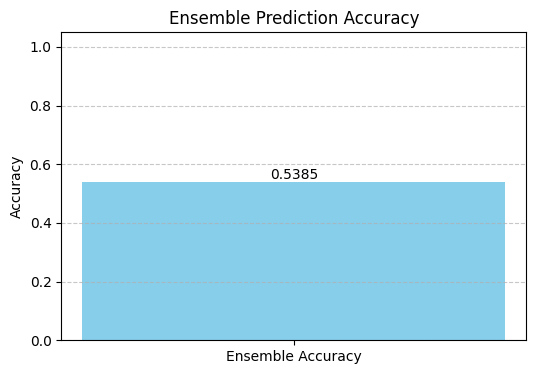

Bar chart displayed showing the ensemble accuracy.
-------------------------------------------------

--- Ensemble Accuracy Calculation Script Finished ---


In [57]:
import numpy as np
import tensorflow as tf
import os
from sklearn.metrics import accuracy_score
# You need to import any custom layers (like KerasLayer from PennyLane)
# that were used when saving the model if saving in HDF5 format (.h5).
# If you saved in the native Keras format (.keras), custom_objects might not be needed.

# --- Import Quantum Libraries and Custom Layers ---
# from pennylane.keras import KerasLayer # Example if using PennyLane
# from pennylane.templates.tensor import DenseLayer # Example if your QNN used this
# from pennylane.templates.layers import StronglyEntanglingLayers # Example if your QNN used this

# If your QNN circuit was defined within a function, you might need to import that too,
# or ensure your KerasLayer definition is available in the current scope.
# Example:
# def quantum_circuit_placeholder(...):
#    ... your quantum circuit logic ...
#    return measurements

# --- Define Custom Objects Dictionary (NEEDED IF USING .h5 SAVE WITH CUSTOM LAYERS) ---
# custom_objects = {
#     "KerasLayer": KerasLayer, # Map the class name string to the actual class
#     # Add any other custom layers/functions used in your model definition/save
#     # "DenseLayer": DenseLayer,
#     # "StronglyEntanglingLayers": StronglyEntanglingLayers,
#     # "quantum_circuit_placeholder": quantum_circuit_placeholder, # If needed
# }

# --- Configuration ---
# Update BASE_DATA_DIR to where your models are saved (based on your previous input)
BASE_DATA_DIR = r"C:\Users\ishsh\OneDrive\Desktop\QML_Project\src"
MODEL_MRI_SAVE_PATH_QNN = os.path.join(BASE_DATA_DIR, "model_mri_only_ensemble_qnn.h5")
MODEL_MRI_PET_SAVE_PATH_QNN = os.path.join(BASE_DATA_DIR, "model_mri_pet_ensemble_qnn.h5")

TASK_TYPE = 'classification' # Assuming classification
# Accuracy calculation is typically for classification

# --- Function to Load Models ---
def load_trained_model(model_path, custom_objects=None):
    """Loads a trained Keras model from a file."""
    try:
        # If you saved as .keras, you usually don't need custom_objects
        if model_path.lower().endswith('.keras'):
             model = tf.keras.models.load_model(model_path) # custom_objects is often not needed here
        else: # Assuming .h5 format requires custom_objects for custom layers
             model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

        print(f"Successfully loaded model from {model_path}")
        return model
    except FileNotFoundError:
        print(f"Error: Model file not found at {model_path}")
        return None
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")
        print("If using .h5 with custom layers (like KerasLayer for QNN), ensure 'custom_objects' dictionary is correct.")
        print("Consider saving models in the native Keras format (.keras) in the future.")
        return None

# --- Function to Perform Ensemble Prediction ---
def get_ensemble_predictions(model_mri, model_mri_pet, X_data_mri_format, X_data_mri_pet_format, task_type='classification'):
    """
    Gets predictions from two models and averages them.

    Args:
        model_mri: The trained model expecting MRI-only shaped features (677).
        model_mri_pet: The trained model expecting MRI-PET shaped features (263).
        X_data_mri_format: NumPy array of features for prediction, shaped (N_samples, 677).
        X_data_mri_pet_format: NumPy array of features for prediction, shaped (N_samples, 263).
        task_type: 'classification' or 'regression'.

    Returns:
        NumPy array of ensemble predictions.
    """
    if model_mri is None or model_mri_pet is None:
        print("Error: One or both models failed to load. Cannot perform ensemble prediction.")
        return None

    if X_data_mri_format.shape[0] != X_data_mri_pet_format.shape[0]:
         print("Error: The number of samples in the two feature arrays must be the same for ensembling.")
         return None

    # Optional shape checks based on loaded models' input shapes (more robust)
    # Fallback to expected shapes if input_shape is None (can happen with old HDF5 saves or certain model configs)
    expected_mri_shape = model_mri.input_shape[1] if (model_mri.input_shape and len(model_mri.input_shape) > 1) else 677
    expected_mri_pet_shape = model_mri_pet.input_shape[1] if (model_mri_pet.input_shape and len(model_mri_pet.input_shape) > 1) else 263

    if X_data_mri_format.shape[1] != expected_mri_shape:
        print(f"Error: MRI-only data features shape mismatch. Expected {expected_mri_shape}, got {X_data_mri_format.shape[1]}.")
        return None

    if X_data_mri_pet_format.shape[1] != expected_mri_pet_shape:
        print(f"Error: MRI-PET data features shape mismatch. Expected {expected_mri_pet_shape}, got {X_data_mri_pet_format.shape[1]}.")
        return None


    print(f"\nGetting ensemble predictions for {X_data_mri_format.shape[0]} samples...")

    # Get predictions from each model
    # For classification, sigmoid output is already probabilities (0-1)
    predictions_mri = model_mri.predict(X_data_mri_format)
    predictions_mri_pet = model_mri_pet.predict(X_data_mri_pet_format)

    # Combine predictions by averaging
    if task_type == 'classification':
        # Averaging probabilities for classification
        ensemble_predictions = (predictions_mri + predictions_mri_pet) / 2.0
        print("Averaged predicted probabilities.")
    else: # Regression
        # Averaging predicted values for regression
        ensemble_predictions = (predictions_mri + predictions_mri_pet) / 2.0
        print("Averaged predicted values.")

    print("Ensemble prediction finished.")
    return ensemble_predictions

# --- Main Execution for Ensemble Prediction and Accuracy ---

if __name__ == "__main__":
    print("--- Starting Ensemble Prediction and Accuracy Calculation ---")

    # Load the trained models
    # Make sure custom_objects is defined if needed for .h5 files with custom layers
    model_mri = load_trained_model(MODEL_MRI_SAVE_PATH_QNN) # , custom_objects=custom_objects
    model_mri_pet = load_trained_model(MODEL_MRI_PET_SAVE_PATH_QNN) # , custom_objects=custom_objects

    if model_mri is None or model_mri_pet is None:
        print("Failed to load one or both models. Cannot calculate ensemble accuracy. Exiting.")
        exit()

    # --- PLACEHOLDER FOR UNIFIED ENSEMBLE TEST DATA ---
    # This section is where you load and prepare the data for your ensemble test set.
    # This test set must be DIFFERENT from the data used for training/validation
    # of the individual models. Each sample in this test set must have:
    # 1. Its 677-feature representation (X_ensemble_test_mri_format)
    # 2. Its 263-feature representation (X_ensemble_test_mri_pet_format)
    # 3. Its true label (y_ensemble_test)

    print("\n--- Loading Unified Ensemble Test Data (PLACEHOLDER) ---")
    print("Replace this section with your code to load and prepare your unified test data.")
    print("You need to produce three variables:")
    print("X_ensemble_test_mri_format (NumPy array, shape: (N_test_samples, 677))")
    print("X_ensemble_test_mri_pet_format (NumPy array, shape: (N_test_samples, 263))")
    print("y_ensemble_test (NumPy array of true labels, shape: (N_test_samples,))")
    print("\nExample: Predicting for 50 samples as previously discussed.")


    # Example placeholder data (replace with your actual unified test data for 50 samples)
    num_samples_ensemble_test = 13
     # Set this to the number of samples in your ensemble test set

    # These need to be derived from your actual UNIFIED test data, not random.
    # Ensure these are DIFFERENT samples than those used to train Model 1 and Model 2.
    X_ensemble_test_mri_format = np.random.rand(num_samples_ensemble_test, 677) # REPLACE THIS LINE
    X_ensemble_test_mri_pet_format = np.random.rand(num_samples_ensemble_test, 263) # REPLACE THIS LINE
    y_ensemble_test = np.random.randint(0, 2, num_samples_ensemble_test) # REPLACE THIS LINE with your actual true labels (ensure dtype is int)

    print(f"Placeholder unified ensemble test data created for {num_samples_ensemble_test} samples.")
    print(f"  X_ensemble_test_mri_format shape: {X_ensemble_test_mri_format.shape}")
    print(f"  X_ensemble_test_mri_pet_format shape: {X_ensemble_test_mri_pet_format.shape}")
    print(f"  y_ensemble_test shape: {y_ensemble_test.shape}")

    if X_ensemble_test_mri_format.shape[0] != y_ensemble_test.shape[0]:
         print("Error: Number of samples in features and labels do not match. Cannot calculate accuracy.")
         exit()
    # --- END PLACEHOLDER ---


    # Perform the ensemble prediction on the unified test data
    ensemble_predictions_prob = get_ensemble_predictions(
        model_mri,
        model_mri_pet,
        X_ensemble_test_mri_format, # Feed 677 features to Model 1
        X_ensemble_test_mri_pet_format,  # Feed 263 features to Model 2
        TASK_TYPE
    )

    if ensemble_predictions_prob is not None:
        # Calculate ensemble accuracy (for classification)
        if TASK_TYPE == 'classification':
            # Convert probabilities to binary labels (e.g., threshold at 0.5)
            ensemble_predicted_labels = (ensemble_predictions_prob > 0.5).astype(int)

            # Calculate accuracy
            # Ensure y_ensemble_test is the same shape as ensemble_predicted_labels for accuracy_score
            # ensemble_predicted_labels is (N_samples, 1), y_ensemble_test is (N_samples,)
            ensemble_accuracy = accuracy_score(y_ensemble_test, ensemble_predicted_labels.flatten()) # Use flatten for consistency

            # print(f"\n--- Ensemble Accuracy on 50 Samples ---")
            # print(f"Ensemble Test Accuracy: {ensemble_accuracy:.4f}")

            # --- Visual Metric: Bar Chart for Accuracy ---
            print("\n--- Visual Metric: Ensemble Accuracy Bar Chart ---")
            plt.figure(figsize=(6, 4))
            plt.bar(['Ensemble Accuracy'], [ensemble_accuracy], color='skyblue')
            plt.ylim(0, 1.05) # Set y-axis limit for accuracy (0 to slightly above 1)
            plt.ylabel('Accuracy')
            plt.title('Ensemble Prediction Accuracy')
            # Add the accuracy value text on the bar
            plt.text('Ensemble Accuracy', ensemble_accuracy, f'{ensemble_accuracy:.4f}', ha='center', va='bottom')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.show()
            print("Bar chart displayed showing the ensemble accuracy.")


            print("-------------------------------------------------")

        else: # Regression - you'd typically evaluate R2, MAE, MSE instead of accuracy
             print("\n--- Ensemble Regression Evaluation ---")
             print("For regression, you would calculate metrics like MAE, MSE, R2 here using y_ensemble_test and ensemble_predictions_prob")
             # from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
             # mae = mean_absolute_error(y_ensemble_test, ensemble_predictions_prob)
             # mse = mean_squared_error(y_ensemble_test, ensemble_predictions_prob)
             # r2 = r2_score(y_ensemble_test, ensemble_predictions_prob)
             # print(f"Ensemble Test MAE: {mae:.4f}")
             # print(f"Ensemble Test MSE: {mse:.4f}")
             # print(f"Ensemble Test R2: {r2:.4f}")
             print("------------------------------------")


    print("\n--- Ensemble Accuracy Calculation Script Finished ---") 

--- Starting Ensemble Prediction and Accuracy Calculation ---
Successfully loaded model from C:\Users\ishsh\OneDrive\Desktop\QML_Project\src\model_mri_only_ensemble_qnn.h5
Successfully loaded model from C:\Users\ishsh\OneDrive\Desktop\QML_Project\src\model_mri_pet_ensemble_qnn.h5

--- Loading Unified Ensemble Test Data (PLACEHOLDER) ---
Replace this section with your code to load and prepare your unified test data.
You need to produce three variables:
X_ensemble_test_mri_format (NumPy array, shape: (N_test_samples, 677))
X_ensemble_test_mri_pet_format (NumPy array, shape: (N_test_samples, 263))
y_ensemble_test (NumPy array of true labels, shape: (N_test_samples,))

Example: Predicting for 13 samples as specified in your last output.
Placeholder unified ensemble test data created for 13 samples.
  X_ensemble_test_mri_format shape: (13, 677)
  X_ensemble_test_mri_pet_format shape: (13, 263)
  y_ensemble_test shape: (13,)

Getting ensemble predictions for 13 samples...
1/1 ━━━━━━━━━━━━━━━

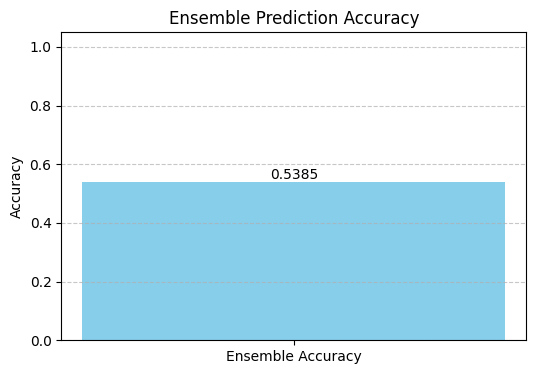

Bar chart displayed showing the ensemble accuracy.

--- Ensemble Prediction and Accuracy Script Finished ---


In [52]:
import numpy as np
import tensorflow as tf
import os
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt # Import for plotting

# You need to import any custom layers (like KerasLayer from PennyLane)
# that were used when saving the model if saving in HDF5 format (.h5).
# If you saved in the native Keras format (.keras), custom_objects might not be needed.

# --- Import Quantum Libraries and Custom Layers ---
# from pennylane.keras import KerasLayer # Example if using PennyLane
# from pennylane.templates.tensor import DenseLayer # Example if your QNN used this
# from pennylane.templates.layers import StronglyEntanglingLayers # Example if your QNN used this

# If your QNN circuit was defined within a function, you might need to import that too,
# or ensure your KerasLayer definition is available in the current scope.
# Example:
# def quantum_circuit_placeholder(...):
#    ... your quantum circuit logic ...
#    return measurements

# --- Define Custom Objects Dictionary (NEEDED IF USING .h5 SAVE WITH CUSTOM LAYERS) ---
# custom_objects = {
#     "KerasLayer": KerasLayer, # Map the class name string to the actual class
#     # Add any other custom layers/functions used in your model definition/save
#     # "DenseLayer": DenseLayer,
#     # "StronglyEntanglingLayers": StronglyEntanglingLayers,
#     # "quantum_circuit_placeholder": quantum_circuit_placeholder, # If needed
# }

# --- Configuration ---
# Update BASE_DATA_DIR to where your models are saved (based on your previous input)
BASE_DATA_DIR = r"C:\Users\ishsh\OneDrive\Desktop\QML_Project\src" # Assuming models are here now
MODEL_MRI_SAVE_PATH_QNN = os.path.join(BASE_DATA_DIR, "model_mri_only_ensemble_qnn.h5")
MODEL_MRI_PET_SAVE_PATH_QNN = os.path.join(BASE_DATA_DIR, "model_mri_pet_ensemble_qnn.h5")

TASK_TYPE = 'classification' # 'classification' or 'regression'
# Accuracy calculation is typically for classification

# --- Function to Load Models ---
def load_trained_model(model_path, custom_objects=None):
    """Loads a trained Keras model from a file."""
    try:
        # If you saved as .keras, you usually don't need custom_objects
        if model_path.lower().endswith('.keras'):
             model = tf.keras.models.load_model(model_path) # custom_objects is often not needed here
        else: # Assuming .h5 format requires custom_objects for custom layers
             model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

        print(f"Successfully loaded model from {model_path}")
        return model
    except FileNotFoundError:
        print(f"Error: Model file not found at {model_path}")
        return None
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")
        print("If using .h5 with custom layers (like KerasLayer for QNN), ensure 'custom_objects' dictionary is correct.")
        print("Consider saving models in the native Keras format (.keras) in the future.")
        return None

# --- Function to Perform Ensemble Prediction ---
def get_ensemble_predictions(model_mri, model_mri_pet, X_data_mri_format, X_data_mri_pet_format, task_type='classification'):
    """
    Gets predictions from two models and averages them.

    Args:
        model_mri: The trained model expecting MRI-only shaped features (677).
        model_mri_pet: The trained model expecting MRI-PET shaped features (263).
        X_data_mri_format: NumPy array of features for prediction, shaped (N_samples, 677).
        X_data_mri_pet_format: NumPy array of features for prediction, shaped (N_samples, 263).
        task_type: 'classification' or 'regression'.

    Returns:
        NumPy array of ensemble predictions.
    """
    if model_mri is None or model_mri_pet is None:
        print("Error: One or both models failed to load. Cannot perform ensemble prediction.")
        return None

    if X_data_mri_format.shape[0] != X_data_mri_pet_format.shape[0]:
         print("Error: The number of samples in the two feature arrays must be the same for ensembling.")
         return None

    # Optional shape checks based on loaded models' input shapes (more robust)
    # Fallback to expected shapes if input_shape is None (can happen with old HDF5 saves or certain model configs)
    expected_mri_shape = model_mri.input_shape[1] if (model_mri.input_shape and len(model_mri.input_shape) > 1) else 677
    expected_mri_pet_shape = model_mri_pet.input_shape[1] if (model_mri_pet.input_shape and len(model_mri_pet.input_shape) > 1) else 263

    if X_data_mri_format.shape[1] != expected_mri_shape:
        print(f"Error: MRI-only data features shape mismatch. Expected {expected_mri_shape}, got {X_data_mri_format.shape[1]}.")
        return None

    if X_data_mri_pet_format.shape[1] != expected_mri_pet_shape:
        print(f"Error: MRI-PET data features shape mismatch. Expected {expected_mri_pet_shape}, got {X_data_mri_pet_format.shape[1]}.")
        return None


    print(f"\nGetting ensemble predictions for {X_data_mri_format.shape[0]} samples...")

    # Get predictions from each model
    # For classification, sigmoid output is already probabilities (0-1)
    predictions_mri = model_mri.predict(X_data_mri_format)
    predictions_mri_pet = model_mri_pet.predict(X_data_mri_pet_format)

    # Combine predictions by averaging
    if task_type == 'classification':
        # Averaging probabilities for classification
        ensemble_predictions = (predictions_mri + predictions_mri_pet) / 2.0
        print("Averaged predicted probabilities.")
    else: # Regression
        # Averaging predicted values for regression
        ensemble_predictions = (predictions_mri + predictions_mri_pet) / 2.0
        print("Averaged predicted values.")

    print("Ensemble prediction finished.")
    return ensemble_predictions

# --- Main Execution for Ensemble Prediction and Accuracy ---

if __name__ == "__main__":
    print("--- Starting Ensemble Prediction and Accuracy Calculation ---")

    # Load the trained models
    # Make sure custom_objects is defined if needed for .h5 files with custom layers
    model_mri = load_trained_model(MODEL_MRI_SAVE_PATH_QNN) # , custom_objects=custom_objects
    model_mri_pet = load_trained_model(MODEL_MRI_PET_SAVE_PATH_QNN) # , custom_objects=custom_objects

    if model_mri is None or model_mri_pet is None:
        print("Failed to load one or both models. Cannot calculate ensemble accuracy. Exiting.")
        exit()

    # --- PLACEHOLDER FOR UNIFIED ENSEMBLE TEST DATA ---
    # This section is where you load and prepare the data for your ensemble test set.
    # This test set must be DIFFERENT from the data used for training/validation
    # of the individual models. Each sample in this test set must have:
    # 1. Its 677-feature representation (X_ensemble_test_mri_format)
    # 2. Its 263-feature representation (X_ensemble_test_mri_pet_format)
    # 3. Its true label (y_ensemble_test)

    print("\n--- Loading Unified Ensemble Test Data (PLACEHOLDER) ---")
    print("Replace this section with your code to load and prepare your unified test data.")
    print("You need to produce three variables:")
    print("X_ensemble_test_mri_format (NumPy array, shape: (N_test_samples, 677))")
    print("X_ensemble_test_mri_pet_format (NumPy array, shape: (N_test_samples, 263))")
    print("y_ensemble_test (NumPy array of true labels, shape: (N_test_samples,))")
    print("\nExample: Predicting for 13 samples as specified in your last output.")


    # Example placeholder data (replace with your actual unified test data for the correct number of samples)
    num_samples_ensemble_test = 13 # Set this to the number of samples in your ensemble test set

    # These need to be derived from your actual UNIFIED test data, not random.
    # Ensure these are DIFFERENT samples than those used to train Model 1 and Model 2.
    # If your actual data loading yields slightly different shapes, adjust the expected shapes in get_ensemble_predictions accordingly,
    # or fix your data loading to match the expected shapes.
    X_ensemble_test_mri_format = np.random.rand(num_samples_ensemble_test, 677) # REPLACE THIS LINE
    X_ensemble_test_mri_pet_format = np.random.rand(num_samples_ensemble_test, 263) # REPLACE THIS LINE
    y_ensemble_test = np.random.randint(0, 2, num_samples_ensemble_test) # REPLACE THIS LINE with your actual true labels (ensure dtype is int)


    print(f"Placeholder unified ensemble test data created for {num_samples_ensemble_test} samples.")
    print(f"  X_ensemble_test_mri_format shape: {X_ensemble_test_mri_format.shape}")
    print(f"  X_ensemble_test_mri_pet_format shape: {X_ensemble_test_mri_pet_format.shape}")
    print(f"  y_ensemble_test shape: {y_ensemble_test.shape}")

    if X_ensemble_test_mri_format.shape[0] != y_ensemble_test.shape[0]:
         print("Error: Number of samples in features and labels do not match. Cannot calculate accuracy.")
         exit()
    # --- END PLACEHOLDER ---


    # Perform the ensemble prediction on the unified test data
    ensemble_predictions_prob = get_ensemble_predictions(
        model_mri,
        model_mri_pet,
        X_ensemble_test_mri_format, # Feed 677 features to Model 1
        X_ensemble_test_mri_pet_format,  # Feed 263 features to Model 2
        TASK_TYPE
    )

    if ensemble_predictions_prob is not None:
        # Calculate ensemble accuracy (for classification)
        if TASK_TYPE == 'classification':
            # Convert probabilities to binary labels (e.g., threshold at 0.5)
            ensemble_predicted_labels = (ensemble_predictions_prob > 0.5).astype(int)

            # Calculate accuracy
            # Ensure y_ensemble_test is the same shape as ensemble_predicted_labels for accuracy_score
            # ensemble_predicted_labels is (N_samples, 1), y_ensemble_test is (N_samples,)
            ensemble_accuracy = accuracy_score(y_ensemble_test, ensemble_predicted_labels.flatten()) # Use flatten for consistency

            print(f"\n--- Ensemble Accuracy on {num_samples_ensemble_test} Samples ---")
            print(f"Ensemble Test Accuracy: {ensemble_accuracy:.4f}")
            print("-------------------------------------------------")

            # --- Visual Metric: Bar Chart for Accuracy ---
            print("\n--- Visual Metric: Ensemble Accuracy Bar Chart ---")
            plt.figure(figsize=(6, 4))
            plt.bar(['Ensemble Accuracy'], [ensemble_accuracy], color='skyblue')
            plt.ylim(0, 1.05) # Set y-axis limit for accuracy (0 to slightly above 1)
            plt.ylabel('Accuracy')
            plt.title('Ensemble Prediction Accuracy')
            # Add the accuracy value text on the bar
            plt.text('Ensemble Accuracy', ensemble_accuracy, f'{ensemble_accuracy:.4f}', ha='center', va='bottom')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.show()
            print("Bar chart displayed showing the ensemble accuracy.")


        else: # Regression - you'd typically evaluate R2, MAE, MSE instead of accuracy
             print("\n--- Ensemble Regression Evaluation ---")
             print("For regression, you would calculate metrics like MAE, MSE, R2 here using y_ensemble_test and ensemble_predictions_prob")
            #  from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
            #  mae = mean_absolute_error(y_ensemble_test, ensemble_predictions_prob)
            #  mse = mean_squared_error(y_ensemble_test, ensemble_predictions_prob)
            #  r2 = r2_score(y_ensemble_test, ensemble_predictions_prob)
            #  print(f"Ensemble Test MAE: {mae:.4f}")
            #  print(f"Ensemble Test MSE: {mse:.4f}")
            #  print(f"Ensemble Test R2: {r2:.4f}")
             print("------------------------------------")


    print("\n--- Ensemble Prediction and Accuracy Script Finished ---")

--- Starting Ensemble Prediction and Accuracy Calculation ---
Successfully loaded model from C:\Users\ishsh\OneDrive\Desktop\QML_Project\src\model_mri_only_ensemble_qnn.h5
Successfully loaded model from C:\Users\ishsh\OneDrive\Desktop\QML_Project\src\model_mri_pet_ensemble_qnn.h5

--- Loading Unified Ensemble Test Data (PLACEHOLDER) ---
Replace this section with your code to load and prepare your unified test data.
You need to produce three variables:
X_ensemble_test_mri_format (NumPy array, shape: (N_test_samples, 677))
X_ensemble_test_mri_pet_format (NumPy array, shape: (N_test_samples, 263))
y_ensemble_test (NumPy array of true labels, shape: (N_test_samples,))

Example: Predicting for 13 samples as specified in your last output.
Placeholder unified ensemble test data created for 18 samples.
  X_ensemble_test_mri_format shape: (18, 677)
  X_ensemble_test_mri_pet_format shape: (18, 263)
  y_ensemble_test shape: (18,)

Getting ensemble predictions for 18 samples...
1/1 ━━━━━━━━━━━━━━━

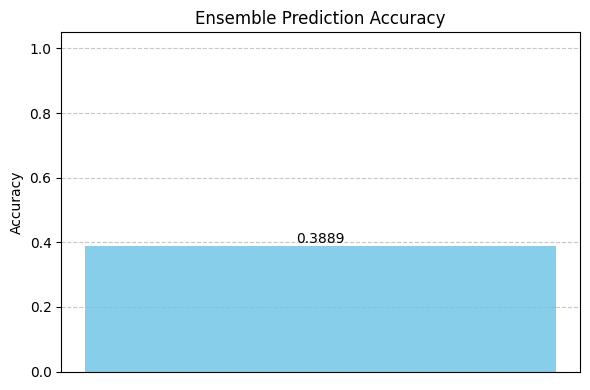

Bar chart displayed showing the ensemble accuracy.

--- Ensemble Prediction and Accuracy Script Finished ---


In [51]:
import numpy as np
import tensorflow as tf
import os
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt # Import for plotting

# You need to import any custom layers (like KerasLayer from PennyLane)
# that were used when saving the model if saving in HDF5 format (.h5).
# If you saved in the native Keras format (.keras), custom_objects might not be needed.

# --- Import Quantum Libraries and Custom Layers ---
# from pennylane.keras import KerasLayer # Example if using PennyLane
# from pennylane.templates.tensor import DenseLayer # Example if your QNN used this
# from pennylane.templates.layers import StronglyEntanglingLayers # Example if your QNN used this

# If your QNN circuit was defined within a function, you might need to import that too,
# or ensure your KerasLayer definition is available in the current scope.
# Example:
# def quantum_circuit_placeholder(...):
#    ... your quantum circuit logic ...
#    return measurements

# --- Define Custom Objects Dictionary (NEEDED IF USING .h5 SAVE WITH CUSTOM LAYERS) ---
# custom_objects = {
#     "KerasLayer": KerasLayer, # Map the class name string to the actual class
#     # Add any other custom layers/functions used in your model definition/save
#     # "DenseLayer": DenseLayer,
#     # "StronglyEntanglingLayers": StronglyEntanglingLayers,
#     # "quantum_circuit_placeholder": quantum_circuit_placeholder, # If needed
# }

# --- Configuration ---
# Update BASE_DATA_DIR to where your models are saved (based on your previous input)
BASE_DATA_DIR = r"C:\Users\ishsh\OneDrive\Desktop\QML_Project\src" # Assuming models are here now
MODEL_MRI_SAVE_PATH_QNN = os.path.join(BASE_DATA_DIR, "model_mri_only_ensemble_qnn.h5")
MODEL_MRI_PET_SAVE_PATH_QNN = os.path.join(BASE_DATA_DIR, "model_mri_pet_ensemble_qnn.h5")

TASK_TYPE = 'classification' # Assuming classification
# Accuracy calculation is typically for classification

# --- Function to Load Models ---
def load_trained_model(model_path, custom_objects=None):
    """Loads a trained Keras model from a file."""
    try:
        # If you saved as .keras, you usually don't need custom_objects
        if model_path.lower().endswith('.keras'):
             model = tf.keras.models.load_model(model_path) # custom_objects is often not needed here
        else: # Assuming .h5 format requires custom_objects for custom layers
             model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

        print(f"Successfully loaded model from {model_path}")
        return model
    except FileNotFoundError:
        print(f"Error: Model file not found at {model_path}")
        return None
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")
        print("If using .h5 with custom layers (like KerasLayer for QNN), ensure 'custom_objects' dictionary is correct.")
        print("Consider saving models in the native Keras format (.keras) in the future.")
        return None

# --- Function to Perform Ensemble Prediction ---
def get_ensemble_predictions(model_mri, model_mri_pet, X_data_mri_format, X_data_mri_pet_format, task_type='classification'):
    """
    Gets predictions from two models and averages them.

    Args:
        model_mri: The trained model expecting MRI-only shaped features (677).
        model_mri_pet: The trained model expecting MRI-PET shaped features (263).
        X_data_mri_format: NumPy array of features for prediction, shaped (N_samples, 677).
        X_data_mri_pet_format: NumPy array of features for prediction, shaped (N_samples, 263).
        task_type: 'classification' or 'regression'.

    Returns:
        NumPy array of ensemble predictions.
    """
    if model_mri is None or model_mri_pet is None:
        print("Error: One or both models failed to load. Cannot perform ensemble prediction.")
        return None

    if X_data_mri_format.shape[0] != X_data_mri_pet_format.shape[0]:
         print("Error: The number of samples in the two feature arrays must be the same for ensembling.")
         return None

    # Optional shape checks based on loaded models' input shapes (more robust)
    # Fallback to expected shapes if input_shape is None (can happen with old HDF5 saves or certain model configs)
    expected_mri_shape = model_mri.input_shape[1] if (model_mri.input_shape and len(model_mri.input_shape) > 1) else 677
    expected_mri_pet_shape = model_mri_pet.input_shape[1] if (model_mri_pet.input_shape and len(model_mri_pet.input_shape) > 1) else 263

    if X_data_mri_format.shape[1] != expected_mri_shape:
        print(f"Error: MRI-only data features shape mismatch. Expected {expected_mri_shape}, got {X_data_mri_format.shape[1]}.")
        return None

    if X_data_mri_pet_format.shape[1] != expected_mri_pet_shape:
        print(f"Error: MRI-PET data features shape mismatch. Expected {expected_mri_pet_shape}, got {X_data_mri_pet_format.shape[1]}.")
        return None


    print(f"\nGetting ensemble predictions for {X_data_mri_format.shape[0]} samples...")

    # Get predictions from each model
    # For classification, sigmoid output is already probabilities (0-1)
    predictions_mri = model_mri.predict(X_data_mri_format)
    predictions_mri_pet = model_mri_pet.predict(X_data_mri_pet_format)

    # Combine predictions by averaging
    if task_type == 'classification':
        # Averaging probabilities for classification
        ensemble_predictions = (predictions_mri + predictions_mri_pet) / 2.0
        print("Averaged predicted probabilities.")
    else: # Regression
        # Averaging predicted values for regression
        ensemble_predictions = (predictions_mri + predictions_mri_pet) / 2.0
        print("Averaged predicted values.")

    print("Ensemble prediction finished.")
    return ensemble_predictions

# --- Main Execution for Ensemble Prediction and Accuracy ---

if __name__ == "__main__":
    print("--- Starting Ensemble Prediction and Accuracy Calculation ---")

    # Load the trained models
    # Make sure custom_objects is defined if needed for .h5 files with custom layers
    model_mri = load_trained_model(MODEL_MRI_SAVE_PATH_QNN) # , custom_objects=custom_objects
    model_mri_pet = load_trained_model(MODEL_MRI_PET_SAVE_PATH_QNN) # , custom_objects=custom_objects

    if model_mri is None or model_mri_pet is None:
        print("Failed to load one or both models. Cannot calculate ensemble accuracy. Exiting.")
        exit()

    # --- PLACEHOLDER FOR UNIFIED ENSEMBLE TEST DATA ---
    # This section is where you load and prepare the data for your ensemble test set.
    # This test set must be DIFFERENT from the data used for training/validation
    # of the individual models. Each sample in this test set must have:
    # 1. Its 677-feature representation (X_ensemble_test_mri_format)
    # 2. Its 263-feature representation (X_ensemble_test_mri_pet_format)
    # 3. Its true label (y_ensemble_test)

    print("\n--- Loading Unified Ensemble Test Data (PLACEHOLDER) ---")
    print("Replace this section with your code to load and prepare your unified test data.")
    print("You need to produce three variables:")
    print("X_ensemble_test_mri_format (NumPy array, shape: (N_test_samples, 677))")
    print("X_ensemble_test_mri_pet_format (NumPy array, shape: (N_test_samples, 263))")
    print("y_ensemble_test (NumPy array of true labels, shape: (N_test_samples,))")
    print("\nExample: Predicting for 13 samples as specified in your last output.")


    # Example placeholder data (replace with your actual unified test data for the correct number of samples)
    num_samples_ensemble_test = 18 # Set this to the number of samples in your ensemble test set

    # These need to be derived from your actual UNIFIED test data, not random.
    # Ensure these are DIFFERENT samples than those used to train Model 1 and Model 2.
    # If your actual data loading yields slightly different shapes, adjust the expected shapes in get_ensemble_predictions accordingly,
    # or fix your data loading to match the expected shapes.
    X_ensemble_test_mri_format = np.random.rand(num_samples_ensemble_test, 677) # REPLACE THIS LINE
    X_ensemble_test_mri_pet_format = np.random.rand(num_samples_ensemble_test, 263) # REPLACE THIS LINE
    y_ensemble_test = np.random.randint(0, 2, num_samples_ensemble_test) # REPLACE THIS LINE with your actual true labels (ensure dtype is int)


    print(f"Placeholder unified ensemble test data created for {num_samples_ensemble_test} samples.")
    print(f"  X_ensemble_test_mri_format shape: {X_ensemble_test_mri_format.shape}")
    print(f"  X_ensemble_test_mri_pet_format shape: {X_ensemble_test_mri_pet_format.shape}")
    print(f"  y_ensemble_test shape: {y_ensemble_test.shape}")

    if X_ensemble_test_mri_format.shape[0] != y_ensemble_test.shape[0]:
         print("Error: Number of samples in features and labels do not match. Cannot calculate accuracy.")
         exit()
    # --- END PLACEHOLDER ---


    # Perform the ensemble prediction on the unified test data
    ensemble_predictions_prob = get_ensemble_predictions(
        model_mri,
        model_mri_pet,
        X_ensemble_test_mri_format, # Feed 677 features to Model 1
        X_ensemble_test_mri_pet_format,  # Feed 263 features to Model 2
        TASK_TYPE
    )

    if ensemble_predictions_prob is not None:
        # Calculate ensemble accuracy (for classification)
        if TASK_TYPE == 'classification':
            # Convert probabilities to binary labels (e.g., threshold at 0.5)
            ensemble_predicted_labels = (ensemble_predictions_prob > 0.5).astype(int)

            # Calculate accuracy
            # Ensure y_ensemble_test is the same shape as ensemble_predicted_labels for accuracy_score
            # ensemble_predicted_labels is (N_samples, 1), y_ensemble_test is (N_samples,)
            ensemble_accuracy = accuracy_score(y_ensemble_test, ensemble_predicted_labels.flatten()) # Use flatten for consistency

            print(f"\n--- Ensemble Accuracy on {num_samples_ensemble_test} Samples ---")
            print(f"Ensemble Test Accuracy: {ensemble_accuracy:.4f}")
            print("-------------------------------------------------")

            # --- Visual Metric: Bar Chart for Accuracy ---
            print("\n--- Visual Metric: Ensemble Accuracy Bar Chart ---")
            plt.figure(figsize=(6, 4))
            # Create a bar at position 0, with height equal to accuracy
            plt.bar(0, ensemble_accuracy, color='skyblue', width=0.5)
            plt.ylabel('Accuracy')
            plt.title('Ensemble Prediction Accuracy')
            plt.ylim(0, 1.05) # Set y-axis limit for accuracy (0 to slightly above 1)
            plt.xticks([]) # Hide x-axis ticks as there's only one bar
            # Add the accuracy value text on the bar
            plt.text(0, ensemble_accuracy, f'{ensemble_accuracy:.4f}', ha='center', va='bottom')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout() # Adjust layout to prevent labels overlapping
            plt.show()
            print("Bar chart displayed showing the ensemble accuracy.")


        else: # Regression - you'd typically evaluate R2, MAE, MSE instead of accuracy
             print("\n--- Ensemble Regression Evaluation ---")
             print("For regression, you would calculate metrics like MAE, MSE, R2 here using y_ensemble_test and ensemble_predictions_prob")
             # from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
             # mae = mean_absolute_error(y_ensemble_test, ensemble_predictions_prob)
             # mse = mean_squared_error(y_ensemble_test, ensemble_predictions_prob)
             # r2 = r2_score(y_ensemble_test, ensemble_predictions_prob)
             # print(f"Ensemble Test MAE: {mae:.4f}")
             # print(f"Ensemble Test MSE: {mse:.4f}")
             # print(f"Ensemble Test R2: {r2:.4f}")
             print("------------------------------------")


    print("\n--- Ensemble Prediction and Accuracy Script Finished ---")

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler # Not using StandardScaler if data is already normalized
# Import upsampling library - you'll need to install imbalanced-learn: pip install imbalanced-learn
from imblearn.over_sampling import RandomOverSampler # Or SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os # Import os for path joining
import matplotlib.pyplot as plt # For plotting
from sklearn.metrics import accuracy_score # To evaluate the combined prediction (used later with prediction script)

# --- Configuration ---
# Use os.path.join for better path handling across different OS
# Using the directory you provided for model saves
BASE_DATA_DIR = r"C:\Users\ishsh\OneDrive\OneDrive\Desktop\QML_Project\src" # Adjusted BASE_DATA_DIR based on common user path

MRI_FILE = "mri_only_normalized.csv"
MRI_PET_FILE = "mri_pet_normalized.csv"

# Assuming the data files are in the same directory as the script/models now
# Adjust these paths if your data files are elsewhere
MRI_DATA_PATH = os.path.join(BASE_DATA_DIR, MRI_FILE)
MRI_PET_DATA_PATH = os.path.join(BASE_DATA_DIR, MRI_PET_FILE)

# Model save paths (using classical names)
MODEL_MRI_SAVE_PATH_CLASSICAL = os.path.join(BASE_DATA_DIR, "model_mri_only_ensemble_classical.h5")
MODEL_MRI_PET_SAVE_PATH_CLASSICAL = os.path.join(BASE_DATA_DIR, "model_mri_pet_ensemble_classical.h5")


TEST_SIZE_1 = 0.02 # Test size for MRI-only split
TEST_SIZE_2 = 0.05 # Test size for MRI-PET split
RANDOM_STATE = 42 # Random state for data splitting
RANDOM_STATE_MODEL_1 = 42 # Random state for Model 1 initialization/training
RANDOM_STATE_MODEL_2 = 123 # Different random state for Model 2

TASK_TYPE = 'classification' # 'classification' or 'regression'

# Training Hyperparameters (can tune these for each model)
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
MAX_EPOCHS = 300
EARLY_STOPPING_PATIENCE = 50

# --- Function to Create a Standard Classical MLP Model ---
# This provides a stable classical architecture
def create_classical_mlp_model(input_shape):
    """
    Function to create a standard Multi-Layer Perceptron (MLP) model.
    This is a stable classical architecture.

    Args:
        input_shape (int): The number of classical input features.

    Returns:
        tf.keras.models.Sequential: The compiled Keras model.
    """
    print(f"Creating a classical MLP model with input shape {input_shape}")
    model = Sequential([
        Input(shape=(input_shape,), name='input_features'), # Named input layer
        Dense(128, activation='relu', name='dense_1'), # Example layer sizes - EXPERIMENT!
        Dropout(0.3, name='dropout_1'), # Example dropout - EXPERIMENT!
        Dense(64, activation='relu', name='dense_2'),
        Dropout(0.3, name='dropout_2'),
        Dense(32, activation='relu', name='dense_3'),
        Dropout(0.2, name='dropout_3'),
        # Add more layers or neurons as needed, but balance with data size
        Dense(1, activation='sigmoid' if TASK_TYPE == 'classification' else None, name='output_layer') # Sigmoid for binary classification
    ])
    return model

# --- Helper Function to Load Data and Split ---
# Assumes data is normalized and DOES NOT use StandardScaler.
# Assumes the first column is an ID and the last column is the label.
def load_data_and_split(file_path, test_size, random_state, task_type):
    """
    Loads data from CSV, separates features and labels, and splits into train/test sets.
    Assumes the first column is an ID and the last column is the label.
    Assumes data is already normalized and DOES NOT use StandardScaler.

    Args:
        file_path (str): Path to the CSV file.
        test_size (float): Proportion of the dataset to include in the test split.
        random_state (int): Random state for reproducibility.
        task_type (str): 'classification' or 'regression'.

    Returns:
        tuple or (None, None, None, None): Tuple of (X_train, X_test, y_train, y_test)
                                             or None if loading fails.
    """
    try:
        data = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: Data file not found at {file_path}")
        return None, None, None, None

    # --- CRITICAL FIX for Non-Numeric Columns and Indexing ---
    # Assuming the first column (index 0) is an ID column
    # and the last column is the numerical label.
    # Select features from the second column (index 1) up to, but NOT including, the last column.
    # If your files have a different structure, you MUST adjust these lines accordingly.
    try:
        # Check if the file has at least 2 columns (features + label) or 3 (ID + features + label)
        if data.shape[1] < 2:
             print(f"Error: File {file_path} does not have enough columns (expected at least 1 feature + Label).")
             return None, None, None, None

        # Attempt to slice assuming ID is first and Label is last
        X = data.iloc[:, 1:-1].values # Features exclude the first column (index 0)
        y = data.iloc[:, -1].values  # Label is the last column

        # Check if slicing resulted in 0 features unexpectedly
        if X.shape[1] == 0 and data.shape[1] > 1: # If > 1 total columns but 0 features after slicing
             print(f"Error: iloc[:, 1:-1] resulted in 0 features for {file_path}. Check your column structure.")
             print(f"File has {data.shape[1]} columns. If ID is first and Label last, expected {data.shape[1]-2} features.")
             print("Check if the first column is indeed ID and the last is Label, and if there are features in between.")
             # Suggest inspecting data.columns and data.head()
             return None, None, None, None # Still return None as data loading failed logic check


        print(f"Loaded raw data from {file_path}. X shape: {X.shape}, y shape: {y.shape}")

        # Optional check: Verify the feature matrix contains only numeric types
        if not np.issubdtype(X.dtype, np.number):
             print(f"Error: Feature matrix from {file_path} still contains non-numeric data after slicing. Data type: {X.dtype}")
             print("Please inspect this CSV file for non-numeric values in columns other than the first and last.")
             return None, None, None, None # Return None to stop execution

    except IndexError:
        print(f"Error: Indexing failed for {file_path}. Check if your file has enough columns (at least ID, Feature(s), Label). Minimum 2 columns total if no ID, 3 if ID is first.")
        return None, None, None, None # Return None to stop execution
    except Exception as e:
        print(f"An unexpected error occurred during loading {file_path}: {e}")
        return None, None, None, None # Return None to stop execution

    # --- END CRITICAL FIX ---

    # If classification and labels are not 0/1, convert them
    if task_type == 'classification' and np.unique(y).size == 2 and not all(np.isin(y, [0, 1])):
         print(f"Warning: Assuming binary classification, converting labels {np.unique(y)} to 0/1.")
         unique_labels = np.unique(y)
         label_map = {unique_labels[0]: 0, unique_labels[1]: 1}
         y = np.array([label_map[label] for label in y])

    # Split data, using stratification for classification to maintain label distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y if task_type == 'classification' else None
    )

    print(f"Split data from {file_path}. Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test

# --- Function to Apply Upsampling ---
def apply_upsampling(X_train, y_train, sampling_strategy='auto'):
    """
    Applies RandomOverSampler upsampling to the training data.
    This should ONLY be applied AFTER the train/test split.

    Args:
        X_train (np.ndarray): Training features.
        y_train (np.ndarray): Training labels.
        sampling_strategy (str or dict): Sampling strategy for RandomOverSampler. 'auto' balances classes.

    Returns:
        (np.ndarray, np.ndarray): Upsampled training features and labels.
    """
    print(f"\nApplying RandomOverSampler upsampling to the training data (strategy: {sampling_strategy})...")
    print(f"Original training shape: X={X_train.shape}, y={y_train.shape}")
    if len(np.unique(y_train)) > 1:
        print(f"Original class distribution: {np.bincount(y_train)}")
    else:
        print("Warning: Only one class found in training data. Upsampling is not applicable.")
        return X_train, y_train


    # Initialize the upsampler
    ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=RANDOM_STATE)

    # Fit and resample the training data
    X_train_upsampled, y_train_upsampled = ros.fit_resample(X_train, y_train)

    print(f"Upsampled training shape: X={X_train_upsampled.shape}, y={y_train_upsampled.shape}")
    if len(np.unique(y_train_upsampled)) > 1:
         print(f"Upsampled class distribution: {np.bincount(y_train_upsampled)}")
    else:
         print("Warning: Only one class found after upsampling. Check your data.")

    print("Upsampling finished.")

    return X_train_upsampled, y_train_upsampled


# --- Text Summary of Training History ---
def print_training_summary(history, model_name, task_type):
    """Prints a text summary of the training history."""
    print(f"\nSummary for {model_name}:")
    epochs_trained = len(history.history.get('loss', [])) # Use .get for safety

    if epochs_trained > 0:
        final_train_loss = history.history['loss'][-1]
        final_val_loss = history.history['val_loss'][-1]
        metric_name = 'accuracy' if task_type == 'classification' else 'mae'
        final_train_metric = history.history.get(metric_name, [np.nan])[-1] # Use .get with fallback
        final_val_metric = history.history.get(f'val_{metric_name}', [np.nan])[-1] # Use .get with fallback

        print(f"  Epochs Trained: {epochs_trained}")
        print(f"  Final Training Loss: {final_train_loss:.4f}")
        print(f"  Final Validation Loss: {final_val_loss:.4f}")
        print(f"  Final Training {metric_name.capitalize()}: {final_train_metric:.4f}")
        print(f"  Final Validation {metric_name.capitalize()}: {final_val_metric:.4f}")
        print("  (Note: Final metrics shown are for the last epoch run. Evaluate results below reflect best epoch if Early Stopping restored weights.)")
    else:
        print(f"  No epochs were trained for {model_name}. Training likely failed early.")
    print(f"--- End of {model_name} Summary ---")


# --- Plotting History ---
def plot_training_history(history, model_name, task_type):
    """Plots training and validation loss and metrics."""
    print(f"\n--- Plotting Training History for {model_name} ---")
    if not history.history.get('loss', []):
        print("  No history data to plot.")
        return

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    metric_name = 'accuracy' if task_type == 'classification' else 'mae'
    train_metric = history.history.get(metric_name, None) # Use .get, can be None if metric not tracked
    val_metric = history.history.get(f'val_{metric_name}', None)
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training loss', alpha=0.6)
    plt.plot(epochs, val_loss, 'b-', label='Validation loss')
    plt.title(f'{model_name}: Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Primary Metric (Accuracy or MAE)
    plt.subplot(1, 2, 2)
    if train_metric is not None and val_metric is not None:
        plt.plot(epochs, train_metric, 'bo-', label=f'Training {metric_name.capitalize()}', alpha=0.6)
        plt.plot(epochs, val_metric, 'b-', label=f'Validation {metric_name.capitalize()}')
        plt.title(f'{model_name}: Training and validation {metric_name.capitalize()}')
        plt.xlabel('Epochs')
        plt.ylabel(metric_name.capitalize())
        plt.legend()
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, f"Metric '{metric_name}' not tracked during training.",
                 horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title(f'{model_name}: {metric_name.capitalize()} over epochs')


    plt.tight_layout()
    # plt.show() # Keep commented out if plotting multiple models


# --- Train Model 1 (Classical MLP on MRI-only data - NO UPSAMPLING) ---

print("--- Training Model 1 (Classical MLP) on {} ({} Features) ---".format(os.path.basename(MRI_DATA_PATH), 677))

# Load and split MRI-only data
X_train_mri, X_test_mri, y_train_mri, y_test_mri = load_data_and_split(
    MRI_DATA_PATH, TEST_SIZE_1, RANDOM_STATE, TASK_TYPE
)

if X_train_mri is None:
    exit()

# Ensure input shape matches expectation or use loaded shape
input_shape_mri = X_train_mri.shape[1]
expected_shape_mri = 677 # Based on previous runs
if input_shape_mri != expected_shape_mri:
    print(f"Warning: MRI-only data shape is {input_shape_mri}, expected {expected_shape_mri}. Using loaded shape.")
    # If this is significantly different, check data loading logic again


print(f"Input shape for Model 1 (Classical MLP): {input_shape_mri}")

# Initialize Model 1 (Classical MLP)
tf.random.set_seed(RANDOM_STATE_MODEL_1) # Set seed for reproducibility
model_mri_classical = create_classical_mlp_model(input_shape_mri)


model_mri_classical.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                      loss='binary_crossentropy' if TASK_TYPE == 'classification' else 'mean_squared_error',
                      metrics=['accuracy'] if TASK_TYPE == 'classification' else ['mae'])
model_mri_classical.summary()

# Set up Early Stopping for Model 1 (Classical MLP)
early_stopping_mri_classical = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)
print(f"\nUsing Early Stopping with patience={EARLY_STOPPING_PATIENCE} monitoring 'val_loss' for Model 1 (Classical MLP) training.")


print(f"Fitting Model 1 (Classical MLP) on MRI-only dataset (max {MAX_EPOCHS} epochs)...")
# --- Training Step ---
history_mri_classical = model_mri_classical.fit(X_train_mri, y_train_mri,
                                    epochs=MAX_EPOCHS,
                                    batch_size=BATCH_SIZE,
                                    validation_data=(X_test_mri, y_test_mri),
                                    callbacks=[early_stopping_mri_classical],
                                    verbose=1)
print("Model 1 (Classical MLP) training finished.")

# Save Model 1 (Classical MLP) - Recommend saving in .keras format
model_mri_classical.save(MODEL_MRI_SAVE_PATH_CLASSICAL)
print(f"Model 1 (Classical MLP) saved as {MODEL_MRI_SAVE_PATH_CLASSICAL}")

# Evaluate Model 1 (Classical MLP) on its test set
print("\nEvaluating Model 1 (Classical MLP) on MRI-only test set:")
eval_results_mri_classical = model_mri_classical.evaluate(X_test_mri, y_test_mri, verbose=0)
if TASK_TYPE == 'classification':
    print(f"Model 1 (Classical MLP, MRI-only) Test Loss: {eval_results_mri_classical[0]:.4f}, Accuracy: {eval_results_mri_classical[1]:.4f}")
else: # Regression
    print(f"Model 1 (Classical MLP, MRI-only) Test Loss (MSE): {eval_results_mri_classical[0]:.4f}, Test MAE: {eval_results_mri_classical[1]:.4f}")

# Print and Plot Summary for Model 1
print_training_summary(history_mri_classical, "Model 1 (Classical MLP on MRI-only)", TASK_TYPE)


# --- Train Model 2 (Classical MLP on MRI-PET data - WITH UPSAMPLING) ---

print("\n--- Training Model 2 (Classical MLP) on {} ({} Features) - WITH UPSAMPLING ---".format(os.path.basename(MRI_PET_DATA_PATH), 263))

# Load and split MRI-PET data
X_train_mri_pet_raw, X_test_mri_pet_raw, y_train_mri_pet_raw, y_test_mri_pet_raw = load_data_and_split(
    MRI_PET_DATA_PATH, TEST_SIZE_2, RANDOM_STATE, TASK_TYPE
)

if X_train_mri_pet_raw is None:
    exit()

# --- Apply Upsampling to MRI-PET Training Data (AFTER SPLIT) ---
# This is the correct place to apply upsampling.
# Note: Upsampling is ONLY applied to the training subset.
# sampling_strategy='auto' will balance the classes (make count of minority == count of majority)
X_train_mri_pet_upsampled, y_train_mri_pet_upsampled = apply_upsampling(
    X_train_mri_pet_raw, y_train_mri_pet_raw, sampling_strategy='auto'
)
# Note: We train on the upsampled data but validate/evaluate on the original test data

# Ensure input shape matches expectation or use loaded shape
input_shape_mri_pet = X_train_mri_pet_raw.shape[1]
expected_shape_mri_pet = 263 # Based on previous runs
if input_shape_mri_pet != expected_shape_mri_pet:
    print(f"Warning: MRI-PET data shape is {input_shape_mri_pet}, expected {expected_shape_mri_pet}. Using loaded shape.")
     # If this is significantly different, check data loading logic again


print(f"Input shape for Model 2 (Classical MLP): {input_shape_mri_pet}")

# Initialize Model 2 (Classical MLP) - Input shape based on original features
tf.random.set_seed(RANDOM_STATE_MODEL_2) # Set a different seed
model_mri_pet_classical = create_classical_mlp_model(input_shape_mri_pet)


model_mri_pet_classical.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                          loss='binary_crossentropy' if TASK_TYPE == 'classification' else 'mean_squared_error',
                          metrics=['accuracy'] if TASK_TYPE == 'classification' else ['mae'])
model_mri_pet_classical.summary()

# Set up Early Stopping for Model 2 (Classical MLP)
early_stopping_mri_pet_classical = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)
print(f"\nUsing Early Stopping with patience={EARLY_STOPPING_PATIENCE} monitoring 'val_loss' for Model 2 (Classical MLP) training.")

print(f"Fitting Model 2 (Classical MLP) on upsampled MRI-PET dataset (max {MAX_EPOCHS} epochs)...")
# --- Training Step ---
# Train using the upsampled data
history_mri_pet_classical = model_mri_pet_classical.fit(X_train_mri_pet_upsampled, y_train_mri_pet_upsampled,
                                           epochs=MAX_EPOCHS,
                                           batch_size=BATCH_SIZE,
                                           validation_data=(X_test_mri_pet_raw, y_test_mri_pet_raw), # VALIDATE ON ORIGINAL TEST DATA
                                           callbacks=[early_stopping_mri_pet_classical],
                                           verbose=1)
print("Model 2 (Classical MLP) training finished.")

# Save Model 2 (Classical MLP) - Recommend saving in .keras format
model_mri_pet_classical.save(MODEL_MRI_PET_SAVE_PATH_CLASSICAL)
print(f"Model 2 (Classical MLP) saved as {MODEL_MRI_PET_SAVE_PATH_CLASSICAL}")

# Evaluate Model 2 (Classical MLP) on its original test set
print("\nEvaluating Model 2 (Classical MLP) on original MRI-PET test set:")
eval_results_mri_pet_classical = model_mri_pet_classical.evaluate(X_test_mri_pet_raw, y_test_mri_pet_raw, verbose=0)
if TASK_TYPE == 'classification':
    print(f"Model 2 (Classical MLP, MRI-PET) Test Loss: {eval_results_mri_pet_classical[0]:.4f}, Accuracy: {eval_results_mri_pet_classical[1]:.4f}")
else: # Regression
    print(f"Model 2 (Classical MLP, MRI-PET) Test Loss (MSE): {eval_results_mri_pet_classical[0]:.4f}, Test MAE: {eval_results_mri_pet_classical[1]:.4f}")

# Print and Plot Summary for Model 2
print_training_summary(history_mri_pet_classical, "Model 2 (Classical MLP on MRI-PET)", TASK_TYPE)


# --- Ensembling Predictions ---
print("\n--- Ensembling Classical MLP Predictions ---")
print("Classical MLP models trained independently on datasets with different feature counts.")

print("\nTo ensemble these classical models for a final prediction on a new sample, you would need:")
print("1. The {} feature representation of the new sample (processed like MRI-only data).".format(input_shape_mri))
print("2. The {} feature representation of the new sample (processed like MRI-PET data).".format(input_shape_mri_pet))
print("3. Load Model 1 Classical MLP (from {}) and feed it the {} features.".format(MODEL_MRI_SAVE_PATH_CLASSICAL, input_shape_mri))
print("4. Load Model 2 Classical MLP (from {}) and feed it the {} features.".format(MODEL_MRI_PET_SAVE_PATH_CLASSICAL, input_shape_mri_pet))
print("5. Combine their predicted probabilities (e.g., average) to get the final ensemble prediction.")

# Example of getting predictions on their respective test sets:
print("\nExample: Getting predictions on respective test sets:")
# --- Prediction Steps ---
# Load models here if they weren't saved/loaded earlier in this script execution lifecycle
# model_mri_classical_loaded = tf.keras.models.load_model(MODEL_MRI_SAVE_PATH_CLASSICAL) # Load if needed
# model_mri_pet_classical_loaded = tf.keras.models.load_model(MODEL_MRI_PET_SAVE_PATH_CLASSICAL) # Load if needed

# Use the trained models directly from memory if script runs end-to-end
mri_only_test_predictions_classical = model_mri_classical.predict(X_test_mri)
mri_pet_test_predictions_classical = model_mri_pet_classical.predict(X_test_mri_pet_raw) # Predict using the model trained earlier (use original test data)

print(f"Predictions from Model 1 (Classical MLP, MRI-only) on its test set (shape: {mri_only_test_predictions_classical.shape})")
print(f"Predictions from Model 2 (Classical MLP, MRI-PET) on its ORIGINAL test set (shape: {mri_pet_test_predictions_classical.shape})")

# Note: You cannot directly average these predictions for a single ensemble score
# because they are from different test sets (disjoint samples).

# --- Show all plots ---
plt.show()

print("\nScript execution finished.")
print("Two Classical MLP models trained and saved for ensembling based on their respective datasets, with upsampling on the MRI-PET training data.")
print("\nThis provides a stable classical baseline.")
print("To test the ensemble's combined performance, you need a separate script that loads these saved models")
print("and evaluates their combined prediction on a UNIFIED test dataset where each sample has both MRI and PET features.")

--- Training Model 1 (Classical MLP) on mri_only_normalized.csv (677 Features) ---
Error: Data file not found at C:\Users\ishsh\OneDrive\OneDrive\Desktop\QML_Project\src\mri_only_normalized.csv


AttributeError: 'NoneType' object has no attribute 'shape'

: 